In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import h5py
from astropy.time import Time
import numpy as np
import glob
import pandas as pd
import re
from datetime import datetime,timedelta
import dask.dataframe as dd
import torch
from matplotlib import cm
from torch.utils import data

## Helper functions 

Define some important helper functions to be used later

In [3]:
import sys
sys.path.append('../')
from dataloader import SuperMAGIAGADataset,OMNIDataset,ShpericalHarmonicsDatasetBucketized
from utils.data_utils import get_omni_data,get_iaga_data_as_list
from utils.splitter import generate_indices
from metricgen import EventMetrics,Generate_metrics
from Forecaster import Forecaster,Generate_complete_weimer_forecast,Generate_weimer_forecast
from models.geoeffectivenet import *
import pickle
torch.set_default_dtype(torch.float64)  # this is important else it will overflow

In [4]:
import matplotlib.colors

class SqueezedNorm(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, mid=0, s1=2, s2=2, clip=False):
        self.vmin = vmin # minimum value
        self.mid  = mid  # middle value
        self.vmax = vmax # maximum value
        self.s1=s1; self.s2=s2
        f = lambda x, zero,vmax,s: np.abs((x-zero)/(vmax-zero))**(1./s)*0.5
        self.g = lambda x, zero,vmin,vmax, s1,s2: f(x,zero,vmax,s1)*(x>=zero) - \
                                             f(x,zero,vmin,s2)*(x<zero)+0.5
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        r = self.g(value, self.mid,self.vmin,self.vmax, self.s1,self.s2)
        return np.ma.masked_array(r)

# Load hyperparameters

In [5]:
future_length = 1 #WAS DEFAULT IN THE CODE
past_omni_length = 120
nmax = 20
targets = ["dbe_nez", "dbn_nez"]
lag = 30
learning_rate = 5e-3
batch_size = 8500
omni_resolution = 1
dropout_prob = 0.7
l2reg = 5e-5
n_hidden = 8
loss = 'MAE'
basepath = f"../Best/Reg_Faster_FULL_NeuralRNNWiemer_{loss}_{past_omni_length}_{nmax}_{n_hidden}_{learning_rate*1e6}_{l2reg*1e6}/"

# load scaler to unstandardize data
scalers = pickle.load(open(f"{basepath}scalers.p", "rb"))
_mean, _std = scalers["supermag"]

dbe_mean, dbn_mean = _mean
dbe_std, dbn_std = _std

# Load data

In [6]:
yearlist = list(np.arange(2011,2018).astype(int))
supermag_data = SuperMAGIAGADataset(*get_iaga_data_as_list(base="../full_data_panos/iaga/",year=yearlist))
yearlist = list(np.arange(2011,2018).astype(str))
omni_data = OMNIDataset(get_omni_data("../data_local/omni/sw_data.h5", year=yearlist))

yearlist = list(np.arange(2011,2018).astype(int))
train_idx,test_idx,val_idx,wiemer_idx = generate_indices(base="../full_data_panos/iaga/",year=yearlist,
                                                    LENGTH=past_omni_length,LAG=lag,
                                                    omni_path="../data_local/omni/sw_data.h5",
                                                    weimer_path="../data_local/weimer/")
train_idx = np.asarray(train_idx)
val_idx = np.asarray(val_idx)
test_idx = np.asarray(test_idx)
wiemer_idx = np.asarray(wiemer_idx)

train_ds = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,train_idx,
        f107_dataset="../data_local/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=None,training_batch=True,nmax=nmax)
print("Train dataloader defined....")
test_ds = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,test_idx,
        f107_dataset="../data_local/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=train_ds.scaler,training_batch=False,nmax=nmax)
print("Test dataloader defined....")
wiemer_ds = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,wiemer_idx,
        f107_dataset="../data_local/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=train_ds.scaler,training_batch=False,nmax=nmax)
print("Weimer dataloader defined....")

loading supermag iaga data...


100%|██████████████████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 27.35it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.59s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.85s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.64s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:28<00:00,  2.39s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.52s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.55s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.56s/it]


loading from path ../full_data_panos/iaga/ /
loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 139.49it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 27.31it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 98.26it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 653.26it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 660.34it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 653.37it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 656.11it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 633.21it/s]


testing 2011
testing 2012
testing 2013
testing 2014
testing 2015
testing 2016
testing 2017
testing done
extracting f107
learning scaler....
NOTE: Since the dataset is large, we take mean across only a limited set of samples due to memory constraint
During training time, all the supermag and original OMNI variables, including test set are normalized.
Hence, we don't need to normalize them again
So, during Wandb execution, the valures in val, weimer ds are all normalized. 
BUT THIS IS NOT THE CASE DURING STORM EXCECUTION IN SPACEML
Train dataloader defined....
extracting f107
using existing scaler
Test dataloader defined....
extracting f107
using existing scaler
Weimer dataloader defined....


-----------------------------------------


## Check where the 2011 and 2017 storms lie

In [6]:
weimer = {}
with h5py.File(f"../data_local/weimer/2011/TimeStepGeomagnetic_20110805_1min.h5", "r") as f:
    for k in f.keys():
        weimer[k] = f.get(k)[:]

weimer_times_unix = Time(weimer['JDTIMES'],format='jd').to_value('unix')

In [7]:
st,en = np.argmin(np.abs(supermag_data.dates-weimer_times_unix[0])),np.argmin(np.abs(supermag_data.dates-weimer_times_unix[-1]))

In [8]:
len(supermag_data.dates)

3682080

In [9]:
np.any(train_idx==st),np.any(test_idx==st),np.any(val_idx==st)

(False, True, False)

In [10]:
np.any(train_idx==en),np.any(test_idx==en),np.any(val_idx==en)

(False, True, False)

### 2011 storm is in the test set, so we can run our codes on it safely!

In [54]:
weimer = {}
with h5py.File(f"../data_local/weimer/2017/TimeStepGeomagnetic_20170527_1min.h5", "r") as f:
    for k in f.keys():
        weimer[k] = f.get(k)[:]

weimer_times_unix = Time(weimer['JDTIMES'],format='jd').to_value('unix')

In [55]:
st,en = np.argmin(np.abs(supermag_data.dates-weimer_times_unix[0])),np.argmin(np.abs(supermag_data.dates-weimer_times_unix[-1]))

In [56]:
len(supermag_data.dates)

3682080

In [57]:
np.any(train_idx==st),np.any(test_idx==st),np.any(val_idx==st)

(True, False, False)

In [58]:
np.any(train_idx==en),np.any(test_idx==en),np.any(val_idx==en)

(True, False, False)

### Unfortunately, the 2017 storm is in the training set, so we cannot perform any comparison with it

---------------------------------------

## Define dataloader

In [7]:
wiemer_idx.shape

(36670, 2)

In [8]:
wiemer_loader = data.DataLoader(wiemer_ds, batch_size=batch_size, shuffle=False, num_workers=12)
# train_loader = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=12)
test_loader = data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=12)

In [9]:
targets_idx = [np.where(train_ds.supermag_features == target)[0][0] for target in targets]

## Load Model

In [10]:
model = NeuralRNNWiemer.load_from_checkpoint(f'{basepath}/epoch=8-step=3077.ckpt', strict=False, 
                                                 past_omni_length=past_omni_length,
                                                 future_length=future_length,
                                                 supermag_features=wiemer_ds.supermag_features,
                                                 omni_features=wiemer_ds.omni_features,
                                                 nmax=nmax,omni_resolution=omni_resolution,
                                                 targets_idx=targets_idx,learning_rate = learning_rate,
                                                 l2reg=l2reg,
                                                 dropout_prob=dropout_prob,
                                                 n_hidden=n_hidden,
                                                 loss=loss)

Constructing spherical harmonics functions


In [11]:
model = model.cuda().double()

# Generate Forecasts 

We will need to generate performance metrics on the test set, and on the Weimer metrics. First we generate the test set forecast

In [12]:
dbe_index = np.where(wiemer_ds.supermag_features == 'dbe_nez')[0][0]
dbn_index = np.where(wiemer_ds.supermag_features == 'dbn_nez')[0][0]
print(dbn_index,dbe_index)
target_index = {'dbe':dbe_index,'dbn':dbn_index}

3 2


------------------------------------------------------------------

## Test set evaluation

In [65]:
test_Predictions,test_Targets,_,test_Date_arr,_,_ = Forecaster(test_loader,model,dbe_mean,dbe_std,dbn_mean,dbn_std,target_index)

In [66]:
fdl_metrics_dbe = Generate_metrics(test_Targets['dbe'],test_Predictions['dbe'])
fdl_metrics_dbn = Generate_metrics(test_Targets['dbn'],test_Predictions['dbn'])
print("--------------------")
print(f"FDL dbe:{fdl_metrics_dbe}")
print("--------------------")
print(f"FDL dbn: {fdl_metrics_dbn}")

--------------------
FDL dbe:{'mse': 35.29744266856091, 'mae': 20.418733994710013, 'r2': -3.3781540738039584}
--------------------
FDL dbn: {'mse': 63.79629890823339, 'mae': 39.407736729257344, 'r2': -17.337355617806985}


In [12]:
import matplotlib as mpl

------------------------

## 2015 storm comparison

### Load the Weimer forecasts

In [13]:
weimer_2015 = {}
with h5py.File(f"../data_local/weimer/TimeStepGeomagnetic_20150317_1min.h5", "r") as f:
    for k in f.keys():
        weimer_2015[k] = f.get(k)[:]

weimer_times_unix_2015 = Time(weimer_2015['JDTIMES'],format='jd').to_value('unix')

### FDL Forecast

In [14]:
Predictions_2015,Targets_2015,All_times_coeff_2015,Date_arr_2015,MLT_sup_all_2015,Mcolat_sup_all_2015 = Forecaster(wiemer_loader,model,dbe_mean,dbe_std,dbn_mean,dbn_std,target_index)

### Weimer forecasts on supermag

In [15]:
start = np.argmin(np.abs(Date_arr_2015['dbe']-weimer_times_unix_2015[0]))
end = np.argmin(np.abs(Date_arr_2015['dbe']-weimer_times_unix_2015[-1]))

In [16]:
weimer_2015['DB'][:,1].shape,MLT_sup_all_2015['dbe'].shape,Mcolat_sup_all_2015['dbe'].shape, Predictions_2015['dbe'].shape

((3361, 100, 96), (36670, 175), (36670, 175), (36670, 175))

### Get the Weimer basis

In [17]:
print(weimer_2015.keys())
weimer_mlt_2015 = np.deg2rad(90-weimer_2015['GRIDMLTS']*360/24.0)
weimer_colat_2015 = np.deg2rad(90 - weimer_2015['GRIDLATS'])
weimer_basis_2015 = basis_matrix(nmax ,weimer_mlt_2015, weimer_colat_2015)
weimer_shape_2015 = weimer_2015['GRIDMLTS'].shape


dict_keys(['DB', 'GRIDLATS', 'GRIDMLTS', 'JDTIMES', 'LATITUDES', 'MLTVALS'])


In [18]:
prediction_weimer_dbn_2015 = Generate_complete_weimer_forecast(weimer_mlt_2015[0,:],weimer_colat_2015[:,0],weimer_2015['DB'][:,0],
                                                          MLT_sup_all_2015['dbn'][start:end+1],Mcolat_sup_all_2015['dbn'][start:end+1])
prediction_weimer_dbe_2015 = Generate_complete_weimer_forecast(weimer_mlt_2015[0,:],weimer_colat_2015[:,0],weimer_2015['DB'][:,1],
                                                          MLT_sup_all_2015['dbe'][start:end+1],Mcolat_sup_all_2015['dbe'][start:end+1])

### Generate metrics

In [19]:
Targets_2015['dbe'].shape,Predictions_2015['dbe'].shape

((36670, 175), (36670, 175))

In [20]:
fdl_metrics_dbe_2015 = Generate_metrics(Targets_2015['dbe'][start:end+1],Predictions_2015['dbe'][start:end+1])
fdl_metrics_dbn_2015 = Generate_metrics(Targets_2015['dbn'][start:end+1],Predictions_2015['dbn'][start:end+1])

weimer_metrics_dbe_2015 = Generate_metrics(Targets_2015['dbe'][start:end+1],prediction_weimer_dbn_2015)
weimer_metrics_dbn_2015 = Generate_metrics(Targets_2015['dbn'][start:end+1],prediction_weimer_dbe_2015)

In [21]:
print(f"FDL dbe:{fdl_metrics_dbe_2015}")
print(f"Weimer dbe:{weimer_metrics_dbe_2015}")
print("--------------------")
print(f"FDL dbn: {fdl_metrics_dbn_2015}")
print(f"Weimer dbn: {weimer_metrics_dbn_2015}")

FDL dbe:{'mse': 102.3472482369635, 'mae': 61.309841077244414, 'r2': -0.32039635018002177}
Weimer dbe:{'mse': 179.97566133543347, 'mae': 105.56028778458173, 'r2': -2.5664643415948865}
--------------------
FDL dbn: {'mse': 175.23369545756796, 'mae': 104.84581485835993, 'r2': -1.3819951821144865}
Weimer dbn: {'mse': 195.52745684537453, 'mae': 121.48001443086898, 'r2': -0.6127816990403404}


In [22]:
eventmets_fdl_2015 = EventMetrics(Targets_2015['dbe'][start:end+1],Targets_2015['dbn'][start:end+1],Predictions_2015['dbe'][start:end+1],Predictions_2015['dbn'][start:end+1])
eventmets_weimer_2015 = EventMetrics(Targets_2015['dbe'][start:end+1],Targets_2015['dbn'][start:end+1],prediction_weimer_dbe_2015,prediction_weimer_dbn_2015)

(20, 1)
(20, 1)
(20, 1)
(20, 1)


/home/uvishal/data/geoeffectivenet/Benchmark/metricgen.py:58: RuntimeWarning: invalid value encountered in true_divide
  pod = tmpconf['hits']/(tmpconf['hits']+tmpconf['misses'])
/home/uvishal/data/geoeffectivenet/Benchmark/metricgen.py:62: RuntimeWarning: invalid value encountered in true_divide
  hss = hss/((tmpconf['hits']+tmpconf['misses'])*(tmpconf['misses']+tmpconf['truenegative'])+(tmpconf['hits']+tmpconf['falsealarm'])*(tmpconf['falsealarm']+tmpconf['truenegative']))


In [23]:
# Print the results in latex compatible format
# Take any key to get the metrics
k0 = list(eventmets_fdl_2015.keys())[0]
for i,k in enumerate(eventmets_fdl_2015[k0].keys()):
    if i==0:
        print("\multirow{%d}{*}{2015} &"%(len(eventmets_fdl_2015[k0].keys())),end=" ")
    else:
        print("& ",end=" ")
    print(f"{k.upper()}",end=" ")
    for thresh in eventmets_fdl_2015.keys():
        mn = np.nanmean(eventmets_fdl_2015[thresh][k])
        std = np.nanstd(eventmets_fdl_2015[thresh][k])/np.sqrt(np.sum(~np.isnan(eventmets_fdl_2015[thresh][k])))
        print(f"& {mn:.2f} $\pm$ {std:.2f}",end=" ")
    for thresh in eventmets_weimer_2015.keys():
        mn = np.nanmean(eventmets_weimer_2015[thresh][k])
        std = np.nanstd(eventmets_weimer_2015[thresh][k])/np.sqrt(np.sum(~np.isnan(eventmets_weimer_2015[thresh][k])))
        print(f"& {mn:.2f}$\pm${std:.2f}",end=" ")
    print("\\\\ \n")

\multirow{4}{*}{2015} & POD & 0.69 $\pm$ 0.02 & 0.36 $\pm$ 0.03 & 0.15 $\pm$ 0.01 & 0.06 $\pm$ 0.01 & 0.11$\pm$0.01 & 0.02$\pm$0.00 & 0.01$\pm$0.00 & 0.00$\pm$0.00 \\ 

&  POFD & 0.57 $\pm$ 0.02 & 0.27 $\pm$ 0.02 & 0.14 $\pm$ 0.01 & 0.07 $\pm$ 0.01 & 0.04$\pm$0.00 & 0.01$\pm$0.00 & 0.00$\pm$0.00 & 0.00$\pm$0.00 \\ 

&  PC & 0.66 $\pm$ 0.01 & 0.73 $\pm$ 0.02 & 0.83 $\pm$ 0.01 & 0.90 $\pm$ 0.01 & 0.68$\pm$0.02 & 0.85$\pm$0.01 & 0.92$\pm$0.01 & 0.95$\pm$0.00 \\ 

&  HSS & 0.04 $\pm$ 0.01 & 0.00 $\pm$ 0.01 & -0.02 $\pm$ 0.01 & -0.03 $\pm$ 0.00 & 0.06$\pm$0.01 & 0.01$\pm$0.00 & 0.01$\pm$0.00 & -0.00$\pm$0.00 \\ 



## Check plots

In [23]:
Targets_2015['dbe'].shape,Predictions_2015['dbe'].shape,prediction_weimer_dbn_2015.shape

((36670, 175), (36670, 175), (3361, 175))

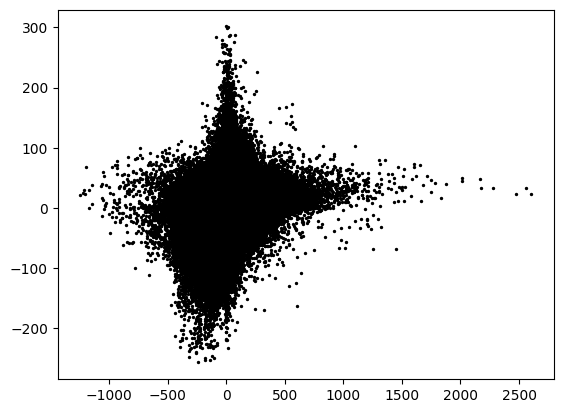

In [80]:
plt.scatter(Targets_2015['dbe'][start:end+1].ravel(),Predictions_2015['dbe'][start:end+1].ravel(),s=2.0,c='k')
# plt.scatter(Targets_2015['dbe'].ravel(),prediction_weimer_dbe_2015.ravel(),s=2.0,c='b')

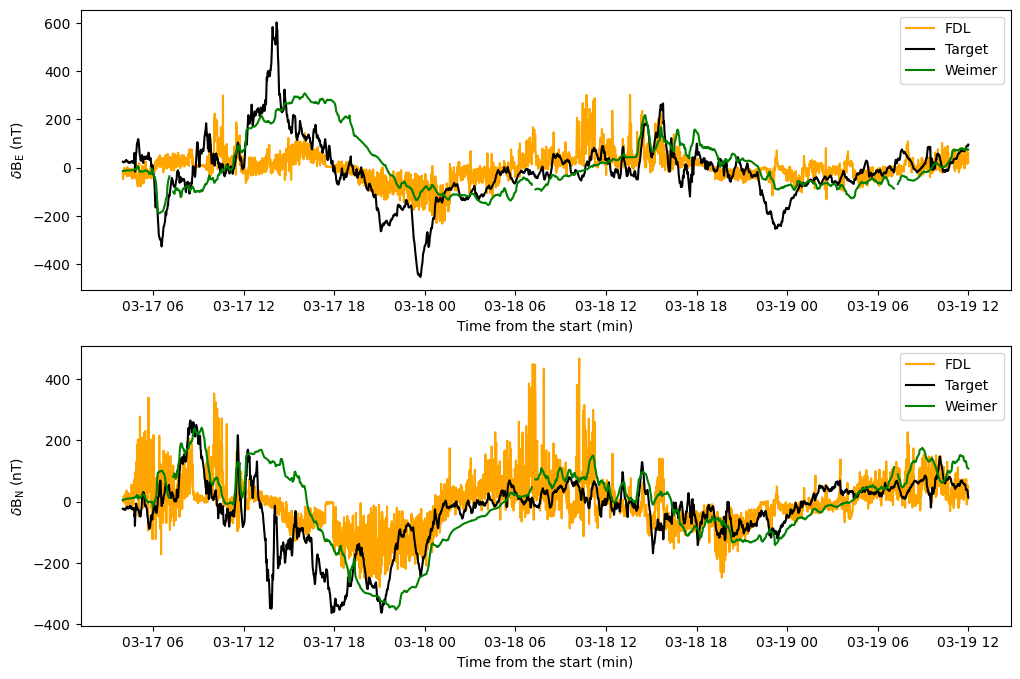

In [81]:
station_index = 100
plt.style.use('default')
fig,ax = plt.subplots(2,1,figsize=(12,8))

ax[0].plot(pd.to_datetime(Date_arr_2015['dbe'].ravel()[start:end+1],unit='s'),Predictions_2015['dbe'][start:end+1][:,station_index],'orange',label='FDL')
ax[0].plot(pd.to_datetime(Date_arr_2015['dbe'].ravel()[start:end+1],unit='s'),Targets_2015['dbe'][start:end+1][:,station_index],'k',label='Target')
ax[0].plot(pd.to_datetime(Date_arr_2015['dbe'].ravel()[start:end+1],unit='s'),prediction_weimer_dbe_2015[:,station_index],'g',label='Weimer')
ax[0].set_ylabel("$\\delta \mathrm{B}_{\mathrm{E}}$ (nT)")
ax[0].set_xlabel("Time from the start (min)")
ax[0].legend(loc='best')

ax[1].plot(pd.to_datetime(Date_arr_2015['dbn'].ravel()[start:end+1],unit='s'),Predictions_2015['dbn'][start:end+1][:,station_index],'orange',label='FDL')
ax[1].plot(pd.to_datetime(Date_arr_2015['dbn'].ravel()[start:end+1],unit='s'),Targets_2015['dbn'][start:end+1][:,station_index],'k',label='Target')
ax[1].plot(pd.to_datetime(Date_arr_2015['dbn'].ravel()[start:end+1],unit='s'),prediction_weimer_dbn_2015[:,station_index],'g',label='Weimer')
ax[1].set_ylabel("$\\delta \mathrm{B}_{\mathrm{N}}$ (nT)")
ax[1].set_xlabel("Time from the start (min)")
ax[1].legend(loc='best')

In [25]:
dt = pd.to_datetime(Date_arr_2015['dbn'].ravel()[start:end+1],unit='s')

In [26]:
dt[0].year,dt[0].month,eventmets_fdl_2015[thresh][k].shape

(2015, 3, (175,))

In [24]:
def get_stations(dt_array):
    yr,mth = dt_array[0].year,dt_array[0].month
    npzfile = np.load(f"../full_data_panos/iaga/{yr}/supermag_iaga_{yr}_{mth}.npz")
    stations = npzfile['stations']
    return stations
def generate_table(eventmets_fdl,eventmets_weimer,pred_fdl_dbe,pred_fdl_dbn,pred_w_dbe,pred_w_dbn,targ_dbe,targ_dbn,dt_array):
    stations = get_stations(dt_array)
    N = len(stations)
    """
        Table format: One year, one table.
        
        Station -   MSE -     MAE -       18        - 42 - 66 - 90 
                - dbe dbn - dbe dbn - POD POFD PC HSS - ... so on  
        --------------------------------------------------------------
    
    
    """
    N_event= len(eventmets_fdl[0.3].keys())
    Ncols = N_event*len(eventmets_fdl.keys())+4
    yr = dt_array[0].year
    with open(f"../Paper/storm_{yr}.txt",'w') as file:
        file.write("\multirow{2}{*}{Station} & \multicolumn{%d}{|c|}{FDL model}  & \multicolumn{%d}{|c|}{Weimer model} \\\\ \n"%(Ncols,Ncols))
        file.write("\cline{2-%d} \n"%(Ncols*2+1))
        
        file.write(" & \multicolumn{2}{|c|}{MSE} &  \multicolumn{2}{|c|}{MAE} & ")
        file.write("\multicolumn{%d}{|c|}{18} &  \multicolumn{%d}{|c|}{42} & \multicolumn{%d}{|c|}{66} &  \multicolumn{%d}{|c|}{90} & "%(N_event,N_event,N_event,N_event))
        file.write(" \multicolumn{2}{|c|}{MSE} &  \multicolumn{2}{|c|}{MAE} & ")
        file.write("\multicolumn{%d}{|c|}{18} &  \multicolumn{%d}{|c|}{42} & \multicolumn{%d}{|c|}{66} &  \multicolumn{%d}{|c|}{90} \\\\ \n"%(N_event,N_event,N_event,N_event))
        file.write("\cline{2-%d} \n"%(Ncols*2+1))
        file.write("& $\delta b_e$ & $\delta b_n$ & $\delta b_e$ & $\delta b_n$")
        for tmpth in eventmets_fdl.keys():
            for tmpm in eventmets_fdl[tmpth].keys():
                file.write(f"& {tmpm.upper()}")

        file.write("& $\delta b_e$ & $\delta b_n$ & $\delta b_e$ & $\delta b_n$")
        for tmpth in eventmets_fdl.keys():
            for tmpm in eventmets_fdl[tmpth].keys():
                file.write(f"& {tmpm.upper()}")
        file.write("\\\\ \n") 
        file.write("\cline{1-%d} \n"%(Ncols*2+1))
        
        for i in np.arange(N):
            file.write(f"{stations[i]} &")
            er = np.sqrt(np.nanmean(np.square(pred_fdl_dbe[:,i]-targ_dbe[:,i])))
            file.write(f"{er:.2f} &".replace('nan','-'))
            er = np.sqrt(np.nanmean(np.square(pred_fdl_dbn[:,i]-targ_dbn[:,i])))
            file.write(f"{er:.2f} &".replace('nan','-'))
            er = np.nanmean(np.abs(pred_fdl_dbe[:,i]-targ_dbe[:,i]))
            file.write(f"{er:.2f} &".replace('nan','-'))
            er = np.nanmean(np.abs(pred_fdl_dbn[:,i]-targ_dbn[:,i]))
            file.write(f"{er:.2f} &".replace('nan','-'))
            for thresh in eventmets_fdl.keys():
                for j,k in enumerate(eventmets_fdl[thresh].keys()):  
                    file.write(f"{eventmets_fdl[thresh][k][i]:.2f} &".replace('nan','-'))
            er = np.sqrt(np.nanmean(np.square(pred_w_dbe[:,i]-targ_dbe[:,i])))
            file.write(f"{er:.2f} &".replace('nan','-'))
            er = np.sqrt(np.nanmean(np.square(pred_w_dbn[:,i]-targ_dbn[:,i])))
            file.write(f"{er:.2f} &".replace('nan','-'))
            er = np.nanmean(np.abs(pred_w_dbe[:,i]-targ_dbe[:,i]))
            file.write(f"{er:.2f} &".replace('nan','-'))
            er = np.nanmean(np.abs(pred_w_dbn[:,i]-targ_dbn[:,i]))
            file.write(f"{er:.2f} &".replace('nan','-'))
            for thresh in eventmets_weimer.keys():
                for j,k in enumerate(eventmets_weimer[thresh].keys()):  
                    if (j==len(eventmets_weimer[thresh].keys())-1) and (thresh==1.5):
                        file.write(f"{eventmets_weimer[thresh][k][i]:.2f} \\\\ \n".replace('nan','-'))
                    else:
                        file.write(f"{eventmets_weimer[thresh][k][i]:.2f} &".replace('nan','-'))

In [28]:
generate_table(eventmets_fdl_2015,eventmets_weimer_2015,Predictions_2015['dbe'][start:end+1],Predictions_2015['dbn'][start:end+1],
               prediction_weimer_dbe_2015,prediction_weimer_dbn_2015,Targets_2015['dbe'][start:end+1],Targets_2015['dbn'][start:end+1],
               pd.to_datetime(Date_arr_2015['dbn'].ravel()[start:end+1],unit='s'))

/tmp/ipykernel_23232/3530376581.py:44: RuntimeWarning: Mean of empty slice
  er = np.sqrt(np.nanmean(np.square(pred_fdl_dbe[:,i]-targ_dbe[:,i])))
/tmp/ipykernel_23232/3530376581.py:46: RuntimeWarning: Mean of empty slice
  er = np.sqrt(np.nanmean(np.square(pred_fdl_dbn[:,i]-targ_dbn[:,i])))
/tmp/ipykernel_23232/3530376581.py:48: RuntimeWarning: Mean of empty slice
  er = np.nanmean(np.abs(pred_fdl_dbe[:,i]-targ_dbe[:,i]))
/tmp/ipykernel_23232/3530376581.py:50: RuntimeWarning: Mean of empty slice
  er = np.nanmean(np.abs(pred_fdl_dbn[:,i]-targ_dbn[:,i]))
/tmp/ipykernel_23232/3530376581.py:55: RuntimeWarning: Mean of empty slice
  er = np.sqrt(np.nanmean(np.square(pred_w_dbe[:,i]-targ_dbe[:,i])))
/tmp/ipykernel_23232/3530376581.py:57: RuntimeWarning: Mean of empty slice
  er = np.sqrt(np.nanmean(np.square(pred_w_dbn[:,i]-targ_dbn[:,i])))
/tmp/ipykernel_23232/3530376581.py:59: RuntimeWarning: Mean of empty slice
  er = np.nanmean(np.abs(pred_w_dbe[:,i]-targ_dbe[:,i]))
/tmp/ipykernel_23232

### Plot of the top 3 best and worst performing stations

In [25]:
bbarg={'edgecolor':None,'facecolor':'white','alpha':0.0,'pad':100}
args={'horizontalalignment':'right','verticalalignment':'bottom','fontsize':15,'fontname':'Helvetica','fontweight':"bold"}
def Panel_label(i):
    return chr(97+i)

In [26]:
def plot_station(dt,fdl,targ,weim,ax,**kwargs):
    l1 = ax.plot(dt,fdl,c="#00c5ff",label='$\mathbf{DAGGER}$')
#     ax.yaxis.label.set_color("#00c5ff")
#     ax_tmp = ax.twinx()
    l2 = ax.plot(dt,targ,c="#181820",label=f"{kwargs['stat']}")
    ax.set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
#     ax_tmp.set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
    ax.set_title(f"{kwargs['metric']} = {kwargs['mval']:.2f} nT")
#     lns = l1+l2
#     labs = [l.get_label() for l in lns]
#     ax.spines['left'].set_color("#00c5ff")
#     ax.legend(lns, labs, loc='best')
    ax.legend(loc='best')
    ax.xaxis.get_majorticklabels()
    ax.tick_params(axis='x', rotation=-45)
    limy=ax.get_ylim()[-1]#0.94
    limx=ax.get_xlim()[0]-0.1#0.99
    ax.text(limx,limy,Panel_label(kwargs['pno']),args,bbox=bbarg)
    

In [279]:
pl_dt = pd.to_datetime(Date_arr_2015['dbe'].ravel()[start:end+1],unit='s')
stations = get_stations(pl_dt)

dbh_pred_2015 = np.sqrt(Predictions_2015['dbe'][start:end+1]**2+Predictions_2015['dbn'][start:end+1]**2)
dbh_w_2015 = np.sqrt(prediction_weimer_dbe_2015**2+prediction_weimer_dbn_2015**2)
dbh_targ_2015 = np.sqrt(Targets_2015['dbe'][start:end+1]**2+Targets_2015['dbn'][start:end+1]**2)

subset = ~np.isnan(dbh_targ_2015).any(axis=0)[:len(stations)]
dbh_pred_2015 = dbh_pred_2015[:,:len(stations)][:,subset]
dbh_w_2015 = dbh_w_2015[:,:len(stations)][:,subset]
dbh_targ_2015 = dbh_targ_2015[:,:len(stations)][:,subset]
stations = stations[subset]

mae_2015 = np.nanmean(np.abs(dbh_pred_2015-dbh_targ_2015),axis=0)
notnan = ~np.isnan(mae_2015) 
sort_mae = np.argsort(mae_2015[notnan])

mae_2015 = mae_2015[notnan]
dbh_pred_2015 = dbh_pred_2015[:,notnan]
dbh_w_2015 = dbh_w_2015[:,notnan]
dbh_targ_2015 = dbh_targ_2015[:,notnan]
stations = stations[notnan]

i_bz = np.where(wiemer_ds.omni_features=='bz')
i_s,i_e = wiemer_ds.sg_indices[:,-1][start],wiemer_ds.sg_indices[:,-1][end+1]
bz = wiemer_ds.omni[i_s:i_e,i_bz]*scalers['omni'][1][i_bz]+scalers['omni'][0][i_bz]

In [280]:
txtfile = pd.read_csv("../full_data_panos/symh/symh_2015.lst",delim_whitespace=True,header=None).values
ymd = pd.to_datetime(txtfile[:,1]-1, unit='D', origin=pd.Timestamp(f'{txtfile[0,0]}-01-01'))
date_symh = pd.to_datetime({'year':ymd.year,'month':ymd.month,'day':ymd.day,'hour':txtfile[:,2],'minute':txtfile[:,3]})
symh_inds = np.argmin(np.abs(date_symh.to_numpy().reshape([1,-1])-pl_dt.to_numpy().reshape([-1,1])),axis=-1)
symh_value = txtfile[:,-1][symh_inds]

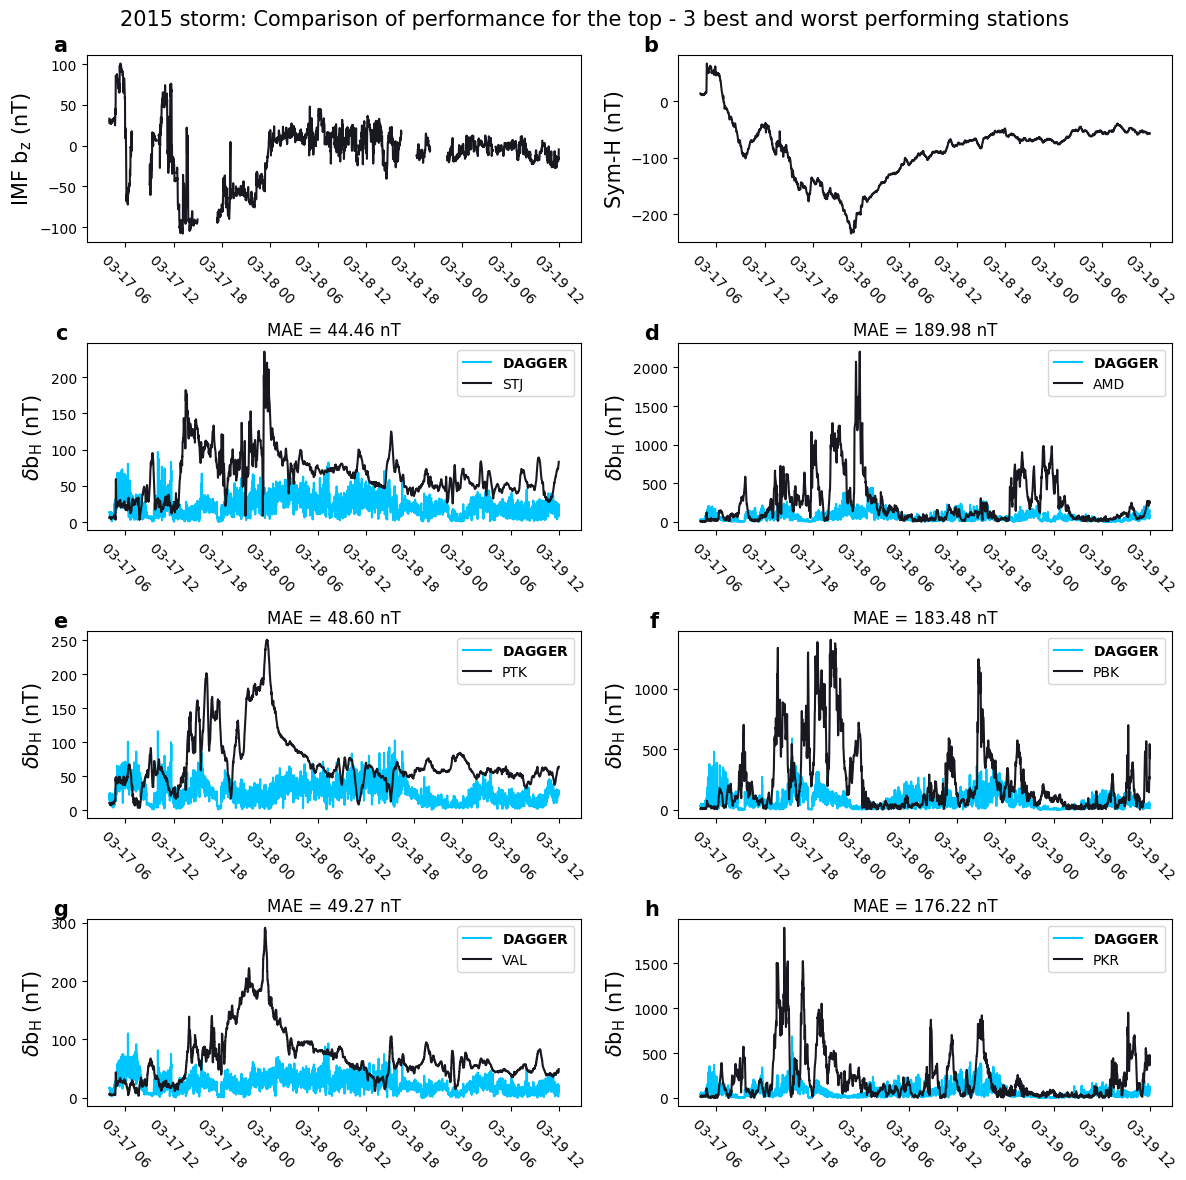

In [107]:
plt.style.use('default')
fig,ax = plt.subplots(4,2,figsize=(12,12))

ax[0,0].plot(pl_dt,bz.ravel(),c="#181820")
ax[0,0].set_ylabel("IMF $\mathrm{b}_{\mathrm{z}}$ (nT)",fontsize=15)
ax[0,0].xaxis.get_majorticklabels()
ax[0,0].tick_params(axis='x', rotation=-45)
limy=ax[0,0].get_ylim()[-1]#0.94
limx=ax[0,0].get_xlim()[0]-0.1#0.99
ax[0,0].text(limx,limy,Panel_label(0),args,bbox=bbarg)
    
ax[0,1].plot(pl_dt,symh_value.ravel(),c="#181820")
ax[0,1].set_ylabel("Sym-H (nT)",fontsize=15)
ax[0,1].xaxis.get_majorticklabels()
ax[0,1].tick_params(axis='x', rotation=-45)
limy=ax[0,1].get_ylim()[-1]#0.94
limx=ax[0,1].get_xlim()[0]-0.1#0.99
ax[0,1].text(limx,limy,Panel_label(1),args,bbox=bbarg)

for i in np.arange(3):
    plot_station(pl_dt,dbh_pred_2015[:,sort_mae[i]],dbh_targ_2015[:,sort_mae[i]],dbh_w_2015[:,sort_mae[i]],ax[i+1,0],
                stat=stations[sort_mae[i]],metric='MAE',mval=mae_2015[sort_mae[i]],pno=2*i+2)
for i in np.arange(3):
    plot_station(pl_dt,dbh_pred_2015[:,sort_mae[-i-1]],dbh_targ_2015[:,sort_mae[-i-1]],dbh_w_2015[:,sort_mae[-i-1]],ax[i+1,1],
                stat=stations[sort_mae[-i-1]],metric='MAE',mval=mae_2015[sort_mae[-i-1]],pno=2*i+3)
fig.suptitle("2015 storm: Comparison of performance for the top - 3 best and worst performing stations",fontsize=15)
fig.tight_layout()
fig.savefig("../Paper/figures/storm_2015_top3stations.pdf",dpi=300)

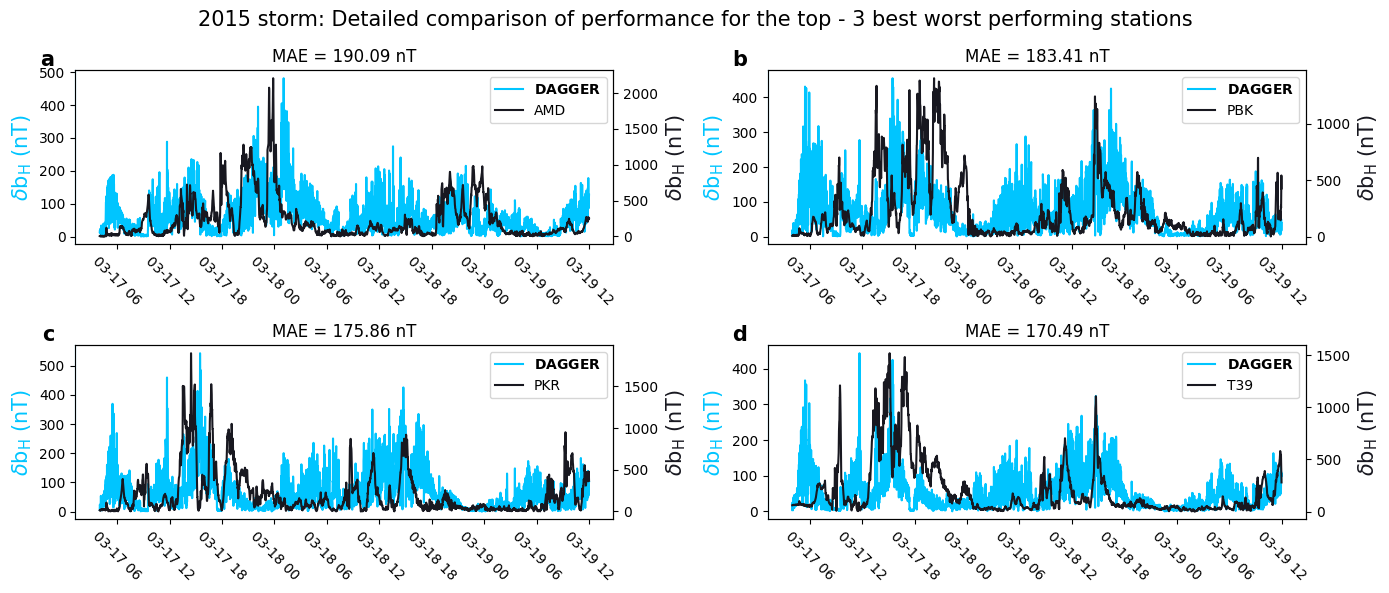

In [281]:
# We can take a closer look at a couple of stations which show bad forecast/
plt.style.use('default')
fig,ax = plt.subplots(2,2,figsize=(14,6))
ax = ax.reshape([-1,1])
for i in np.arange(4):
    l1 = ax[i,0].plot(pl_dt,dbh_pred_2015[:,sort_mae[-i-1]].ravel(),c="#00c5ff",label='$\mathbf{DAGGER}$')
    ax_tmp = ax[i,0].twinx()
    l2 = ax_tmp.plot(pl_dt,dbh_targ_2015[:,sort_mae[-i-1]],c="#181820",label=f"{stations[sort_mae[-i-1]]}")
    ax[i,0].set_title(f"MAE = {mae_2015[sort_mae[-i-1]]:.2f} nT")
    ax[i,0].set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
    ax[i,0].yaxis.label.set_color("#00c5ff")
        
    lns = l1+l2
    labs = [l.get_label() for l in lns]
    ax[i,0].spines['left'].set_color("#00c5ff")
    ax[i,0].legend(lns, labs, loc='best')
    ax_tmp.set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
    ax_tmp.yaxis.label.set_color("#181820")

    ax[i,0].xaxis.get_majorticklabels()
    ax[i,0].tick_params(axis='x', rotation=-45)
    limy=ax[i,0].get_ylim()[-1]#0.94
    limx=ax[i,0].get_xlim()[0]-0.1#0.99
    ax[i,0].text(limx,limy,Panel_label(i),args,bbox=bbarg)
# for i in np.arange(3):
#     l1 = ax[i,1].plot(pl_dt,dbh_pred_2015[:,sort_mae[-i-1]].ravel(),c="#00c5ff",label='$\mathbf{DAGGER}$')
#     ax_tmp = ax[i,1].twinx()
#     l2 = ax_tmp.plot(pl_dt,dbh_targ_2015[:,sort_mae[-i-1]],c="#181820",label=f"{stations[sort_mae[-i-1]]}")
#     ax[i,1].set_title(f"MAE = {mae_2015[sort_mae[-i-1]]:.2f} nT")
#     ax[i,1].set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
#     ax[i,1].yaxis.label.set_color("#00c5ff")
        
#     lns = l1+l2
#     labs = [l.get_label() for l in lns]
#     ax[i,1].spines['left'].set_color("#00c5ff")
#     ax[i,1].legend(lns, labs, loc='best')
#     ax_tmp.set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
#     ax_tmp.yaxis.label.set_color("#181820")

#     ax[i,1].xaxis.get_majorticklabels()
#     ax[i,1].tick_params(axis='x', rotation=-45)
#     limy=ax[i,1].get_ylim()[-1]#0.94
#     limx=ax[i,1].get_xlim()[0]-0.1#0.99
#     ax[i,1].text(limx,limy,Panel_label(i),args,bbox=bbarg)
    
fig.suptitle("2015 storm: Detailed comparison of performance for the top - 3 best worst performing stations",fontsize=15)
fig.tight_layout()
fig.savefig("../Paper/figures/storm_2015_details.pdf",dpi=300)

------------------------

## 2011 storm

### Load the Weimer forecasts

In [29]:
weimer_2011 = {}
with h5py.File(f"../data_local/weimer/2011/TimeStepGeomagnetic_20110805_1min.h5", "r") as f:
    for k in f.keys():
        weimer_2011[k] = f.get(k)[:]

weimer_times_unix_2011 = Time(weimer_2011['JDTIMES'],format='jd').to_value('unix')

In [30]:
dataset = np.load("../Subset/Weimer/2011/supermag_omni_data.npz")
supermag_data_2011 = SuperMAGIAGADataset(dataset['dates'],dataset['data'],dataset['features'])
omni_data_2011 = OMNIDataset(pd.DataFrame(data=dataset['omni'],columns=dataset['omni_features']))
storm_idx = dataset['idx']

In [31]:
storm_dataset = ShpericalHarmonicsDatasetBucketized(supermag_data_2011,omni_data_2011,storm_idx,
        f107_dataset="../Subset/Weimer/2011/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=scalers,training_batch=False,nmax=nmax,inference=True)
storm_loader = data.DataLoader(storm_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

extracting f107
using existing scaler


### FDL Forecast

In [32]:
Predictions_2011,Targets_2011,All_times_coeff_2011,Date_arr_2011,MLT_sup_all_2011,Mcolat_sup_all_2011 = Forecaster(storm_loader,model,dbe_mean,dbe_std,dbn_mean,dbn_std,target_index)

### Weimer forecasts on supermag

In [33]:
start_2011 = np.argmin(np.abs(Date_arr_2011['dbe']-weimer_times_unix_2011[0]))
end_2011 = np.argmin(np.abs(Date_arr_2011['dbe']-weimer_times_unix_2011[-1]))

In [34]:
weimer_2011['DB'][:,1].shape,MLT_sup_all_2011['dbe'].shape,Mcolat_sup_all_2011['dbe'].shape, Predictions_2011['dbe'].shape

((2581, 100, 96), (2581, 175), (2581, 175), (2581, 175))

### Get the Weimer basis

In [35]:
print(weimer_2011.keys())
weimer_mlt_2011 = np.deg2rad(90-weimer_2011['GRIDMLTS']*360/24.0)
weimer_colat_2011 = np.deg2rad(90 - weimer_2011['GRIDLATS'])
weimer_basis_2011 = basis_matrix(nmax ,weimer_mlt_2011, weimer_colat_2011)
weimer_shape_2011 = weimer_2011['GRIDMLTS'].shape


dict_keys(['DB', 'GRIDLATS', 'GRIDMLTS', 'JDTIMES', 'LATITUDES', 'MLTVALS'])


In [36]:
prediction_weimer_dbn_2011 = Generate_complete_weimer_forecast(weimer_mlt_2011[0,:],weimer_colat_2011[:,0],weimer_2011['DB'][:,0],
                                                          MLT_sup_all_2011['dbn'][start_2011:end_2011+1],Mcolat_sup_all_2011['dbn'][start_2011:end_2011+1])
prediction_weimer_dbe_2011 = Generate_complete_weimer_forecast(weimer_mlt_2011[0,:],weimer_colat_2011[:,0],weimer_2011['DB'][:,1],
                                                          MLT_sup_all_2011['dbe'][start_2011:end_2011+1],Mcolat_sup_all_2011['dbe'][start_2011:end_2011+1])

### Generate metrics

In [37]:
Targets_2011['dbe'].shape,Predictions_2011['dbe'].shape

((2581, 175), (2581, 175))

In [38]:
fdl_metrics_dbe_2011 = Generate_metrics(Targets_2011['dbe'][start_2011:end_2011+1],Predictions_2011['dbe'][start_2011:end_2011+1])
fdl_metrics_dbn_2011 = Generate_metrics(Targets_2011['dbn'][start_2011:end_2011+1],Predictions_2011['dbn'][start_2011:end_2011+1])

weimer_metrics_dbe_2011 = Generate_metrics(Targets_2011['dbe'][start_2011:end_2011+1],prediction_weimer_dbn_2011)
weimer_metrics_dbn_2011 = Generate_metrics(Targets_2011['dbn'][start_2011:end_2011+1],prediction_weimer_dbe_2011)

In [39]:
print(f"FDL dbe:{fdl_metrics_dbe_2011}")
print(f"Weimer dbe:{weimer_metrics_dbe_2011}")
print("--------------------")
print(f"FDL dbn: {fdl_metrics_dbn_2011}")
print(f"Weimer dbn: {weimer_metrics_dbn_2011}")

FDL dbe:{'mse': 72.87439164008384, 'mae': 34.9766273678371, 'r2': -0.0012005920189442824}
Weimer dbe:{'mse': 127.54813462536887, 'mae': 67.40957899675112, 'r2': -3.920962221623218}
--------------------
FDL dbn: {'mse': 98.32853585036335, 'mae': 52.691679820873404, 'r2': -0.009362764587497104}
Weimer dbn: {'mse': 140.93849483996638, 'mae': 76.74773204486179, 'r2': -0.8571321181684023}


In [40]:
eventmets_fdl_2011 = EventMetrics(Targets_2011['dbe'][start_2011:end_2011+1],Targets_2011['dbn'][start_2011:end_2011+1],Predictions_2011['dbe'][start_2011:end_2011+1],Predictions_2011['dbn'][start_2011:end_2011+1])
eventmets_weimer_2011 = EventMetrics(Targets_2011['dbe'][start_2011:end_2011+1],Targets_2011['dbn'][start_2011:end_2011+1],prediction_weimer_dbe_2011,prediction_weimer_dbn_2011)

(20, 1)
(20, 1)
(20, 1)
(20, 1)


In [41]:
# Print the results in latex compatible format
# Take any key to get the metrics
k0 = list(eventmets_fdl_2011.keys())[0]
for i,k in enumerate(eventmets_fdl_2011[k0].keys()):
    if i==0:
        print("\multirow{%d}{*}{2011} &"%(len(eventmets_fdl_2011[k0].keys())),end=" ")
    else:
        print("& ",end=" ")
    print(f"{k.upper()}",end=" ")
    for thresh in eventmets_fdl_2011.keys():
        mn = np.nanmean(eventmets_fdl_2011[thresh][k])
        std = np.nanstd(eventmets_fdl_2011[thresh][k])/np.sqrt(np.sum(~np.isnan(eventmets_fdl_2011[thresh][k])))
        print(f"& {mn:.2f} $\pm$ {std:.2f}",end=" ")
    for thresh in eventmets_weimer_2011.keys():
        mn = np.nanmean(eventmets_weimer_2011[thresh][k])
        std = np.nanstd(eventmets_weimer_2011[thresh][k])/np.sqrt(np.sum(~np.isnan(eventmets_weimer_2011[thresh][k])))
        print(f"& {mn:.2f}$\pm${std:.2f}",end=" ")
    print("\\\\ \n")

\multirow{4}{*}{2011} & POD & 0.62 $\pm$ 0.03 & 0.58 $\pm$ 0.03 & 0.42 $\pm$ 0.04 & 0.31 $\pm$ 0.04 & 0.17$\pm$0.01 & 0.09$\pm$0.01 & 0.05$\pm$0.01 & 0.01$\pm$0.01 \\ 

&  POFD & 0.13 $\pm$ 0.01 & 0.07 $\pm$ 0.01 & 0.05 $\pm$ 0.00 & 0.02 $\pm$ 0.00 & 0.01$\pm$0.00 & 0.00$\pm$0.00 & 0.00$\pm$0.00 & 0.00$\pm$0.00 \\ 

&  PC & 0.87 $\pm$ 0.01 & 0.92 $\pm$ 0.01 & 0.94 $\pm$ 0.01 & 0.97 $\pm$ 0.00 & 0.86$\pm$0.01 & 0.94$\pm$0.01 & 0.97$\pm$0.00 & 0.98$\pm$0.00 \\ 

&  HSS & 0.37 $\pm$ 0.02 & 0.30 $\pm$ 0.02 & 0.22 $\pm$ 0.03 & 0.17 $\pm$ 0.03 & 0.18$\pm$0.01 & 0.12$\pm$0.01 & 0.06$\pm$0.02 & 0.02$\pm$0.01 \\ 



## Check plots

In [46]:
Targets_2011['dbe'].shape,Predictions_2011['dbe'].shape,prediction_weimer_dbn_2011.shape

((2581, 175), (2581, 175), (2581, 175))

In [47]:
generate_table(eventmets_fdl_2011,eventmets_weimer_2011,Predictions_2011['dbe'][start_2011:end_2011+1],Predictions_2011['dbn'][start_2011:end_2011+1],
               prediction_weimer_dbe_2011,prediction_weimer_dbn_2011,Targets_2011['dbe'][start_2011:end_2011+1],Targets_2011['dbn'][start_2011:end_2011+1],
               pd.to_datetime(Date_arr_2011['dbn'].ravel()[start_2011:end_2011+1],unit='s'))

/tmp/ipykernel_23232/3530376581.py:44: RuntimeWarning: Mean of empty slice
  er = np.sqrt(np.nanmean(np.square(pred_fdl_dbe[:,i]-targ_dbe[:,i])))
/tmp/ipykernel_23232/3530376581.py:46: RuntimeWarning: Mean of empty slice
  er = np.sqrt(np.nanmean(np.square(pred_fdl_dbn[:,i]-targ_dbn[:,i])))
/tmp/ipykernel_23232/3530376581.py:48: RuntimeWarning: Mean of empty slice
  er = np.nanmean(np.abs(pred_fdl_dbe[:,i]-targ_dbe[:,i]))
/tmp/ipykernel_23232/3530376581.py:50: RuntimeWarning: Mean of empty slice
  er = np.nanmean(np.abs(pred_fdl_dbn[:,i]-targ_dbn[:,i]))
/tmp/ipykernel_23232/3530376581.py:55: RuntimeWarning: Mean of empty slice
  er = np.sqrt(np.nanmean(np.square(pred_w_dbe[:,i]-targ_dbe[:,i])))
/tmp/ipykernel_23232/3530376581.py:57: RuntimeWarning: Mean of empty slice
  er = np.sqrt(np.nanmean(np.square(pred_w_dbn[:,i]-targ_dbn[:,i])))
/tmp/ipykernel_23232/3530376581.py:59: RuntimeWarning: Mean of empty slice
  er = np.nanmean(np.abs(pred_w_dbe[:,i]-targ_dbe[:,i]))
/tmp/ipykernel_23232

### Plot of the top 3 best and worst performing stations

In [42]:
def plot_station(dt,fdl,targ,weim,ax,**kwargs):
    l1 = ax.plot(dt,fdl,c="#00c5ff",label='$\mathbf{DAGGER}$')
#     ax.yaxis.label.set_color("#00c5ff")
#     ax_tmp = ax.twinx()
    l2 = ax.plot(dt,targ,c="#181820",label=f"{kwargs['stat']}")
    ax.set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
#     ax_tmp.set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
    ax.set_title(f"{kwargs['metric']} = {kwargs['mval']:.2f} nT")
#     lns = l1+l2
#     labs = [l.get_label() for l in lns]
#     ax.spines['left'].set_color("#00c5ff")
#     ax.legend(lns, labs, loc='best')
    ax.legend(loc='best')
    ax.xaxis.get_majorticklabels()
    ax.tick_params(axis='x', rotation=-45)
    limy=ax.get_ylim()[-1]#0.94
    limx=ax.get_xlim()[0]-0.1#0.99
    ax.text(limx,limy,Panel_label(kwargs['pno']),args,bbox=bbarg)
    

In [271]:
pl_dt = pd.to_datetime(Date_arr_2011['dbe'].ravel()[start_2011:end_2011+1],unit='s')
stations = get_stations(pl_dt)

dbh_pred_2011 = np.sqrt(Predictions_2011['dbe'][start_2011:end_2011+1]**2+Predictions_2011['dbn'][start_2011:end_2011+1]**2)
dbh_w_2011 = np.sqrt(prediction_weimer_dbe_2011**2+prediction_weimer_dbn_2011**2)
dbh_targ_2011 = np.sqrt(Targets_2011['dbe'][start_2011:end_2011+1]**2+Targets_2011['dbn'][start_2011:end_2011+1]**2)

subset = ~np.isnan(dbh_targ_2011).any(axis=0)[:len(stations)]
dbh_pred_2011 = dbh_pred_2011[:,:len(stations)][:,subset]
dbh_w_2011 = dbh_w_2011[:,:len(stations)][:,subset]
dbh_targ_2011 = dbh_targ_2011[:,:len(stations)][:,subset]
stations = stations[subset]

mae_2011 = np.nanmean(np.abs(dbh_pred_2011-dbh_targ_2011),axis=0)
notnan = ~np.isnan(mae_2011) 
sort_mae = np.argsort(mae_2011[notnan])

mae_2011 = mae_2011[notnan]
dbh_pred_2011 = dbh_pred_2011[:,notnan]
dbh_w_2011 = dbh_w_2011[:,notnan]
dbh_targ_2011 = dbh_targ_2011[:,notnan]
stations = stations[notnan]

i_bz = np.where(storm_dataset.omni_features=='bz')
i_s,i_e = storm_dataset.sg_indices[0,-1],storm_dataset.sg_indices[-1,-1]+1
bz = storm_dataset.omni[i_s:i_e,i_bz]*scalers['omni'][1][i_bz]+scalers['omni'][0][i_bz]

In [272]:
txtfile = pd.read_csv("../full_data_panos/symh/symh_2011.lst",delim_whitespace=True,header=None).values
ymd = pd.to_datetime(txtfile[:,1]-1, unit='D', origin=pd.Timestamp(f'{txtfile[0,0]}-01-01'))
date_symh = pd.to_datetime({'year':ymd.year,'month':ymd.month,'day':ymd.day,'hour':txtfile[:,2],'minute':txtfile[:,3]})
symh_inds = np.argmin(np.abs(date_symh.to_numpy().reshape([1,-1])-pl_dt.to_numpy().reshape([-1,1])),axis=-1)
symh_value = txtfile[:,-1][symh_inds]

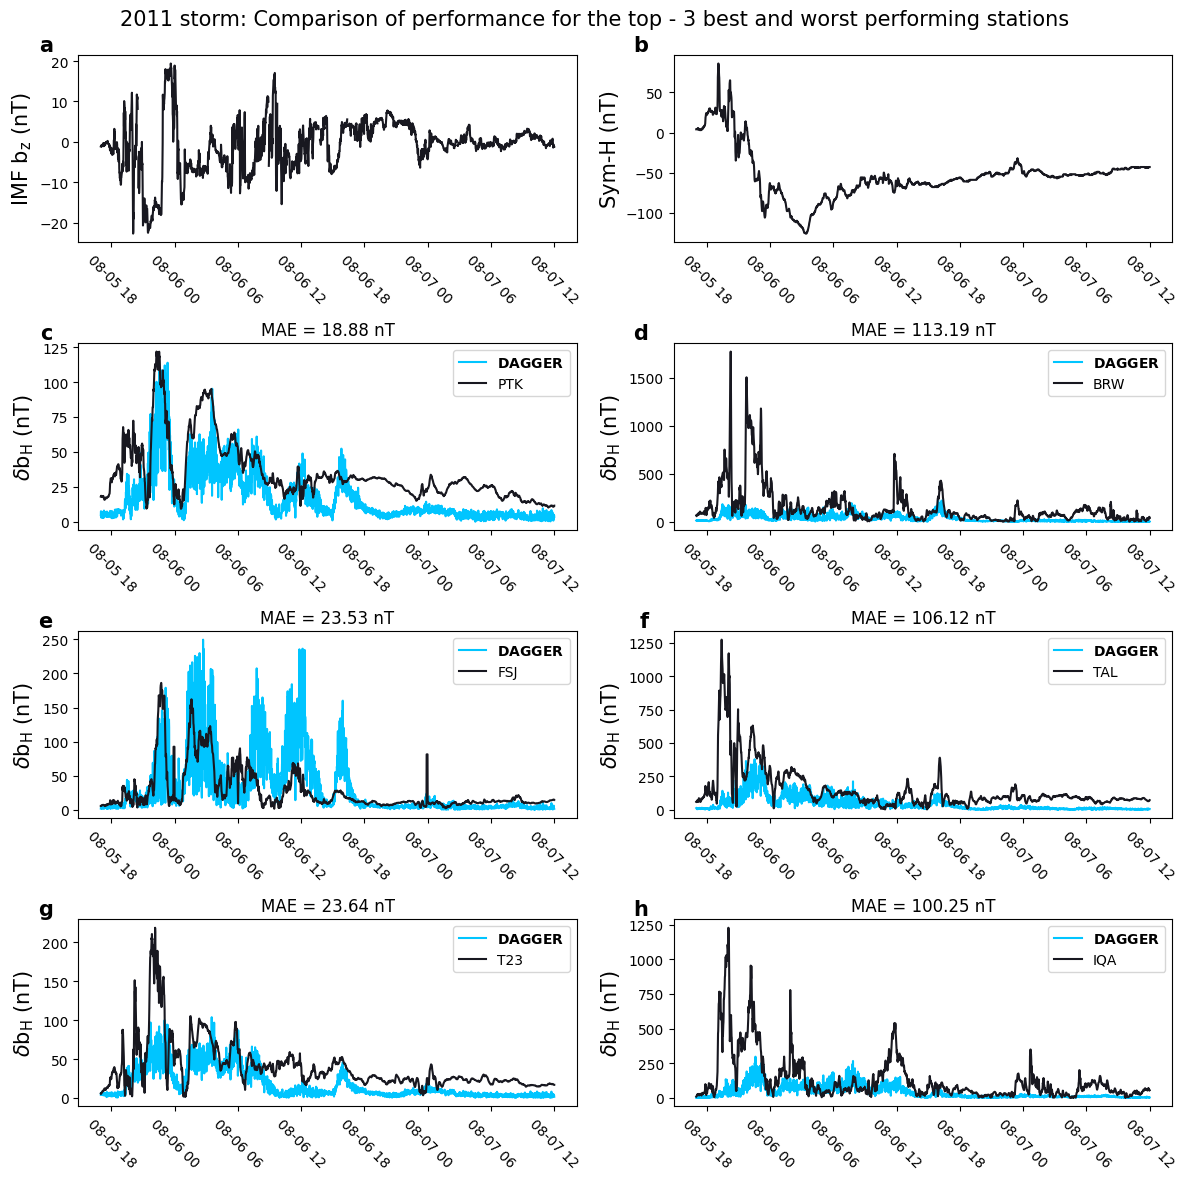

In [102]:
plt.style.use('default')
fig,ax = plt.subplots(4,2,figsize=(12,12))

ax[0,0].plot(pl_dt,bz.ravel(),c="#181820")
ax[0,0].set_ylabel("IMF $\mathrm{b}_{\mathrm{z}}$ (nT)",fontsize=15)
ax[0,0].xaxis.get_majorticklabels()
ax[0,0].tick_params(axis='x', rotation=-45)
limy=ax[0,0].get_ylim()[-1]#0.94
limx=ax[0,0].get_xlim()[0]-0.1#0.99
ax[0,0].text(limx,limy,Panel_label(0),args,bbox=bbarg)

ax[0,1].plot(pl_dt,symh_value.ravel(),c="#181820")
ax[0,1].set_ylabel("Sym-H (nT)",fontsize=15)
ax[0,1].xaxis.get_majorticklabels()
ax[0,1].tick_params(axis='x', rotation=-45)
limy=ax[0,1].get_ylim()[-1]#0.94
limx=ax[0,1].get_xlim()[0]-0.1#0.99
ax[0,1].text(limx,limy,Panel_label(1),args,bbox=bbarg)

for i in np.arange(3):
    plot_station(pl_dt,dbh_pred_2011[:,sort_mae[i]],dbh_targ_2011[:,sort_mae[i]],dbh_w_2011[:,sort_mae[i]],ax[i+1,0],
                stat=stations[sort_mae[i]],metric='MAE',mval=mae_2011[sort_mae[i]],pno=2*i+2)
for i in np.arange(3):
    plot_station(pl_dt,dbh_pred_2011[:,sort_mae[-i-1]],dbh_targ_2011[:,sort_mae[-i-1]],dbh_w_2011[:,sort_mae[-i-1]],ax[i+1,1],
                stat=stations[sort_mae[-i-1]],metric='MAE',mval=mae_2011[sort_mae[-i-1]],pno=2*i+3)
fig.suptitle("2011 storm: Comparison of performance for the top - 3 best and worst performing stations",fontsize=15)
fig.tight_layout()
fig.savefig("../Paper/figures/storm_2011_top3stations.pdf",dpi=300)

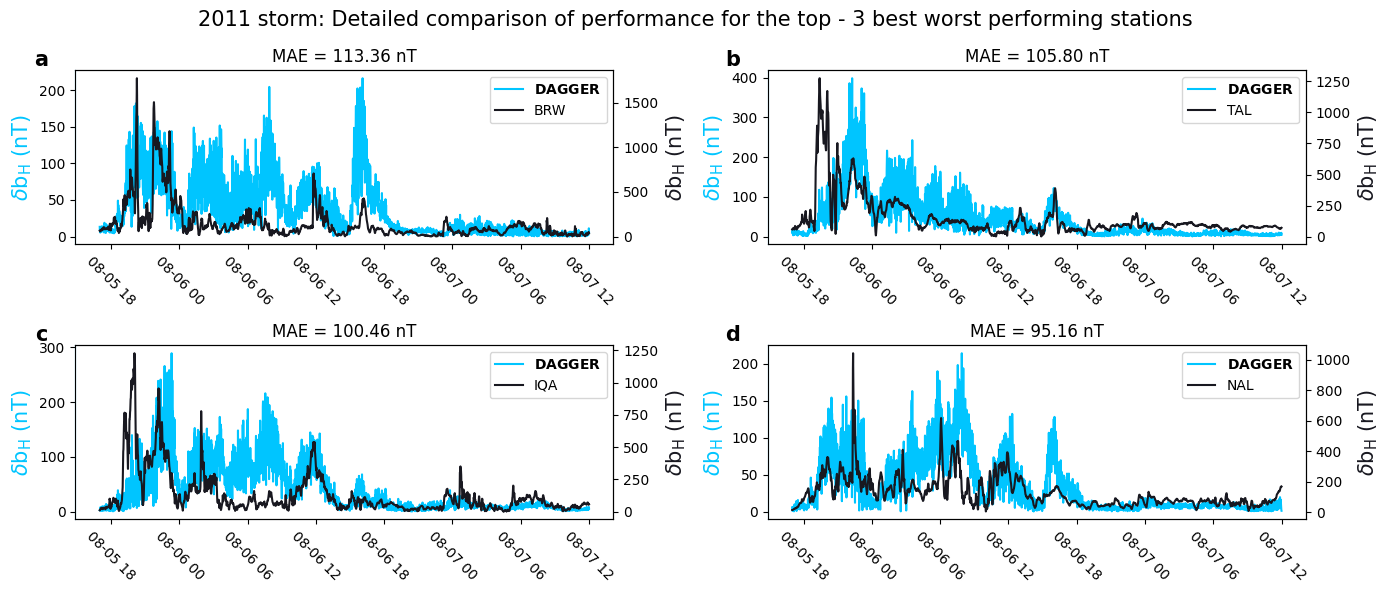

In [277]:
# We can take a closer look at a couple of stations which show bad forecast/
plt.style.use('default')
fig,ax = plt.subplots(2,2,figsize=(14,6))
ax = ax.reshape([-1,1])
for i in np.arange(4):
    l1 = ax[i,0].plot(pl_dt,dbh_pred_2011[:,sort_mae[-i-1]].ravel(),c="#00c5ff",label='$\mathbf{DAGGER}$')
    ax_tmp = ax[i,0].twinx()
    l2 = ax_tmp.plot(pl_dt,dbh_targ_2011[:,sort_mae[-i-1]],c="#181820",label=f"{stations[sort_mae[-i-1]]}")
    ax[i,0].set_title(f"MAE = {mae_2011[sort_mae[-i-1]]:.2f} nT")
    ax[i,0].set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
    ax[i,0].yaxis.label.set_color("#00c5ff")
        
    lns = l1+l2
    labs = [l.get_label() for l in lns]
    ax[i,0].spines['left'].set_color("#00c5ff")
    ax[i,0].legend(lns, labs, loc='best')
    ax_tmp.set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
    ax_tmp.yaxis.label.set_color("#181820")

    ax[i,0].xaxis.get_majorticklabels()
    ax[i,0].tick_params(axis='x', rotation=-45)
    limy=ax[i,0].get_ylim()[-1]#0.94
    limx=ax[i,0].get_xlim()[0]-0.1#0.99
    ax[i,0].text(limx,limy,Panel_label(i),args,bbox=bbarg)
# for i in np.arange(3):
#     l1 = ax[i,1].plot(pl_dt,dbh_pred_2011[:,sort_mae[-i-1]].ravel(),c="#00c5ff",label='$\mathbf{DAGGER}$')
#     ax_tmp = ax[i,1].twinx()
#     l2 = ax_tmp.plot(pl_dt,dbh_targ_2011[:,sort_mae[-i-1]],c="#181820",label=f"{stations[sort_mae[-i-1]]}")
#     ax[i,1].set_title(f"MAE = {mae_2011[sort_mae[-i-1]]:.2f} nT")
#     ax[i,1].set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
#     ax[i,1].yaxis.label.set_color("#00c5ff")
        
#     lns = l1+l2
#     labs = [l.get_label() for l in lns]
#     ax[i,1].spines['left'].set_color("#00c5ff")
#     ax[i,1].legend(lns, labs, loc='best')
#     ax_tmp.set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
#     ax_tmp.yaxis.label.set_color("#181820")

#     ax[i,1].xaxis.get_majorticklabels()
#     ax[i,1].tick_params(axis='x', rotation=-45)
#     limy=ax[i,1].get_ylim()[-1]#0.94
#     limx=ax[i,1].get_xlim()[0]-0.1#0.99
#     ax[i,1].text(limx,limy,Panel_label(i),args,bbox=bbarg)
    
fig.suptitle("2011 storm: Detailed comparison of performance for the top - 3 best worst performing stations",fontsize=15)
fig.tight_layout()
fig.savefig("../Paper/figures/storm_2011_details.pdf",dpi=300)

## dbH scatter plot for test, 2011 and 2015 storms

In [65]:
dbh_pred_2011 = np.sqrt(Predictions_2011['dbe'][start_2011:end_2011+1]**2+Predictions_2011['dbn'][start_2011:end_2011+1]**2).ravel()
dbh_targ_2011 = np.sqrt(Targets_2011['dbe'][start_2011:end_2011+1]**2+Targets_2011['dbn'][start_2011:end_2011+1]**2).ravel()
dbh_pred_2015 = np.sqrt(Predictions_2015['dbe'][start:end+1]**2+Predictions_2015['dbn'][start:end+1]**2).ravel()
dbh_targ_2015 = np.sqrt(Targets_2015['dbe'][start:end+1]**2+Targets_2015['dbn'][start:end+1]**2).ravel()
dbh_pred_test = np.sqrt(test_Predictions['dbe']**2+test_Predictions['dbn']**2).ravel()
dbh_targ_test = np.sqrt(test_Targets['dbe']**2+test_Targets['dbn']**2).ravel()

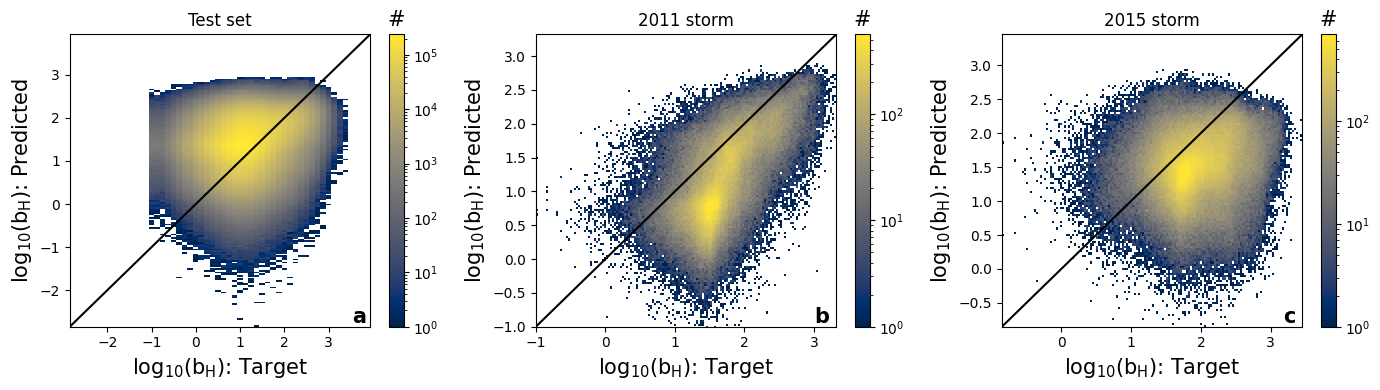

In [67]:
plt.style.use('default')
fig,ax = plt.subplots(1,3,figsize=(14,4))

# ax[0].scatter(np.log10(dbh_targ_test),np.log10(dbh_pred_test),s=1.0)
bad_indices = np.isnan(dbh_targ_test) | np.isnan(dbh_pred_test)
im = ax[0].hist2d(np.log10(dbh_targ_test[~bad_indices]),np.log10(dbh_pred_test[~bad_indices]),bins=150,cmap='cividis',norm=mpl.colors.LogNorm())
ax[0].set_ylabel("$\mathrm{log}_{10}(\mathrm{b}_{\mathrm{H}})$: Predicted",fontsize=15)
ax[0].set_xlabel("$\mathrm{log}_{10}(\mathrm{b}_{\mathrm{H}})$: Target",fontsize=15)
ax[0].set_xlim([np.nanmin(np.log10(dbh_pred_test.ravel())),np.nanmax(np.log10(dbh_targ_test.ravel()))+0.5])
ax[0].set_ylim(ax[0].get_xlim())
limy=ax[0].get_ylim()[0]#0.94
limx=ax[0].get_xlim()[-1]-0.1#0.99
ax[0].set_title("Test set")
ax[0].text(limx,limy,Panel_label(0),args,bbox=bbarg)
cbar = fig.colorbar(im[3], ax=ax[0], orientation='vertical')
cbar.ax.set_title("#",fontsize=15)
limy=ax[0].get_ylim()
limx=ax[0].get_xlim()
x_1 = np.linspace(limx[0],limx[1],4)
y_1 = x_1-limx[0]+limy[0]
ax[0].plot(x_1,y_1,'k')


bad_indices = np.isnan(dbh_targ_2011) | np.isnan(dbh_pred_2011)
im  = ax[1].hist2d(np.log10(dbh_targ_2011[~bad_indices]),np.log10(dbh_pred_2011[~bad_indices]),bins=150,cmap='cividis',norm=mpl.colors.LogNorm())
ax[1].set_ylabel("$\mathrm{log}_{10}(\mathrm{b}_{\mathrm{H}})$: Predicted",fontsize=15)
ax[1].set_xlabel("$\mathrm{log}_{10}(\mathrm{b}_{\mathrm{H}})$: Target",fontsize=15)
ax[1].set_ylim(ax[1].get_xlim())
limy=ax[1].get_ylim()[0]#0.94
limx=ax[1].get_xlim()[-1]-0.1#0.99
ax[1].set_title("2011 storm")
ax[1].text(limx,limy,Panel_label(1),args,bbox=bbarg)
cbar = fig.colorbar(im[3], ax=ax[1], orientation='vertical')
cbar.ax.set_title("#",fontsize=15)
limy=ax[1].get_ylim()
limx=ax[1].get_xlim()
x_1 = np.linspace(limx[0],limx[1],4)
y_1 = x_1-limx[0]+limy[0]
ax[1].plot(x_1,y_1,'k')

bad_indices = np.isnan(dbh_targ_2015) | np.isnan(dbh_pred_2015)
im  = ax[2].hist2d(np.log10(dbh_targ_2015[~bad_indices]),np.log10(dbh_pred_2015[~bad_indices]),bins=150,cmap='cividis',norm=mpl.colors.LogNorm())
ax[2].set_ylabel("$\mathrm{log}_{10}(\mathrm{b}_{\mathrm{H}})$: Predicted",fontsize=15)
ax[2].set_xlabel("$\mathrm{log}_{10}(\mathrm{b}_{\mathrm{H}})$: Target",fontsize=15)
ax[2].set_ylim(ax[2].get_xlim())
limy=ax[2].get_ylim()[0]#0.94
limx=ax[2].get_xlim()[-1]-0.1#0.99
ax[2].set_title("2015 storm")
ax[2].text(limx,limy,Panel_label(2),args,bbox=bbarg)
cbar = fig.colorbar(im[3], ax=ax[2], orientation='vertical')
cbar.ax.set_title("#",fontsize=15)
limy=ax[2].get_ylim()
limx=ax[2].get_xlim()
x_1 = np.linspace(limx[0],limx[1],4)
y_1 = x_1-limx[0]+limy[0]
ax[2].plot(x_1,y_1,'k')
fig.tight_layout()
fig.savefig("../Paper/figures/pred_targ_scatter.pdf",dpi=300)

## Making the video

Since we also want to display the full-earth plot of geomagnetic perturbation forecast, we can generate individual frames from the spherical harmonic coefficients, and make these plots.

Furthermore, we then pick out three snapshots corresponding to lowest, largest and median error for the two storms. Finally, we generate the video for the 3 storms and save them.

In [45]:
def Generate_sphere(MLT,Mcolat,Coeffs,dbn_mean,dbn_std,dbe_mean,dbe_std):
    _mlt = np.linspace(np.nanmin(MLT['dbe']),np.nanmax(MLT['dbe']),100)
    _colat = np.linspace(np.nanmin(Mcolat['dbe']),np.nanmax(Mcolat['dbe']),360)
    _mlt,_colat = np.meshgrid(_mlt,_colat)
    _basis = basis_matrix(nmax ,_mlt, _colat)
    
    fdl_on_grid_gif = {'dbe':[],'dbn':[]}
    fdl_on_grid_gif['dbn'] = np.einsum('bij,lj->bil',_basis,Coeffs['dbn'])
    fdl_on_grid_gif['dbe'] = np.einsum('bij,lj->bil',_basis,Coeffs['dbe'])

    fdl_on_grid_gif['dbn'] = fdl_on_grid_gif['dbn']*dbn_std + dbn_mean
    fdl_on_grid_gif['dbe'] = fdl_on_grid_gif['dbe']*dbe_std + dbe_mean
    # Sanity check.
    print(fdl_on_grid_gif['dbn'].shape,fdl_on_grid_gif['dbe'].shape)
    return fdl_on_grid_gif,_mlt,_colat


In [46]:
fdl_on_grid_gif_2015,_mlt_2015,_colat_2015 = Generate_sphere(MLT_sup_all_2015,Mcolat_sup_all_2015,
                                       All_times_coeff_2015,dbn_mean,dbn_std,dbe_mean,dbe_std)
fdl_on_grid_gif_2011,_mlt_2011,_colat_2011 = Generate_sphere(MLT_sup_all_2011,Mcolat_sup_all_2011,
                                       All_times_coeff_2011,dbn_mean,dbn_std,dbe_mean,dbe_std)

(360, 100, 36670) (360, 100, 36670)
(360, 100, 2581) (360, 100, 2581)


### Generate the three time stamps

In [47]:
dbh_pred_2011 = np.sqrt(Predictions_2011['dbe'][start_2011:end_2011+1]**2+Predictions_2011['dbn'][start_2011:end_2011+1]**2)
dbh_targ_2011 = np.sqrt(Targets_2011['dbe'][start_2011:end_2011+1]**2+Targets_2011['dbn'][start_2011:end_2011+1]**2)
dbh_pred_2015 = np.sqrt(Predictions_2015['dbe'][start:end+1]**2+Predictions_2015['dbn'][start:end+1]**2)
dbh_targ_2015 = np.sqrt(Targets_2015['dbe'][start:end+1]**2+Targets_2015['dbn'][start:end+1]**2)

In [52]:
print(dbh_targ_2015.shape,MLT_sup_all_2015['dbe'].shape)

(3361, 175) (36670, 175)


In [49]:
mae_2015 = np.nanmean(np.abs(dbh_pred_2015-dbh_targ_2015),axis=-1)
mae_2011 = np.nanmean(np.abs(dbh_pred_2011-dbh_targ_2011),axis=-1)

tipleinds_2015 = [np.argmin(mae_2015),np.where(mae_2015==np.median(mae_2015))[0][0],np.argmax(mae_2015)]
tipleinds_2011 = [np.argmin(mae_2011),np.where(mae_2011==np.median(mae_2011))[0][0],np.argmax(mae_2011)]

In [50]:
tipleinds_2015,tipleinds_2011,

([6, 2494, 1175], [0, 1969, 313])

In [94]:
def Columns_for_3_cases(fdl_on_grid_gif,Targets,dataset,_mlt,_colat,MLT,Mcolat,time_ind,label,**kwargs):
    plt.style.use("dark_background")
    fig1 = plt.figure(figsize=(8,12),dpi=200)
    gs = fig1.add_gridspec(2,8)

    theta = _mlt 
    phi = _colat 
    cmap=cm.get_cmap("RdYlBu_r",17)
    ax1 = fig1.add_subplot(gs[0,:-1], projection='polar')
    ax1.set_theta_offset(-np.pi/2)
    ax2 = fig1.add_subplot(gs[1,:-1], projection='polar')
    ax2.set_theta_offset(-np.pi/2)
    cax = fig1.add_subplot(gs[:,-1])
    
    d = dataset.dates[time_ind]
    cax.cla()
    dt = pd.to_datetime(d,unit='s')

    dbH2 = fdl_on_grid_gif[...,time_ind] 

    minp = kwargs.pop('minp',5)
    maxp = kwargs.pop('maxp',95)
    maxval = np.nanpercentile(dbH2,maxp)
    minval = np.nanpercentile(dbH2,minp)
    
    maxval=np.max([np.nanmax(fdl_on_grid_gif[...,time_ind]),np.nanmax(Targets[time_ind])])
    minval=np.min([np.nanmin(fdl_on_grid_gif[...,time_ind]),np.nanmin(Targets[time_ind])])
    midval=np.min([np.nanmean(fdl_on_grid_gif[...,time_ind]),np.nanmean(Targets[time_ind])])
    norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=midval, s1=3, s2=3)

    dbH = fdl_on_grid_gif[...,time_ind] 
    c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)  
    ax2.set_ylim([np.nanmin(Mcolat[time_ind]),np.nanmax(Mcolat[time_ind])])
    ax2.grid(linewidth=1,color='white',linestyle='--')
    ax2.text(3.5,1.1,f"30-min forecast",fontsize=15)

    dbH = Targets[time_ind] 
    c3=ax1.scatter(MLT[time_ind].ravel(),Mcolat[time_ind].ravel(), c=dbH.ravel(),cmap=cmap,norm=norm,s=36)
    ax1.text(3.45,1.16,f"Target SuperMag",fontsize=15)
    ax1.grid(linewidth=2,color='white')
    fig1.colorbar(c3, cax=cax,orientation='vertical')
    cax.set_ylabel(label,fontsize=15)


In [61]:
fdl_on_grid_gif_2011['dbe'].shape,dbh_targ_2011.shape,Predictions_2011['dbe'].shape,end_2011-start_2011

((360, 100, 2581), (2581, 175), (2581, 175), 2580)

In [98]:
tmp_bh = np.sqrt(fdl_on_grid_gif_2011['dbe'][start_2011:end_2011+1]**2+fdl_on_grid_gif_2011['dbn'][start_2011:end_2011+1]**2)

/tmp/ipykernel_26051/3300467944.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


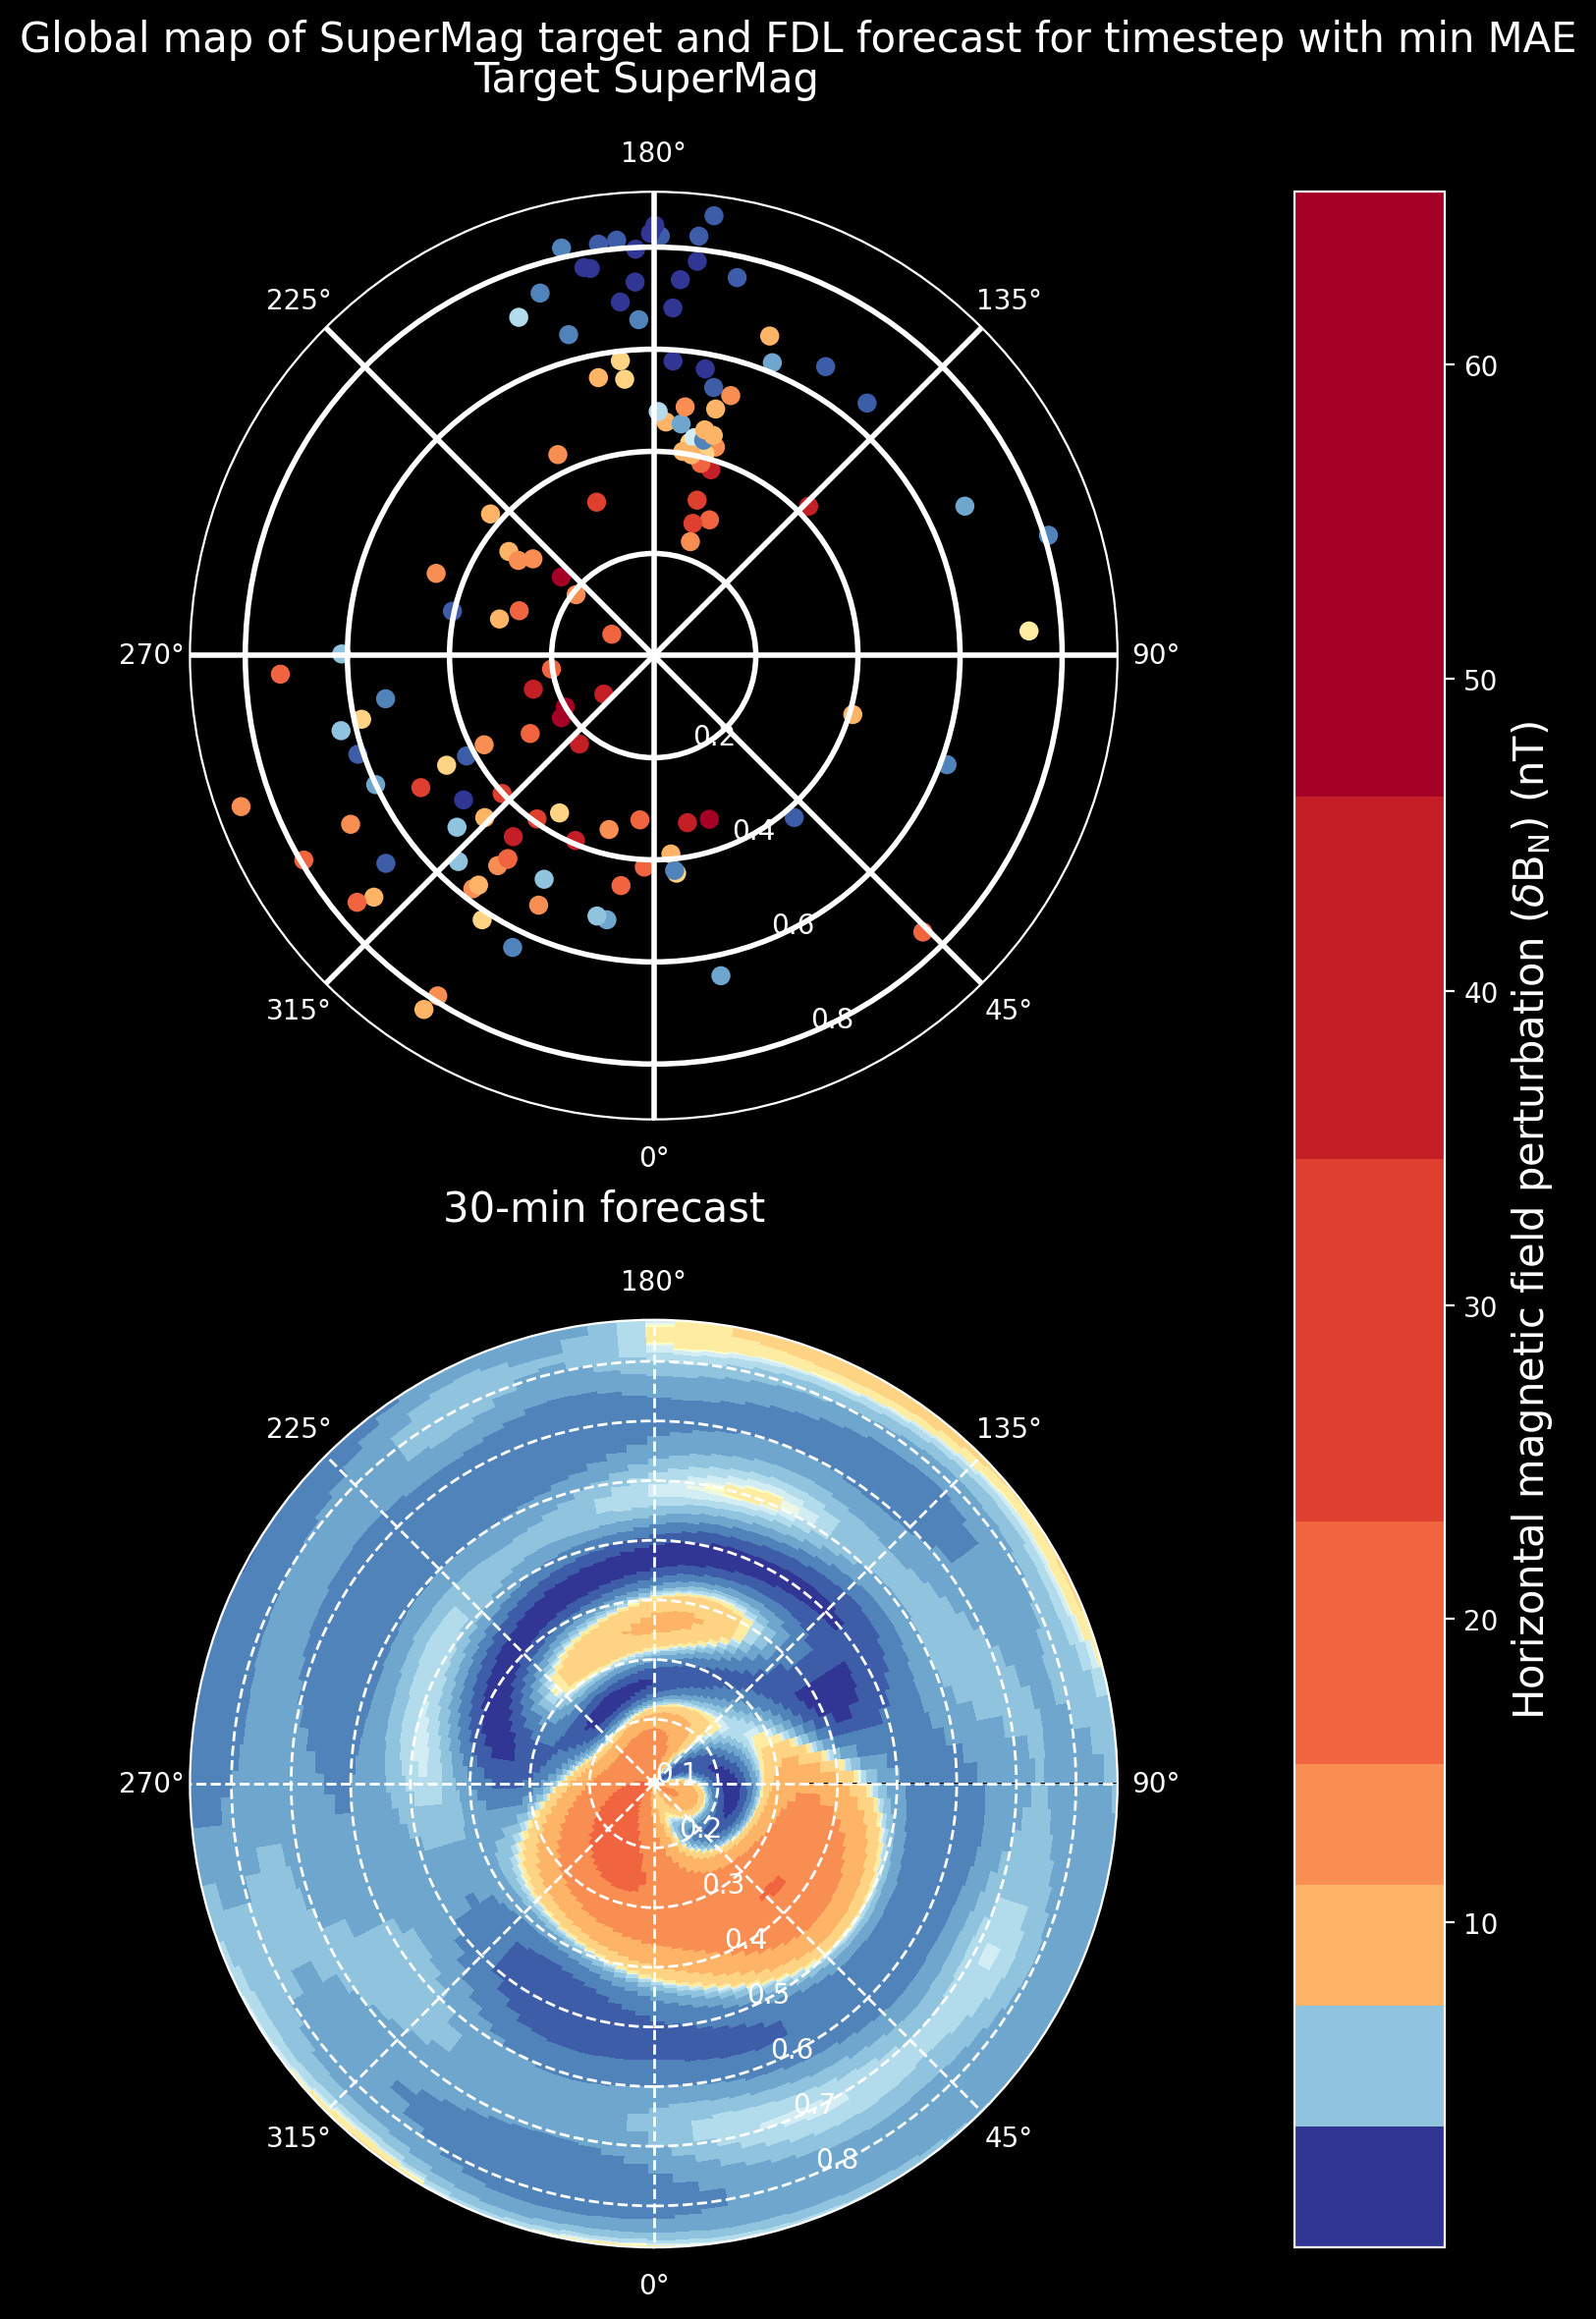

In [99]:
ind_select = 0
suptitle = {0: "min MAE", 1:"mean MAE", 2: "max MAE"}
Columns_for_3_cases(tmp_bh,dbh_targ_2011[start_2011:end_2011+1],storm_dataset,_mlt_2011,_colat_2011,
                    MLT_sup_all_2011['dbe'][start_2011:end_2011+1],Mcolat_sup_all_2011['dbe'][start_2011:end_2011+1],tipleinds_2011[ind_select],
                    label = r'Horizontal magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)',
                   minp=2)
plt.suptitle(f"Global map of SuperMag target and FDL forecast for timestep with {suptitle[ind_select]}",fontsize=15)
plt.tight_layout()
plt.savefig("../Paper/figures/storm_2011_minMAE_dbh.pdf",dpi=300)

/tmp/ipykernel_26051/3300467944.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


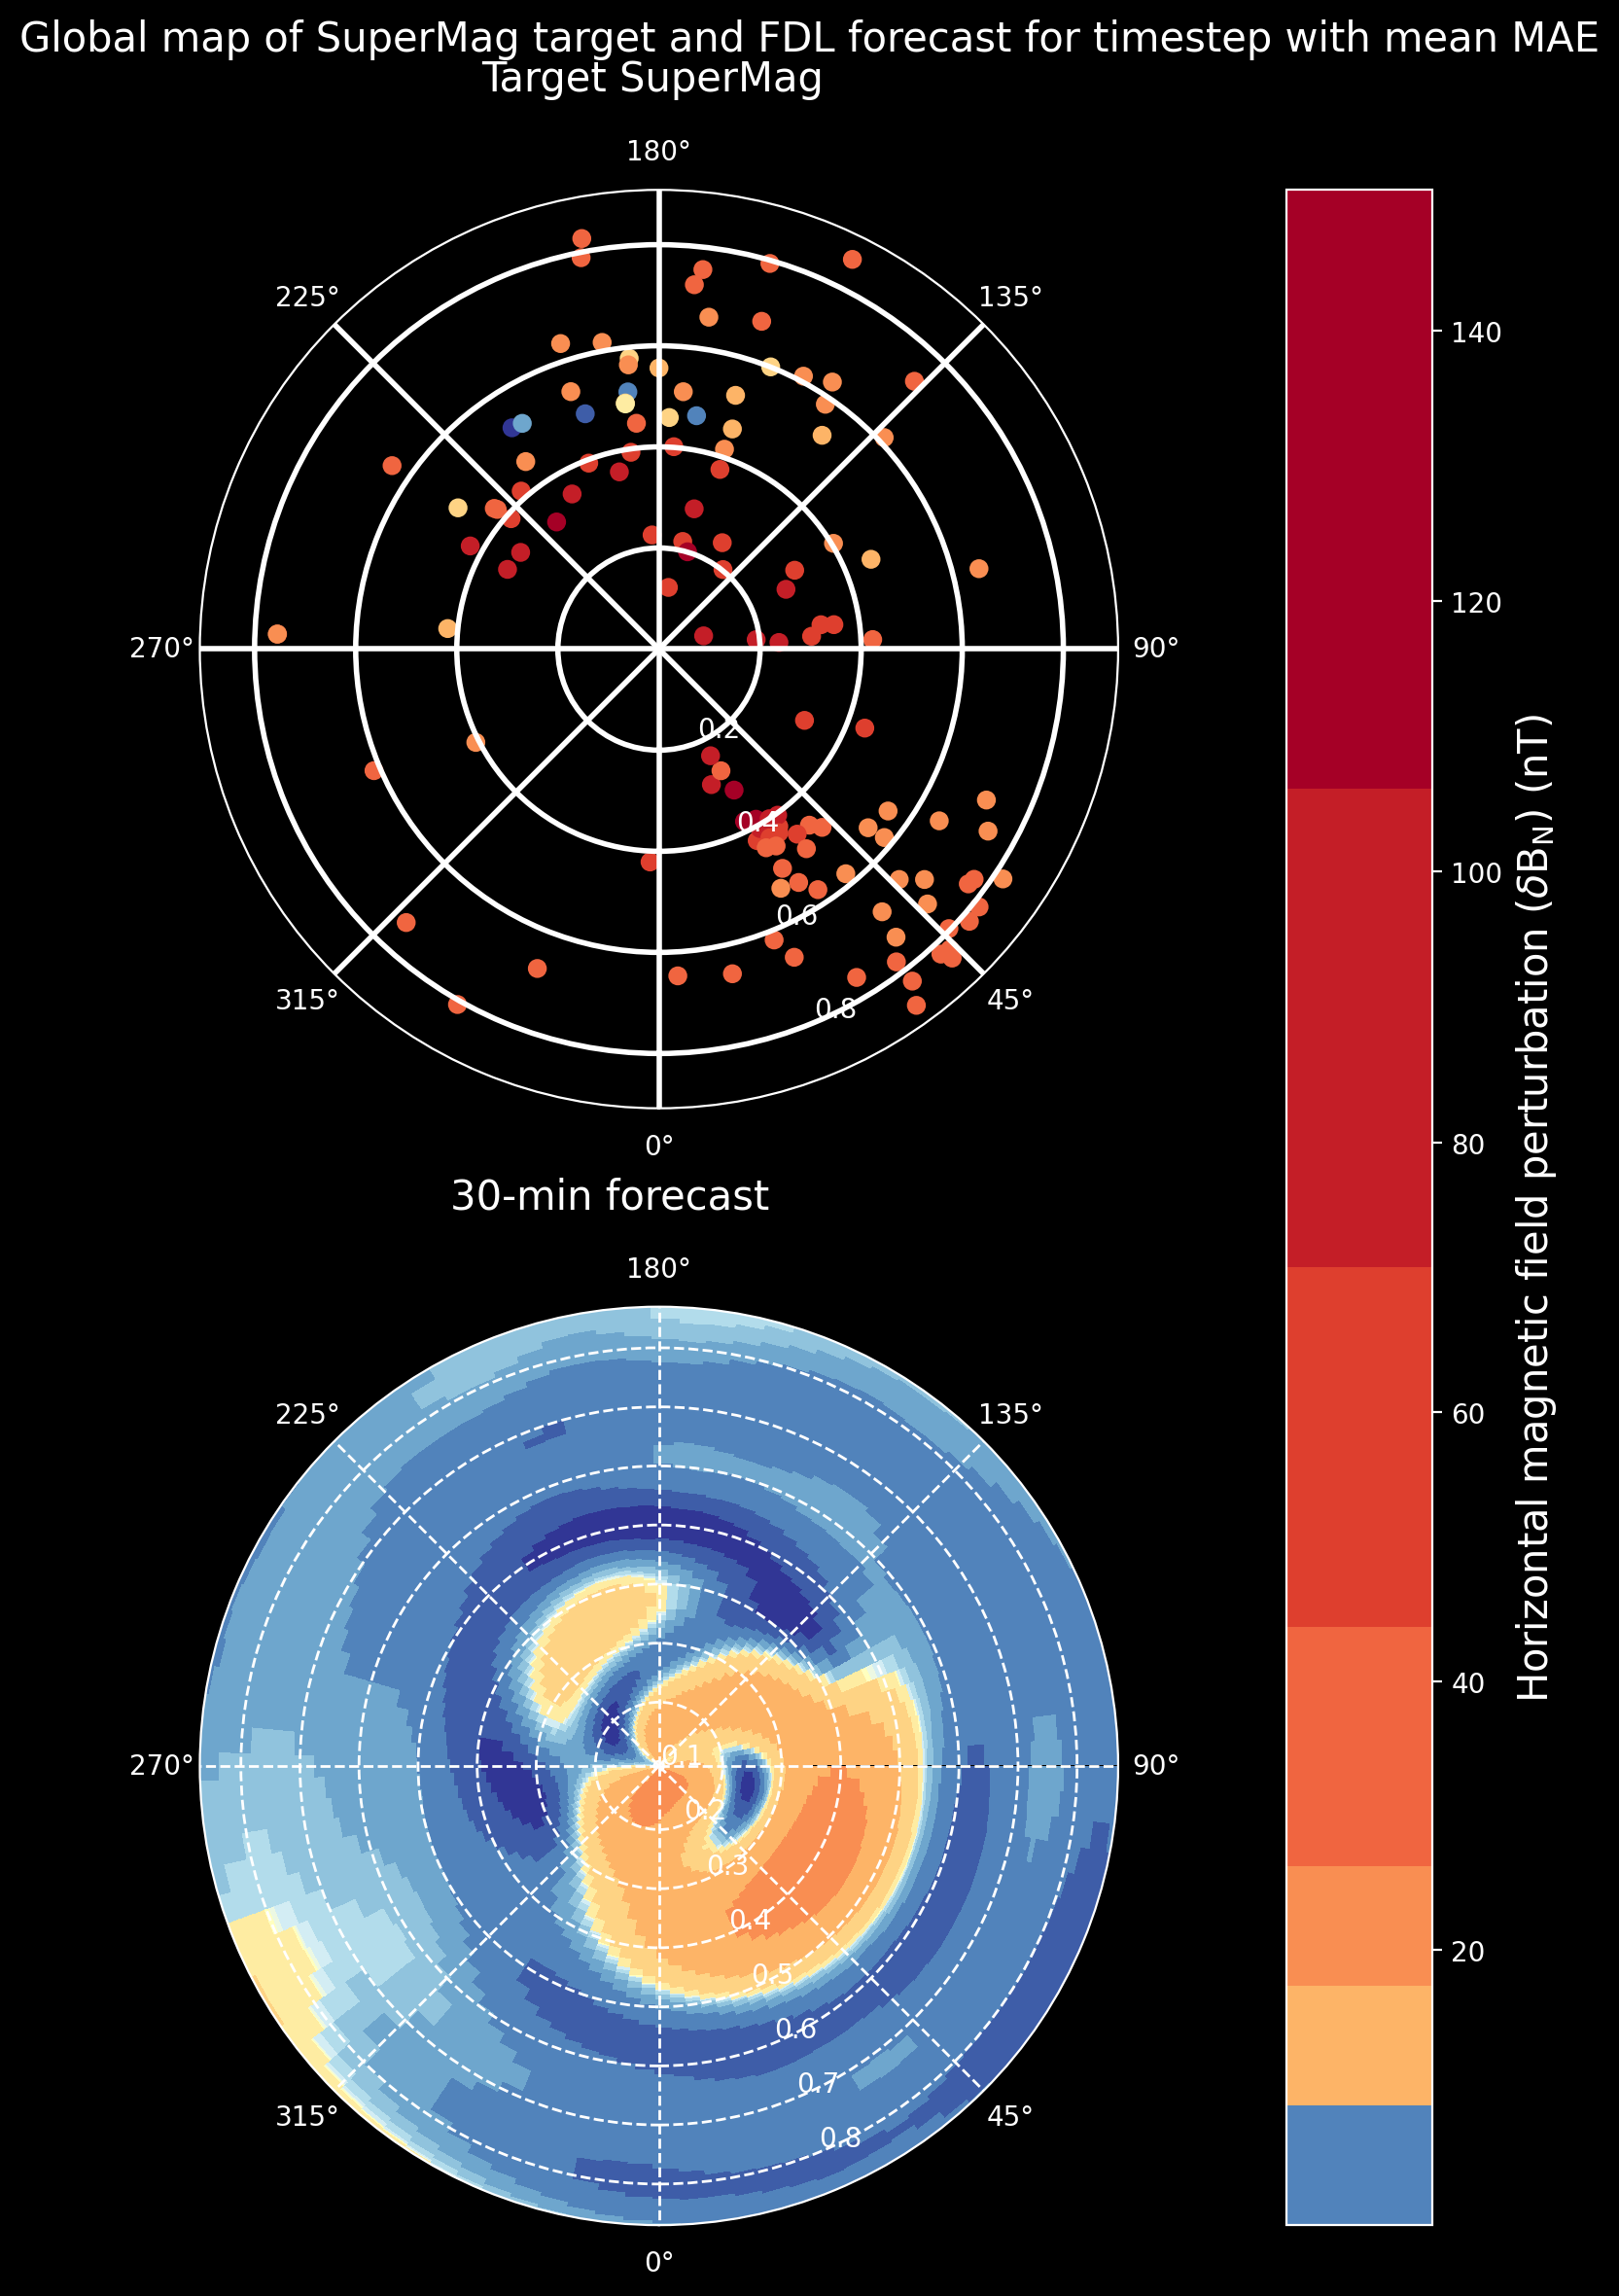

In [100]:
ind_select = 1
suptitle = {0: "min MAE", 1:"mean MAE", 2: "max MAE"}
Columns_for_3_cases(tmp_bh,dbh_targ_2011,storm_dataset,_mlt_2011,_colat_2011,
                    MLT_sup_all_2011['dbe'][start_2011:end_2011+1],Mcolat_sup_all_2011['dbe'][start_2011:end_2011+1],tipleinds_2011[ind_select],
                    label = r'Horizontal magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)',
                   minp=2)
plt.suptitle(f"Global map of SuperMag target and FDL forecast for timestep with {suptitle[ind_select]}",fontsize=15)
plt.tight_layout()
plt.savefig("../Paper/figures/storm_2011_meanMAE_dbh.pdf",dpi=300)

/tmp/ipykernel_26051/3300467944.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


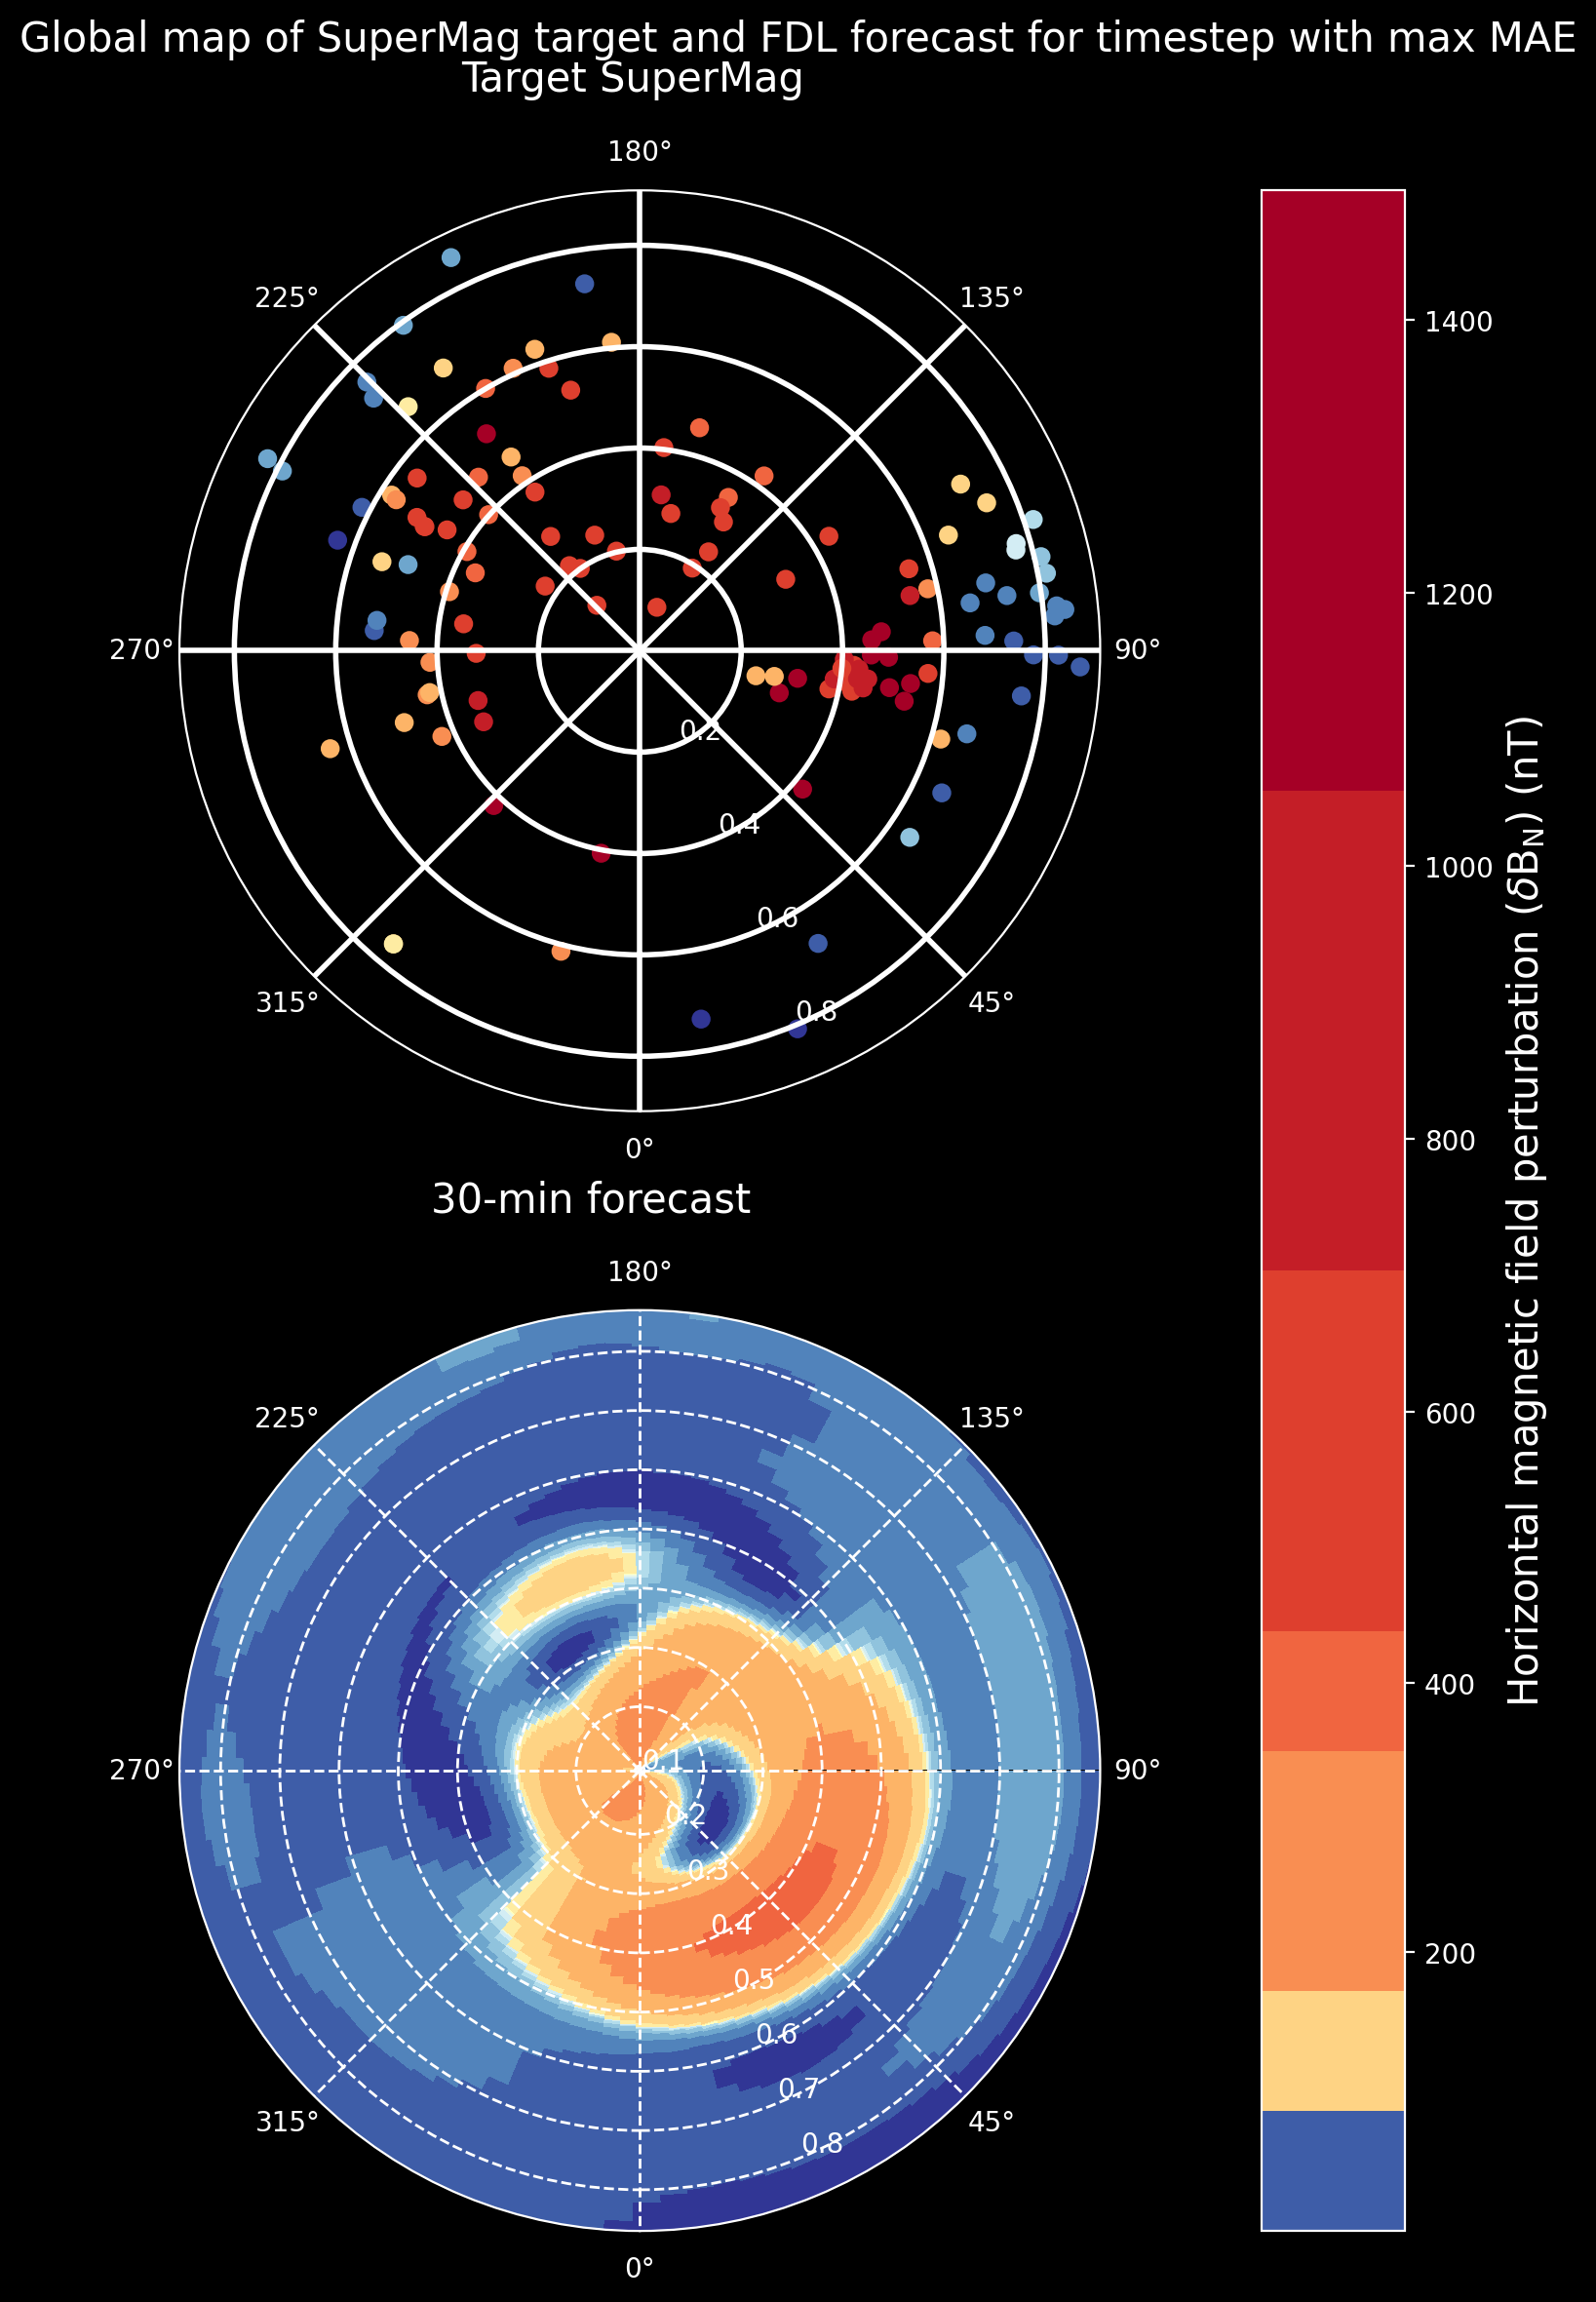

In [101]:
ind_select = 2
suptitle = {0: "min MAE", 1:"mean MAE", 2: "max MAE"}
Columns_for_3_cases(tmp_bh,dbh_targ_2011,storm_dataset,_mlt_2011,_colat_2011,
                    MLT_sup_all_2011['dbe'][start_2011:end_2011+1],Mcolat_sup_all_2011['dbe'][start_2011:end_2011+1],tipleinds_2011[ind_select],
                    label = r'Horizontal magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)',
                   minp=2)
plt.suptitle(f"Global map of SuperMag target and FDL forecast for timestep with {suptitle[ind_select]}",fontsize=15)
plt.tight_layout()
plt.savefig("../Paper/figures/storm_2011_maxMAE_dbh.pdf",dpi=300)

#### 2015 storm

In [62]:
fdl_on_grid_gif_2015['dbe'].shape,dbh_targ_2015.shape,end-start

((360, 100, 36670), (3361, 175), 3360)

In [90]:
tmp_bh = np.sqrt(fdl_on_grid_gif_2015['dbe'][...,start:end+1]**2+fdl_on_grid_gif_2015['dbn'][...,start:end+1]**2)

/tmp/ipykernel_26051/3300467944.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


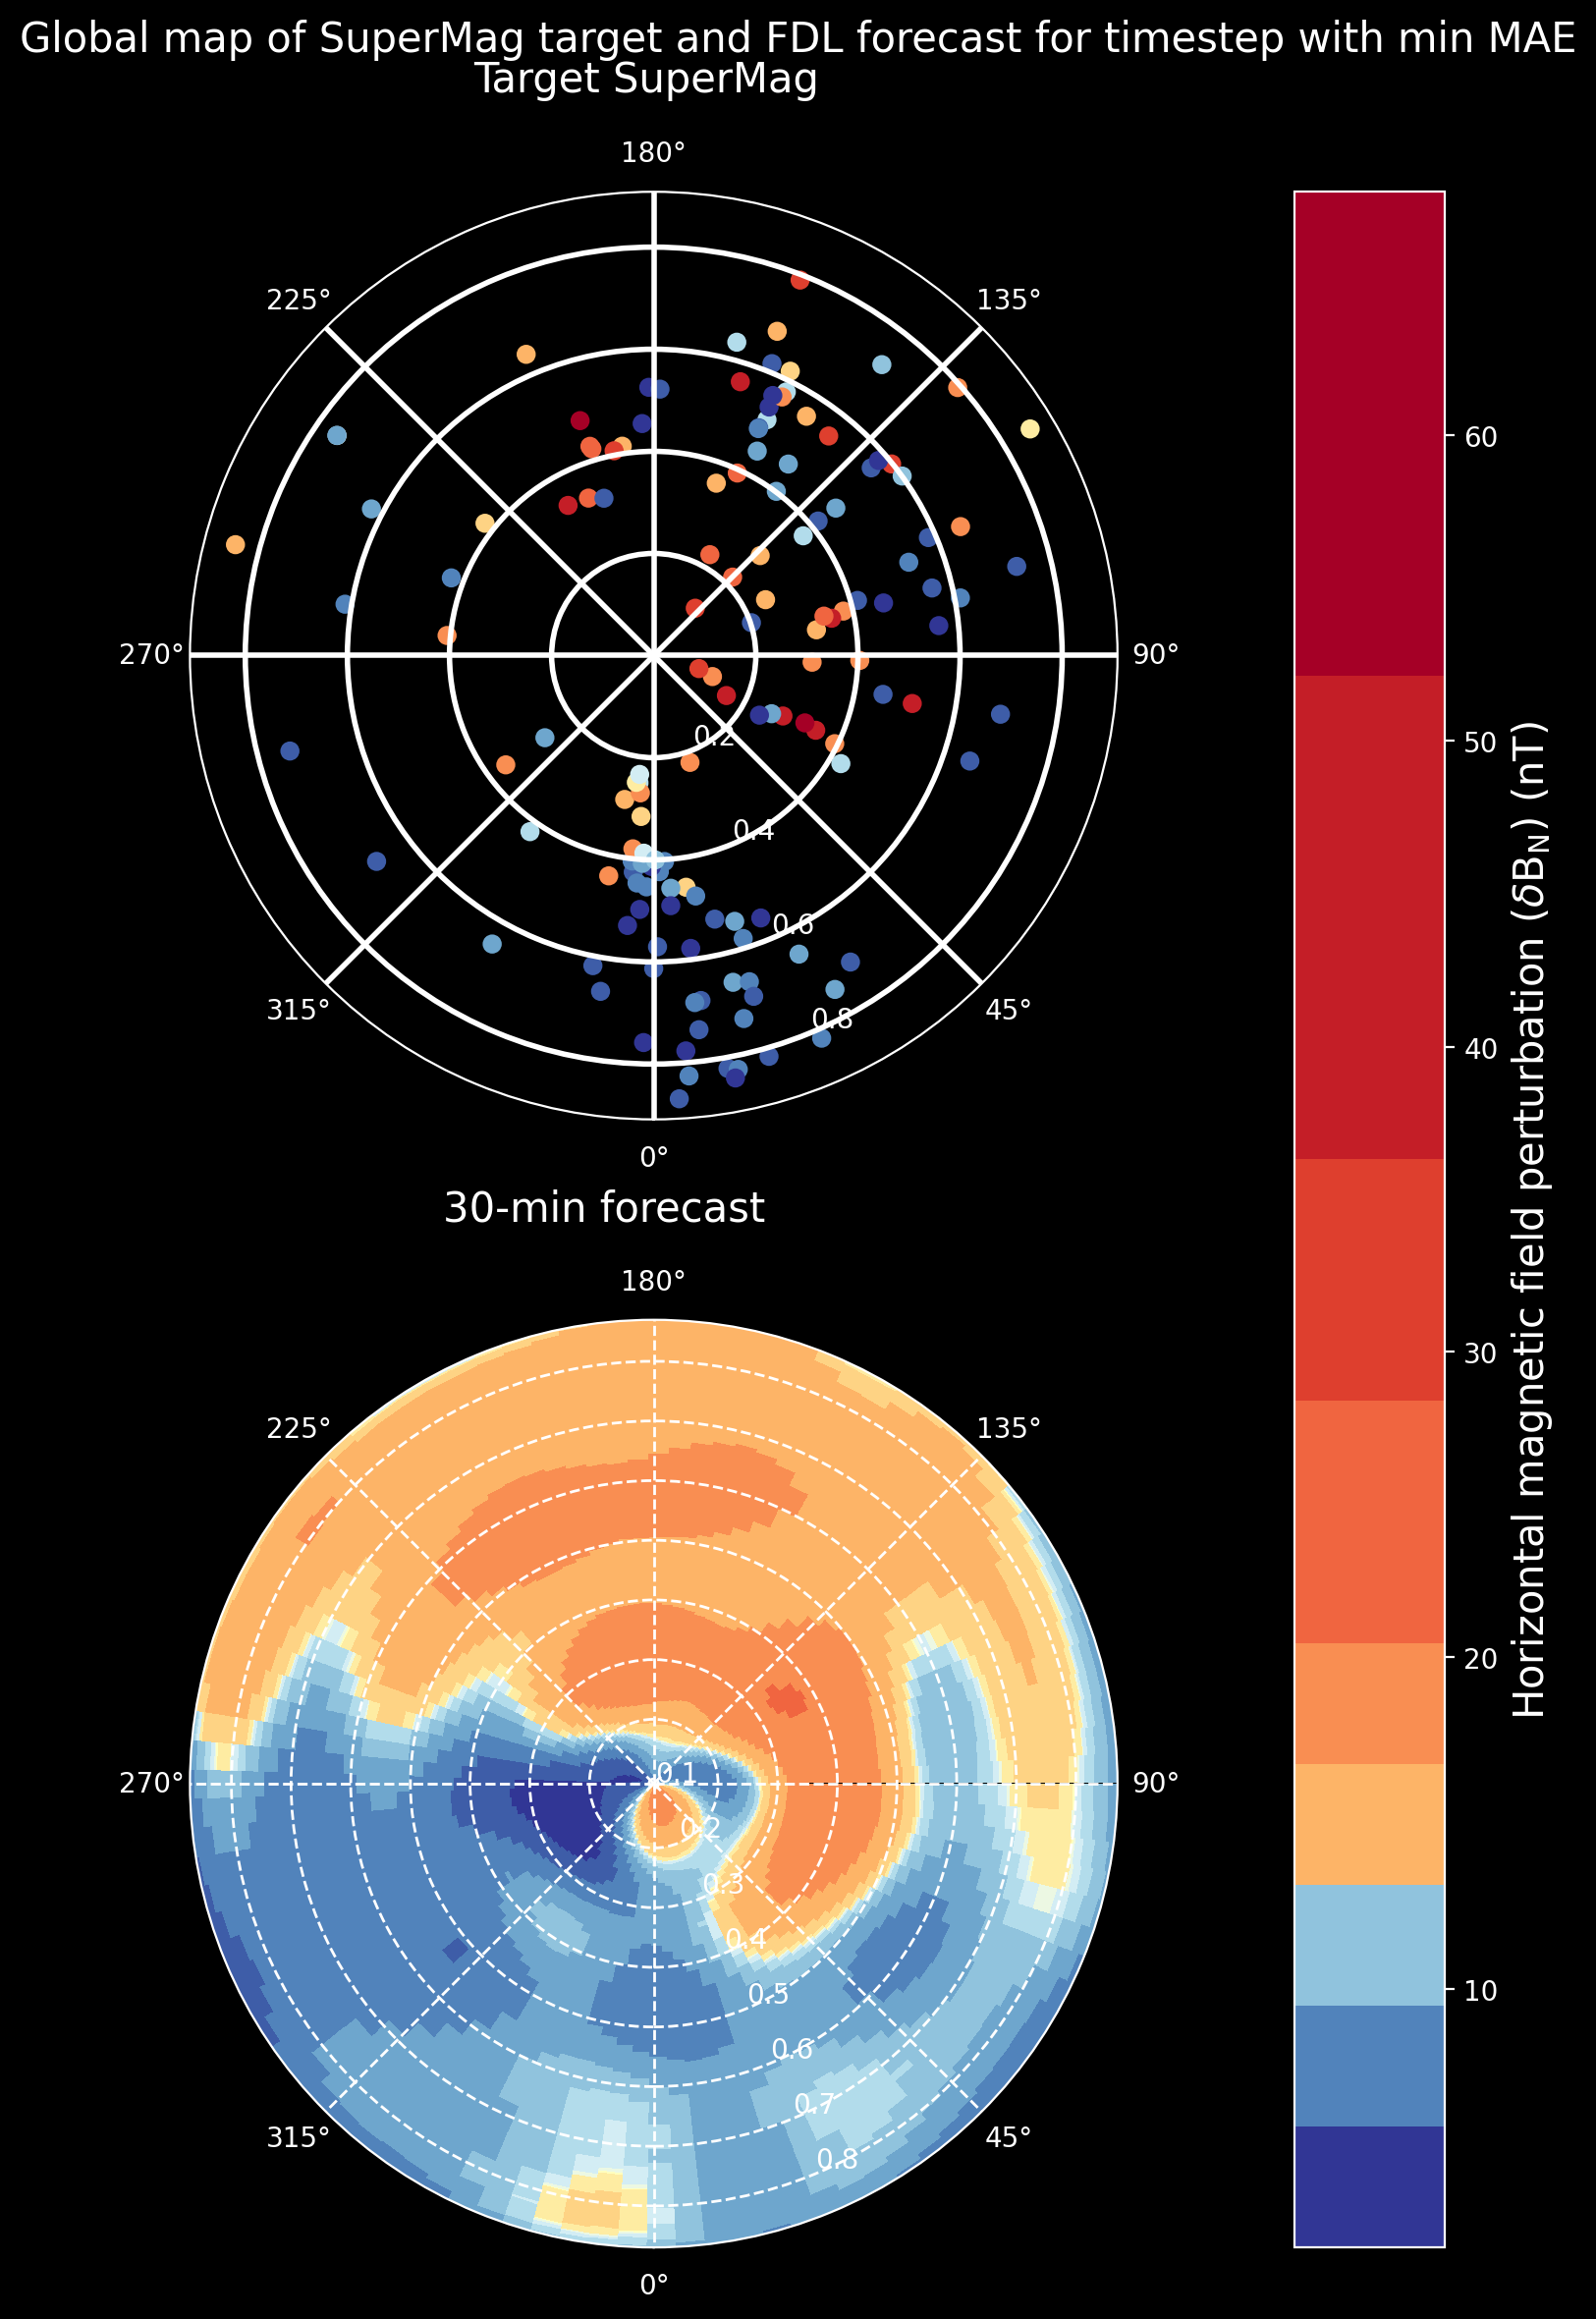

In [95]:
ind_select = 0
suptitle = {0: "min MAE", 1:"mean MAE", 2: "max MAE"}
Columns_for_3_cases(tmp_bh,dbh_targ_2015,wiemer_ds,_mlt_2015,_colat_2015,
                    MLT_sup_all_2015['dbe'][start:end+1],Mcolat_sup_all_2015['dbe'][start:end+1],tipleinds_2015[ind_select],
                    label = r'Horizontal magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)',
                   minp=15,maxp=99)
plt.suptitle(f"Global map of SuperMag target and FDL forecast for timestep with {suptitle[ind_select]}",fontsize=15)
plt.tight_layout()
plt.savefig("../Paper/figures/storm_2015_minMAE_dbh.pdf",dpi=300)

/tmp/ipykernel_26051/3300467944.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


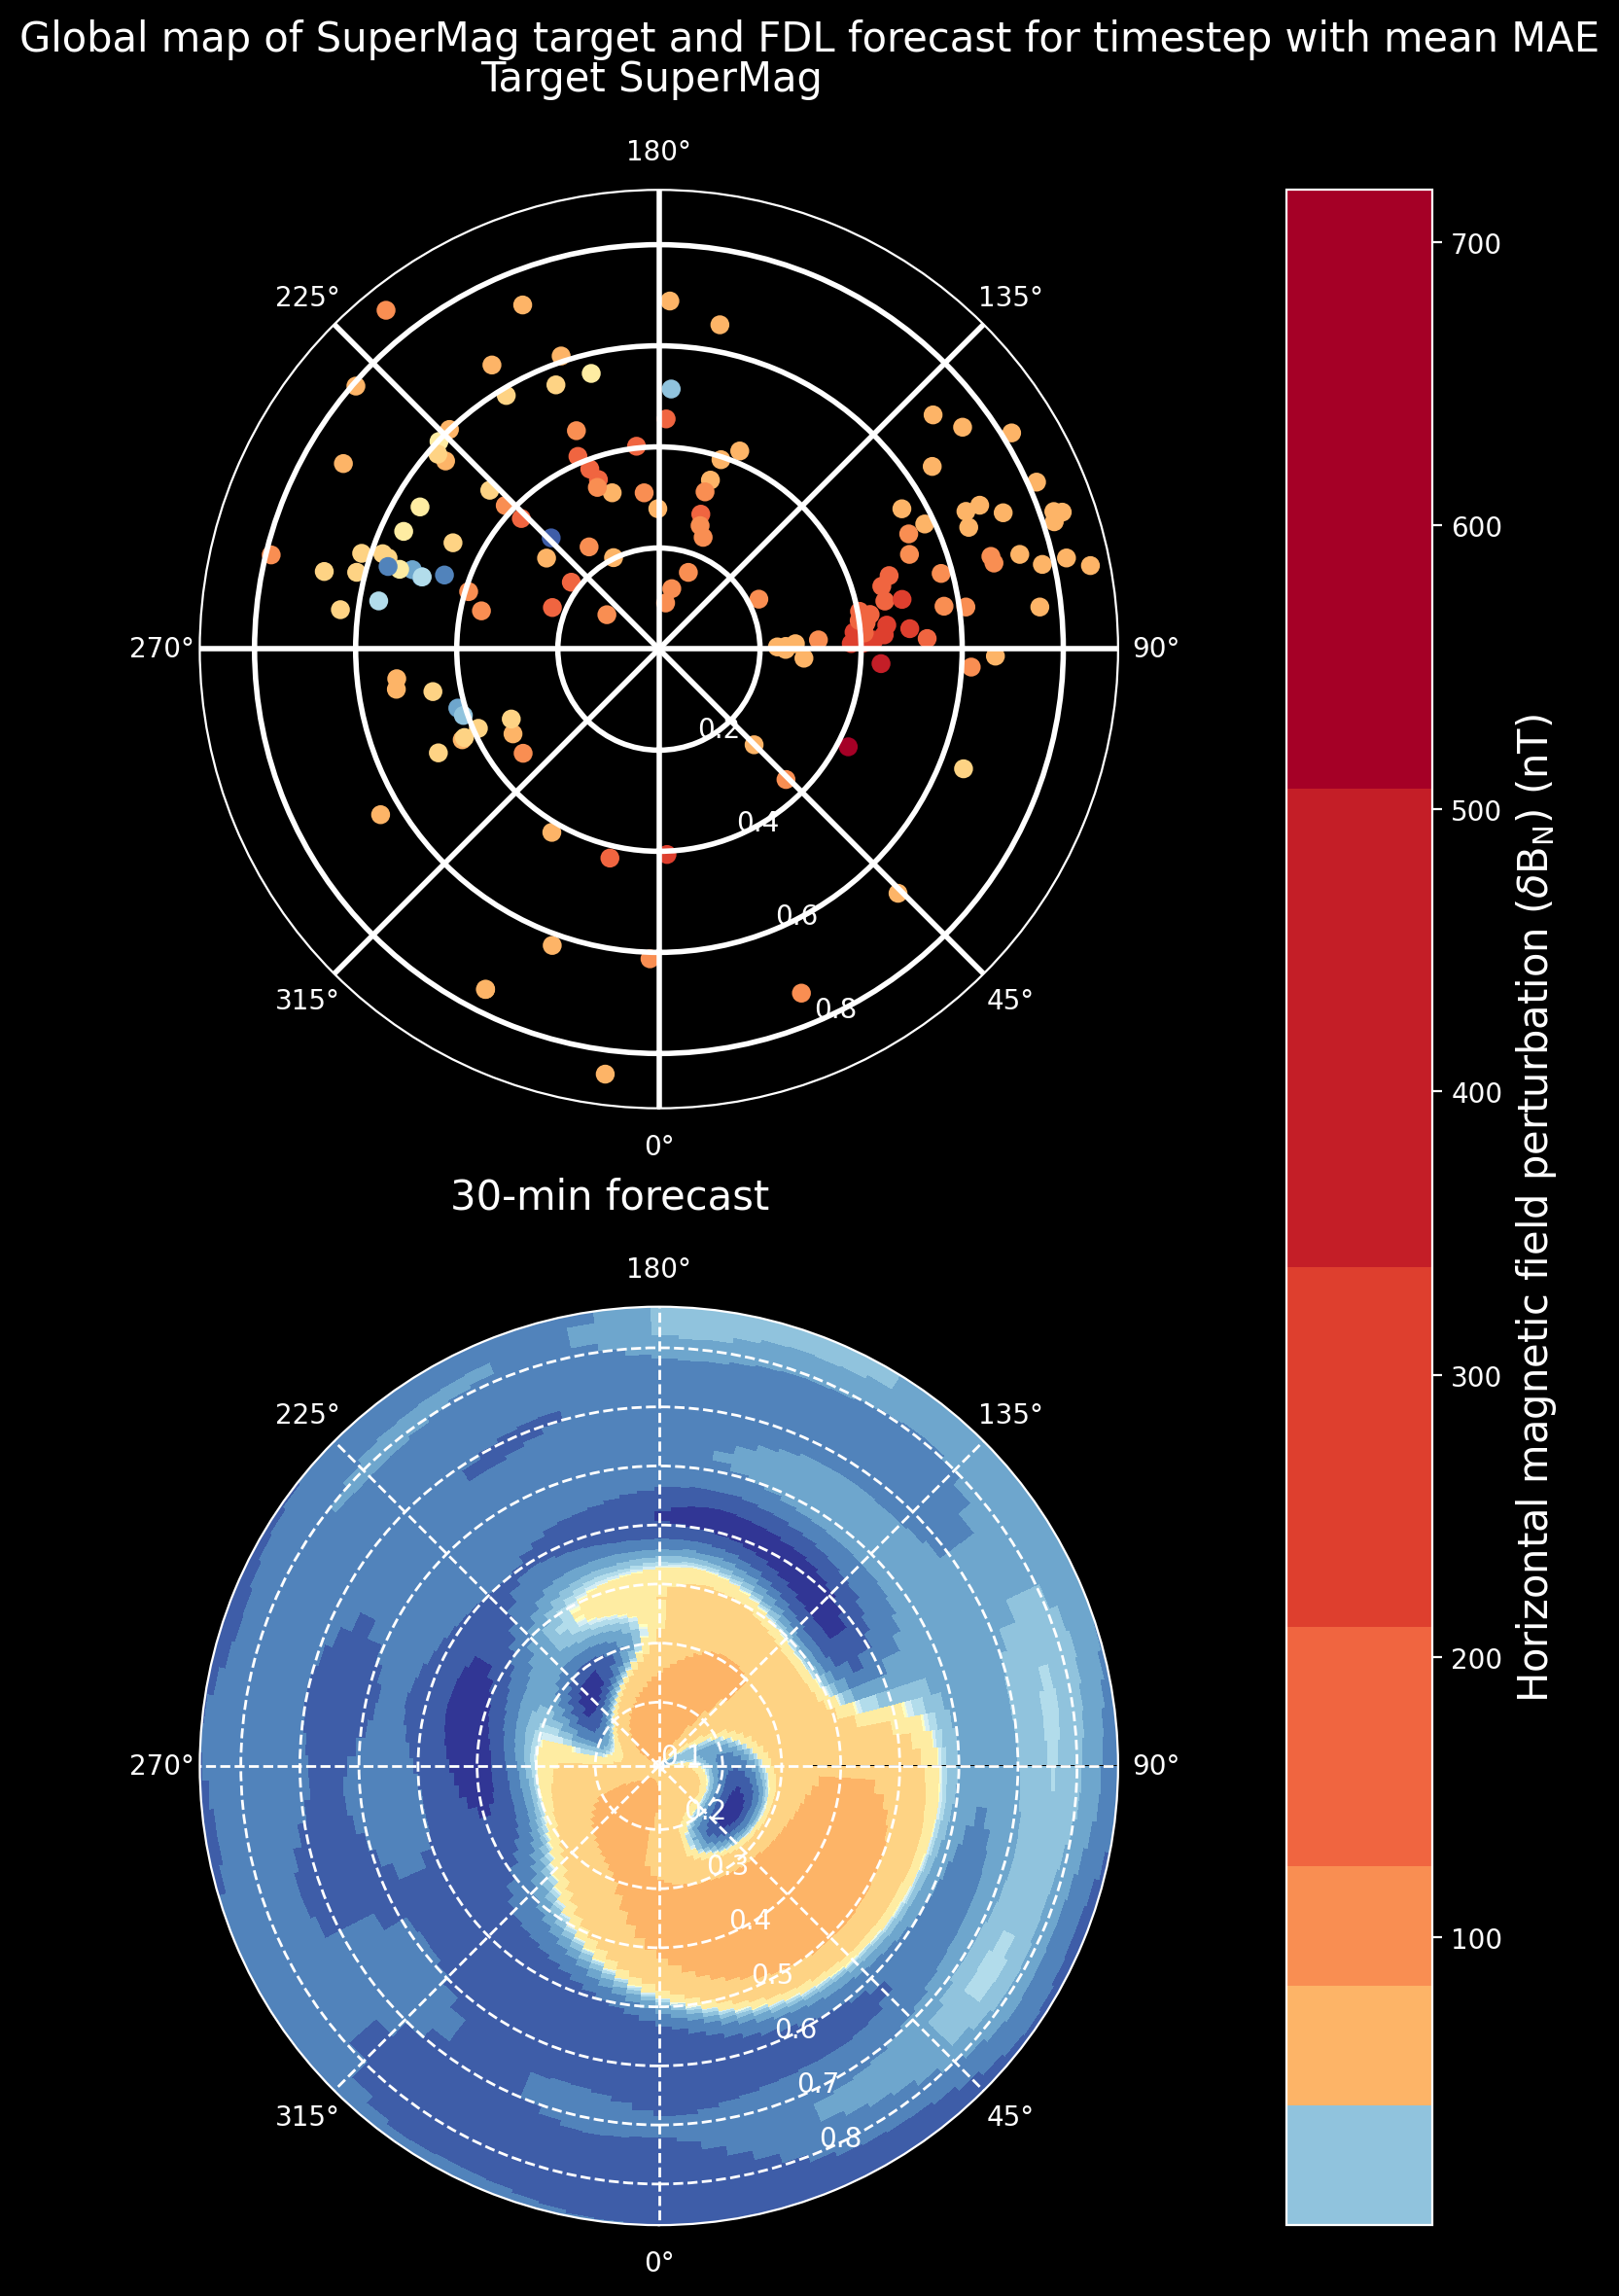

In [96]:
ind_select = 1
suptitle = {0: "min MAE", 1:"mean MAE", 2: "max MAE"}
Columns_for_3_cases(tmp_bh,dbh_targ_2015,wiemer_ds,_mlt_2015,_colat_2015,
                    MLT_sup_all_2015['dbe'][start:end+1],Mcolat_sup_all_2015['dbe'][start:end+1],tipleinds_2015[ind_select],
                    label = r'Horizontal magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)',
                   minp=2)
plt.suptitle(f"Global map of SuperMag target and FDL forecast for timestep with {suptitle[ind_select]}",fontsize=15)
plt.tight_layout()
plt.savefig("../Paper/figures/storm_2015_meanMAE_dbh.pdf",dpi=300)

/tmp/ipykernel_26051/3300467944.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


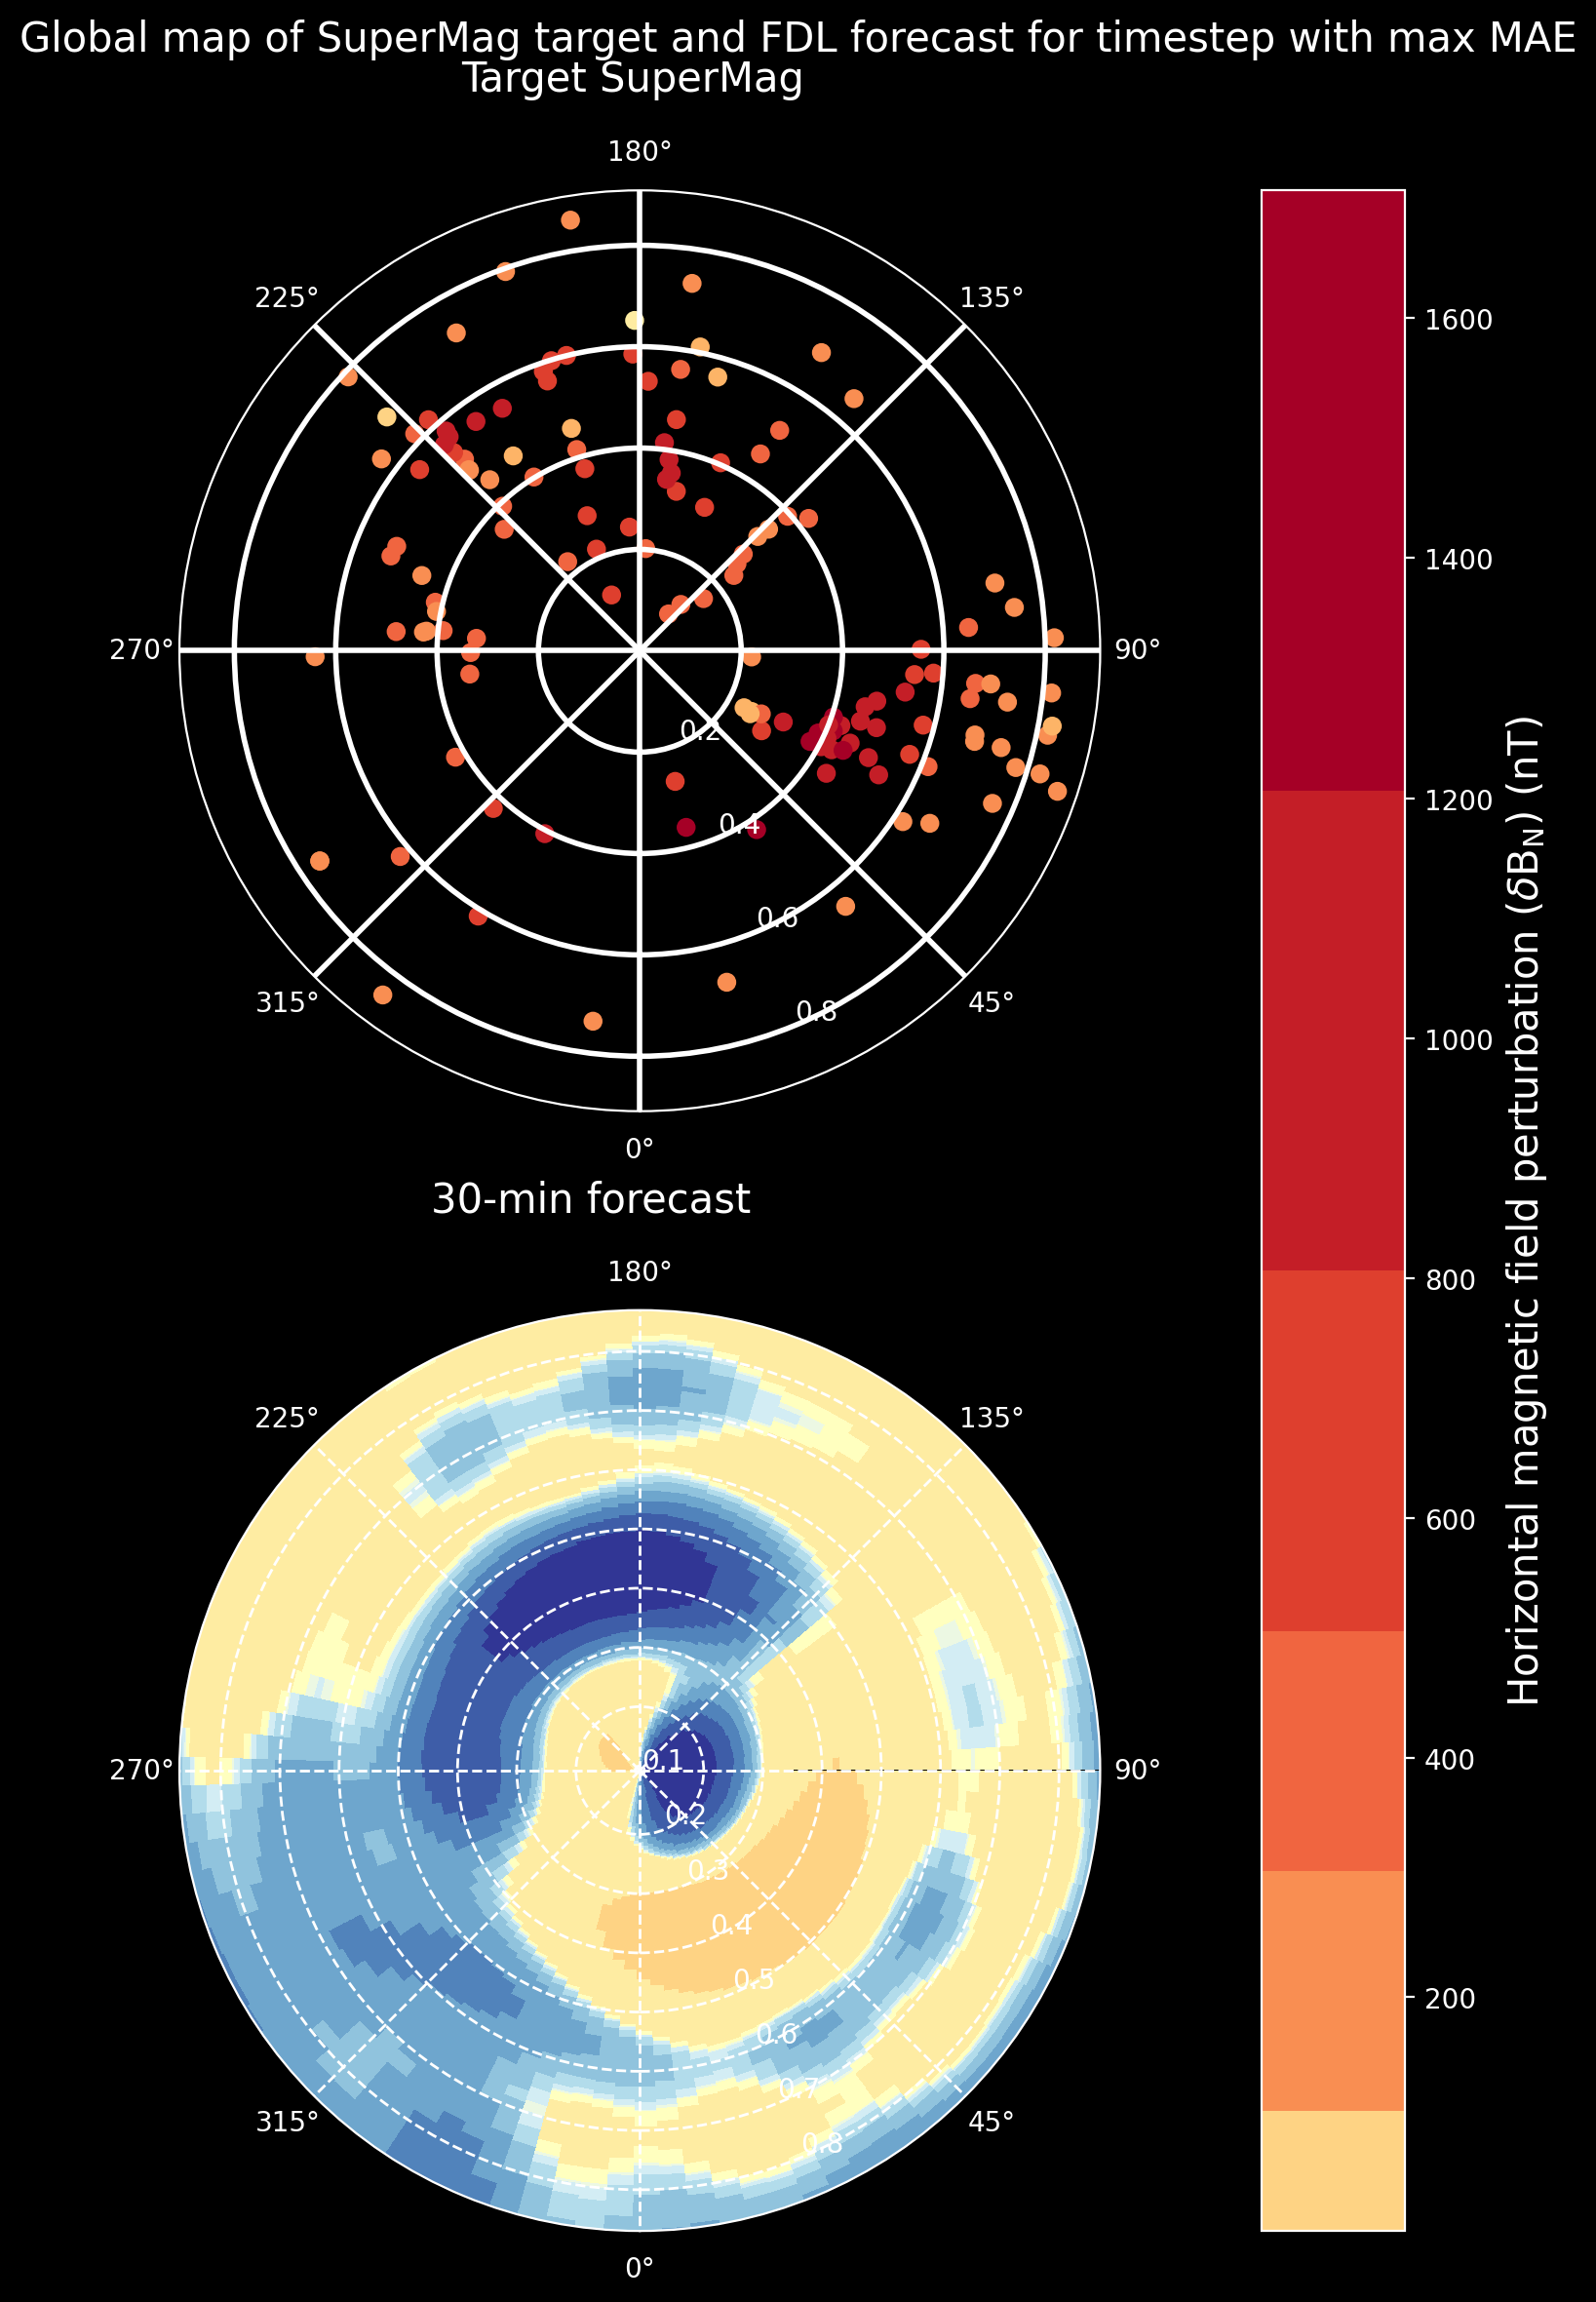

In [97]:
ind_select = 2
suptitle = {0: "min MAE", 1:"mean MAE", 2: "max MAE"}
Columns_for_3_cases(tmp_bh,dbh_targ_2015,wiemer_ds,_mlt_2015,_colat_2015,
                    MLT_sup_all_2015['dbe'][start:end+1],Mcolat_sup_all_2015['dbe'][start:end+1],tipleinds_2015[ind_select],
                    label = r'Horizontal magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)',
                   minp=2)
plt.suptitle(f"Global map of SuperMag target and FDL forecast for timestep with {suptitle[ind_select]}",fontsize=15)
plt.tight_layout()
plt.savefig("../Paper/figures/storm_2015_maxMAE_dbh.pdf",dpi=300)

### Full video

In [102]:
from celluloid import Camera

In [103]:
plt.style.use("dark_background")

In [124]:
def Save_video(_mlt,_colat,dataset,fdl_on_grid_gif,MLT,Mcolat,Targets,savepath,start=None,end=None,k = 'dbn'):
    if k=='dbn':
        caxlabel = r'Northward magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)'
    elif k=='dbe':
        caxlabel = r'Eastward magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)'
    elif k=='dbh':
        caxlabel = r'Horizontal magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)'
    else:
        raise ValueError("Perturbation can only be dbn, dbe or dbh.")
        
    fig1 = plt.figure(figsize=(12,8),dpi=200)
    gs = fig1.add_gridspec(8, 2)
    camera = Camera(fig1)
    theta = _mlt 
    phi = _colat 
    cmap=cm.get_cmap("RdYlBu_r",17)
    ax1 = fig1.add_subplot(gs[:-1,0], projection='polar')
    ax1.set_theta_offset(-np.pi/2)
    ax2 = fig1.add_subplot(gs[:-1,1], projection='polar')
    ax2.set_theta_offset(-np.pi/2)
    cax = fig1.add_subplot(gs[-1,:])
    if (start is not None) and (end is not None):
        dates = dataset.dates[start:end+1]
    for time_ind,d in enumerate(dates[::10]):
        cax.cla()
        dt = pd.to_datetime(d,unit='s')

        dbH2 = fdl_on_grid_gif[...,time_ind] #np.sqrt(np.square(Targets['dbe'][:,:,start:end+1])+np.square(Targets['dbn'][:,:,start:end+1]))

#         maxval = np.nanpercentile(dbH2,95)
#         minval = np.nanpercentile(dbH2,5)
        
        maxval=np.max([np.nanmax(fdl_on_grid_gif[...,time_ind]),np.nanmax(Targets[time_ind])])
        minval=np.min([np.nanmin(fdl_on_grid_gif[...,time_ind]),np.nanmin(Targets[time_ind])])
        midval=np.min([np.nanmean(fdl_on_grid_gif[...,time_ind]),np.nanmean(Targets[time_ind])])
        norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=midval, s1=3, s2=3)
        
#         print(fdl_on_grid_gif[...,time_ind].shape,theta.shape,phi.shape)
        dbH = fdl_on_grid_gif[...,time_ind] #np.sqrt(np.square(fdl_on_weimergrid_gif['dbe'][:,:,start:end+1][...,time_ind])+np.square(fdl_on_weimergrid_gif['dbn'][:,:,start:end+1][...,time_ind]))
        c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)  
        ax2.set_ylim([np.nanmin(Mcolat[time_ind]),np.nanmax(Mcolat[time_ind])])
        ax2.grid(linewidth=1,color='white',linestyle='--')
        ax2.text(3.5,1.1,f"FDL 30-min forecast",fontsize=15)

        dbH = Targets[time_ind] #np.sqrt(np.square(Targets['dbe'][start:end+1][time_ind])+np.square(Targets['dbn'][start:end+1][time_ind]))
        c3=ax1.scatter(MLT[time_ind].ravel(),Mcolat[time_ind].ravel(), c=dbH.ravel(),cmap=cmap,norm=norm,s=36)
        ax1.text(3.45,1.16,f"Target SuperMag",fontsize=15)
        ax1.grid(linewidth=2,color='white')
        fig1.colorbar(c3, cax=cax,orientation='horizontal')
        cax.set_xlabel(caxlabel,fontsize=15)
        camera.snap()
    animation = camera.animate()
    animation.save(f'{savepath}',bitrate=-1)


In [117]:
tmp_bh = np.sqrt(fdl_on_grid_gif_2011['dbe'][...,start_2011:end_2011+1]**2+fdl_on_grid_gif_2011['dbn'][...,start_2011:end_2011+1]**2)

In [118]:
dbh_targ_2011.shape,tmp_bh.shape,MLT_sup_all_2011['dbe'][start_2011:end_2011+1].shape

((2581, 175), (360, 100, 2581), (2581, 175))

/tmp/ipykernel_26051/4194893828.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


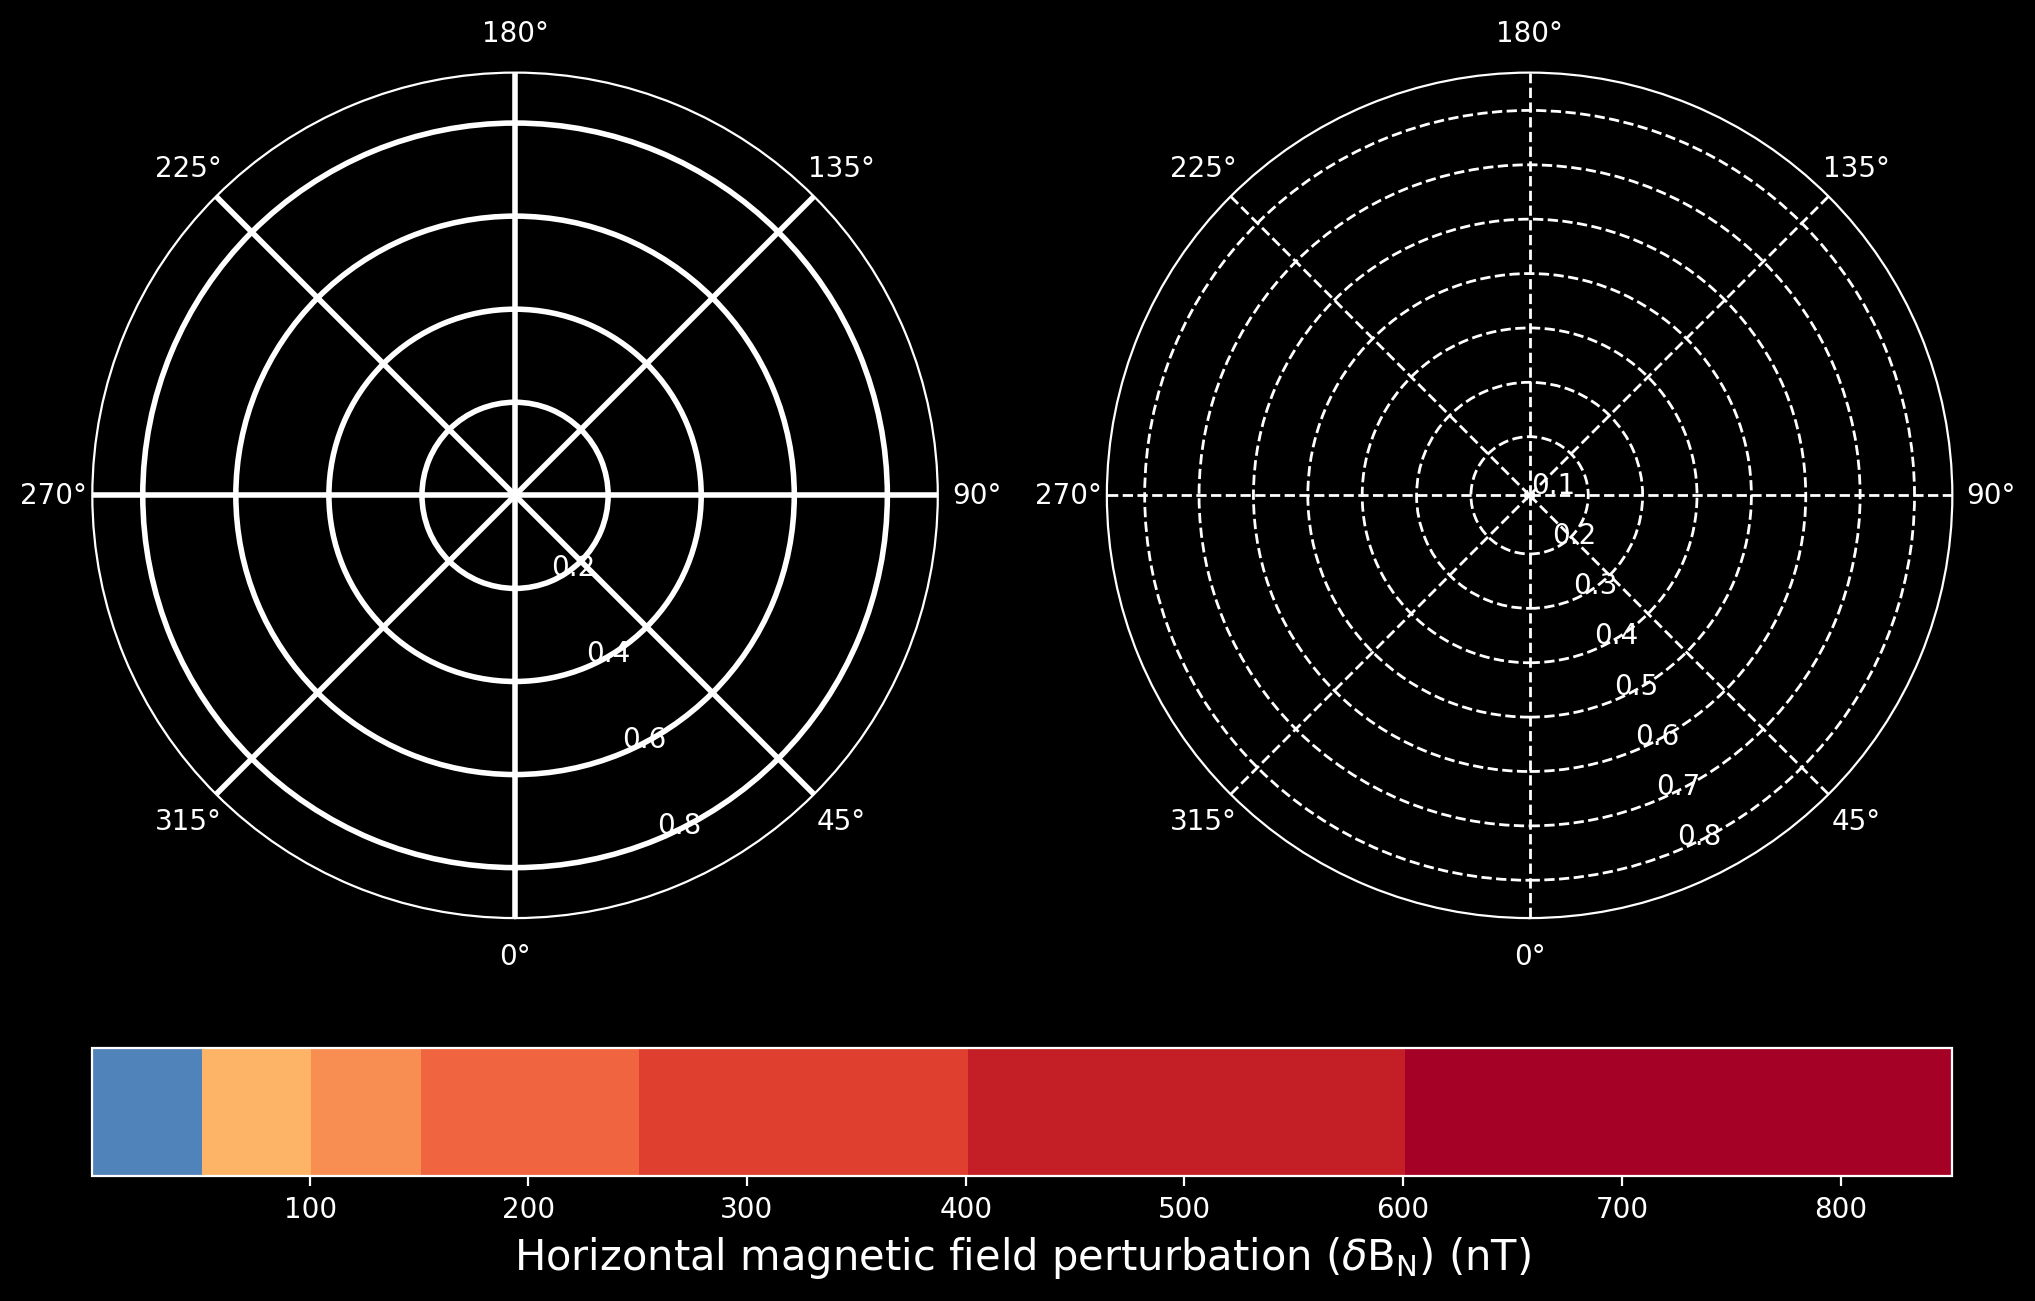

In [119]:
Save_video(_mlt_2011,_colat_2011,storm_dataset,tmp_bh,
           MLT_sup_all_2011['dbe'][start_2011:end_2011+1],Mcolat_sup_all_2011['dbe'][start_2011:end_2011+1],
           dbh_targ_2011,savepath="../Paper/figures/storm_2011_dbh_video.mp4",k = 'dbh')

/tmp/ipykernel_26051/4194893828.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)
/tmp/ipykernel_26051/4194893828.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


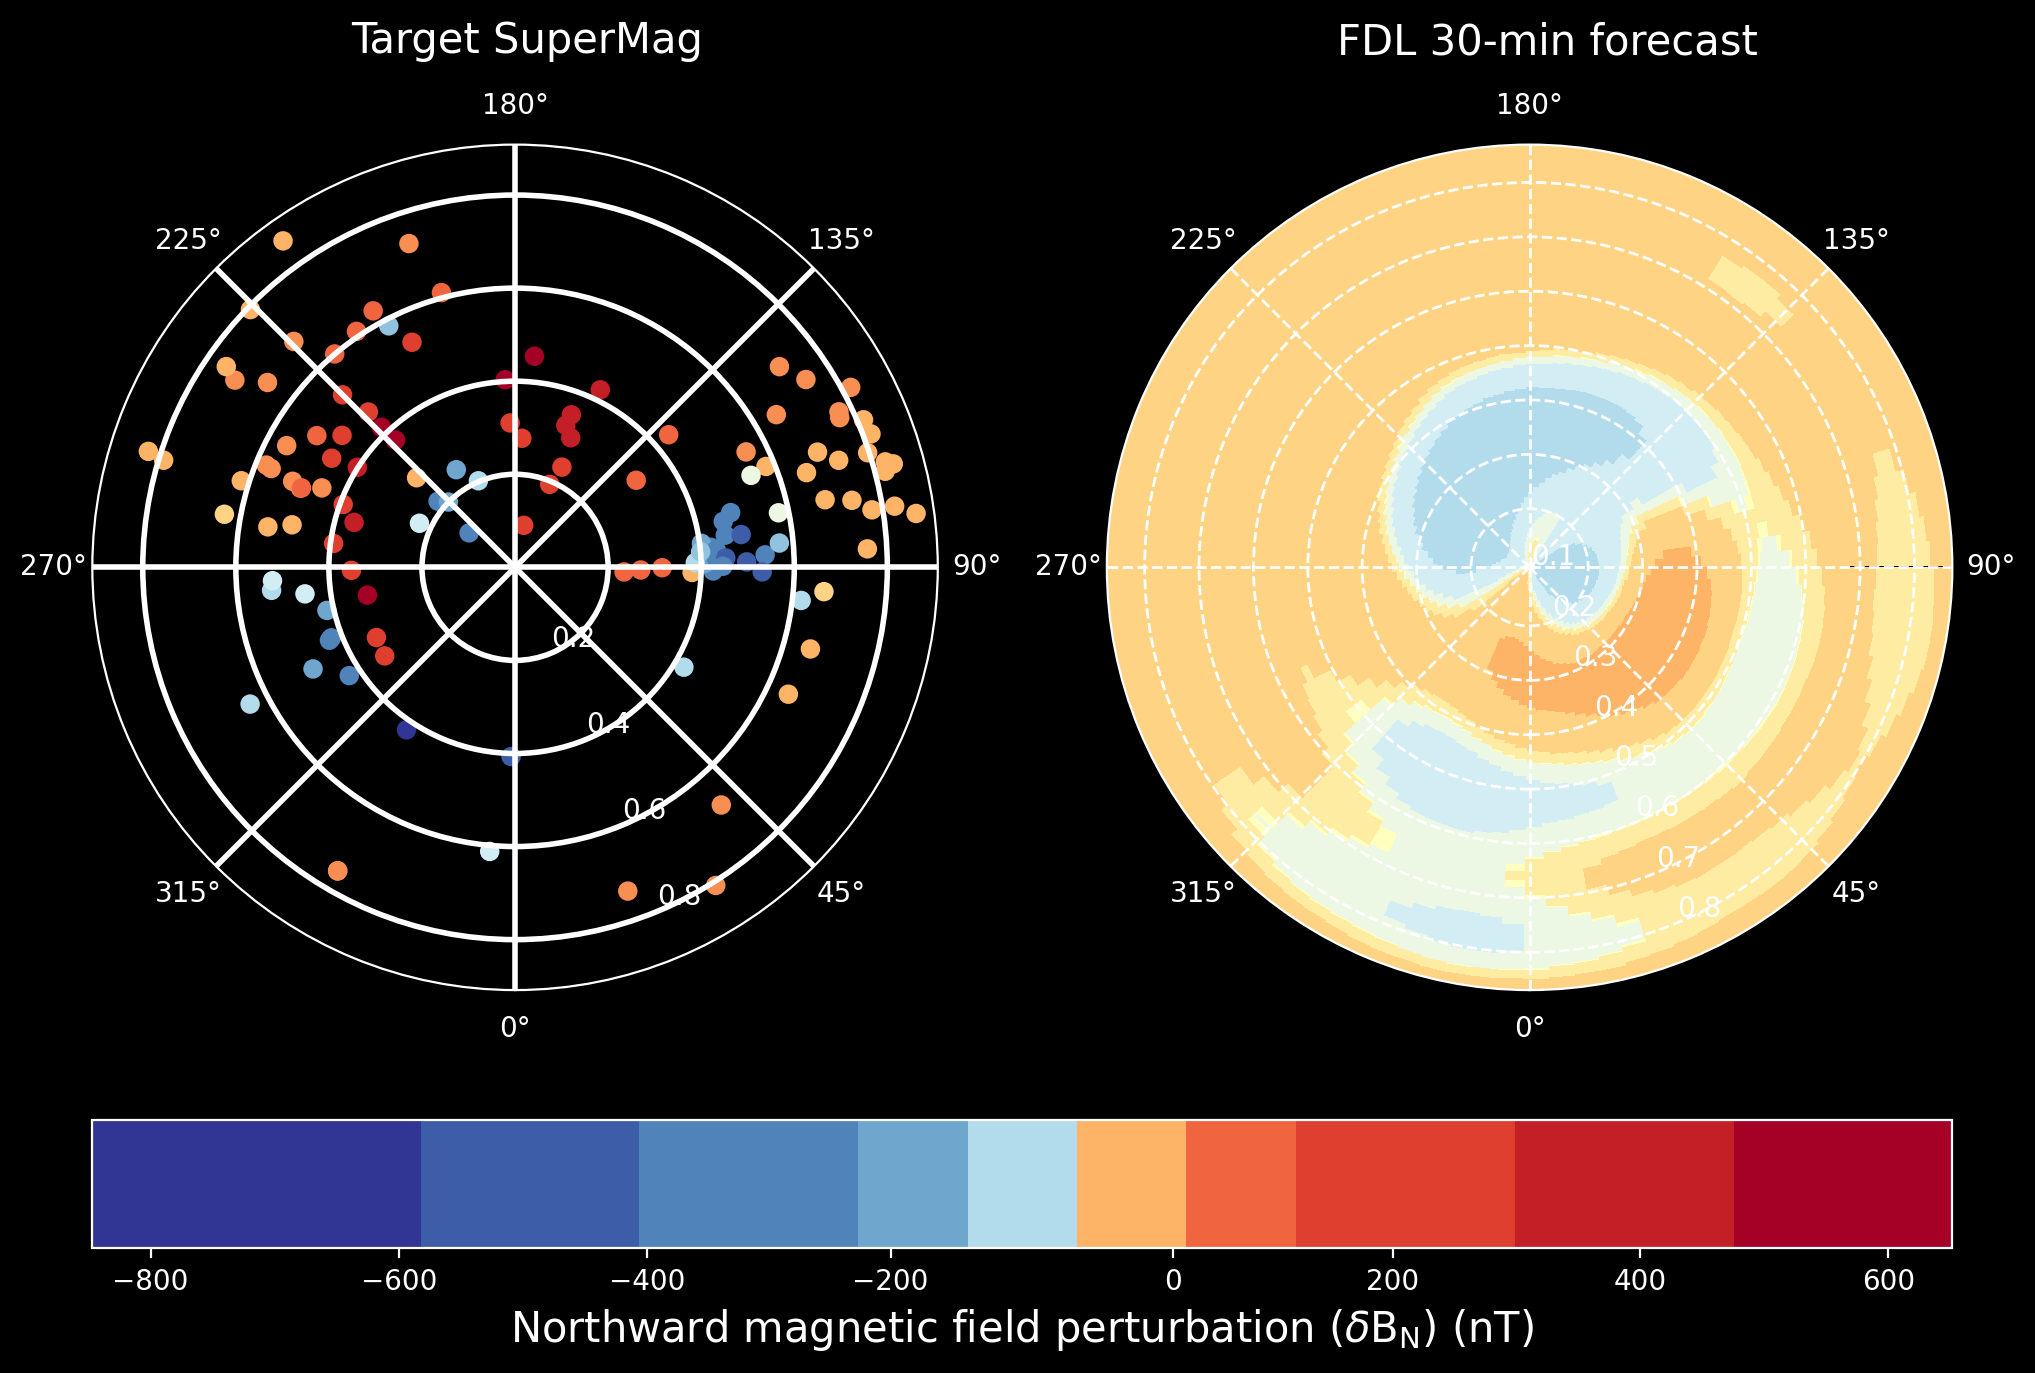

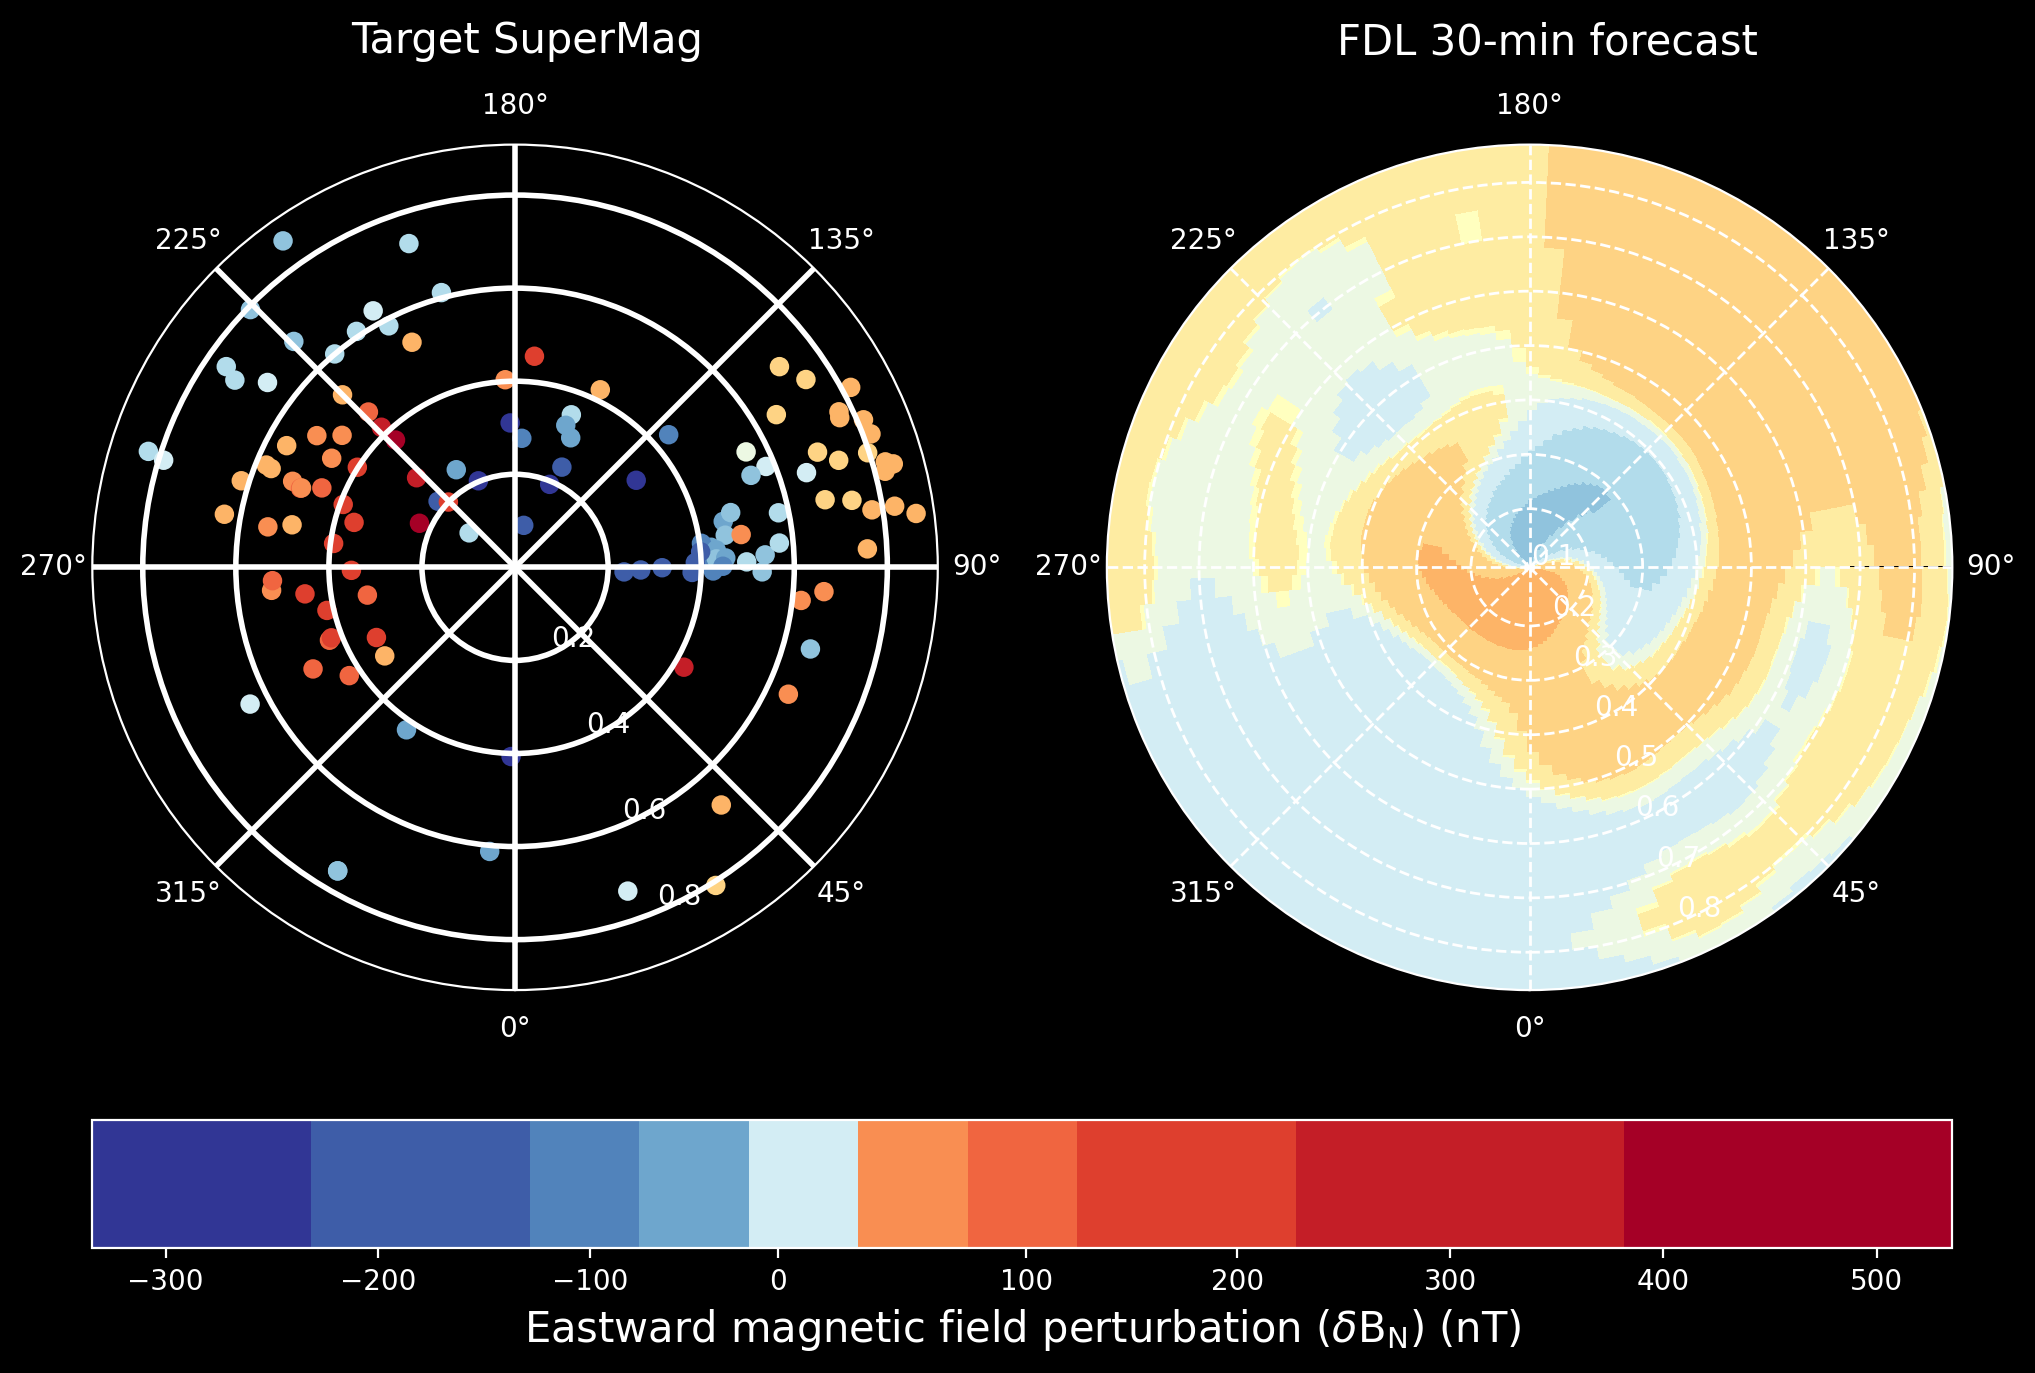

In [120]:
Save_video(_mlt_2011,_colat_2011,storm_dataset,fdl_on_grid_gif_2011['dbn'],
               MLT_sup_all_2011['dbn'],Mcolat_sup_all_2011['dbn'],Targets_2011['dbn'],
               savepath="../Paper/figures/storm_2011_dbn_video.mp4",k = 'dbn')
Save_video(_mlt_2011,_colat_2011,storm_dataset,fdl_on_grid_gif_2011['dbe'],
               MLT_sup_all_2011['dbe'],Mcolat_sup_all_2011['dbe'],Targets_2011['dbe'],
               savepath="../Paper/figures/storm_2011_dbe_video.mp4",k = 'dbe')

In [121]:
tmp_bh = np.sqrt(fdl_on_grid_gif_2015['dbe'][...,start:end+1]**2+fdl_on_grid_gif_2015['dbn'][...,start:end+1]**2)

In [122]:
tmp_bh.shape,Targets_2015['dbn'][start:end+1].shape,dbh_targ_2015.shape

((360, 100, 3361), (3361, 175), (3361, 175))

/tmp/ipykernel_26051/1855587840.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)
/tmp/ipykernel_26051/1855587840.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)
/tmp/ipykernel_26051/1855587840.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of t

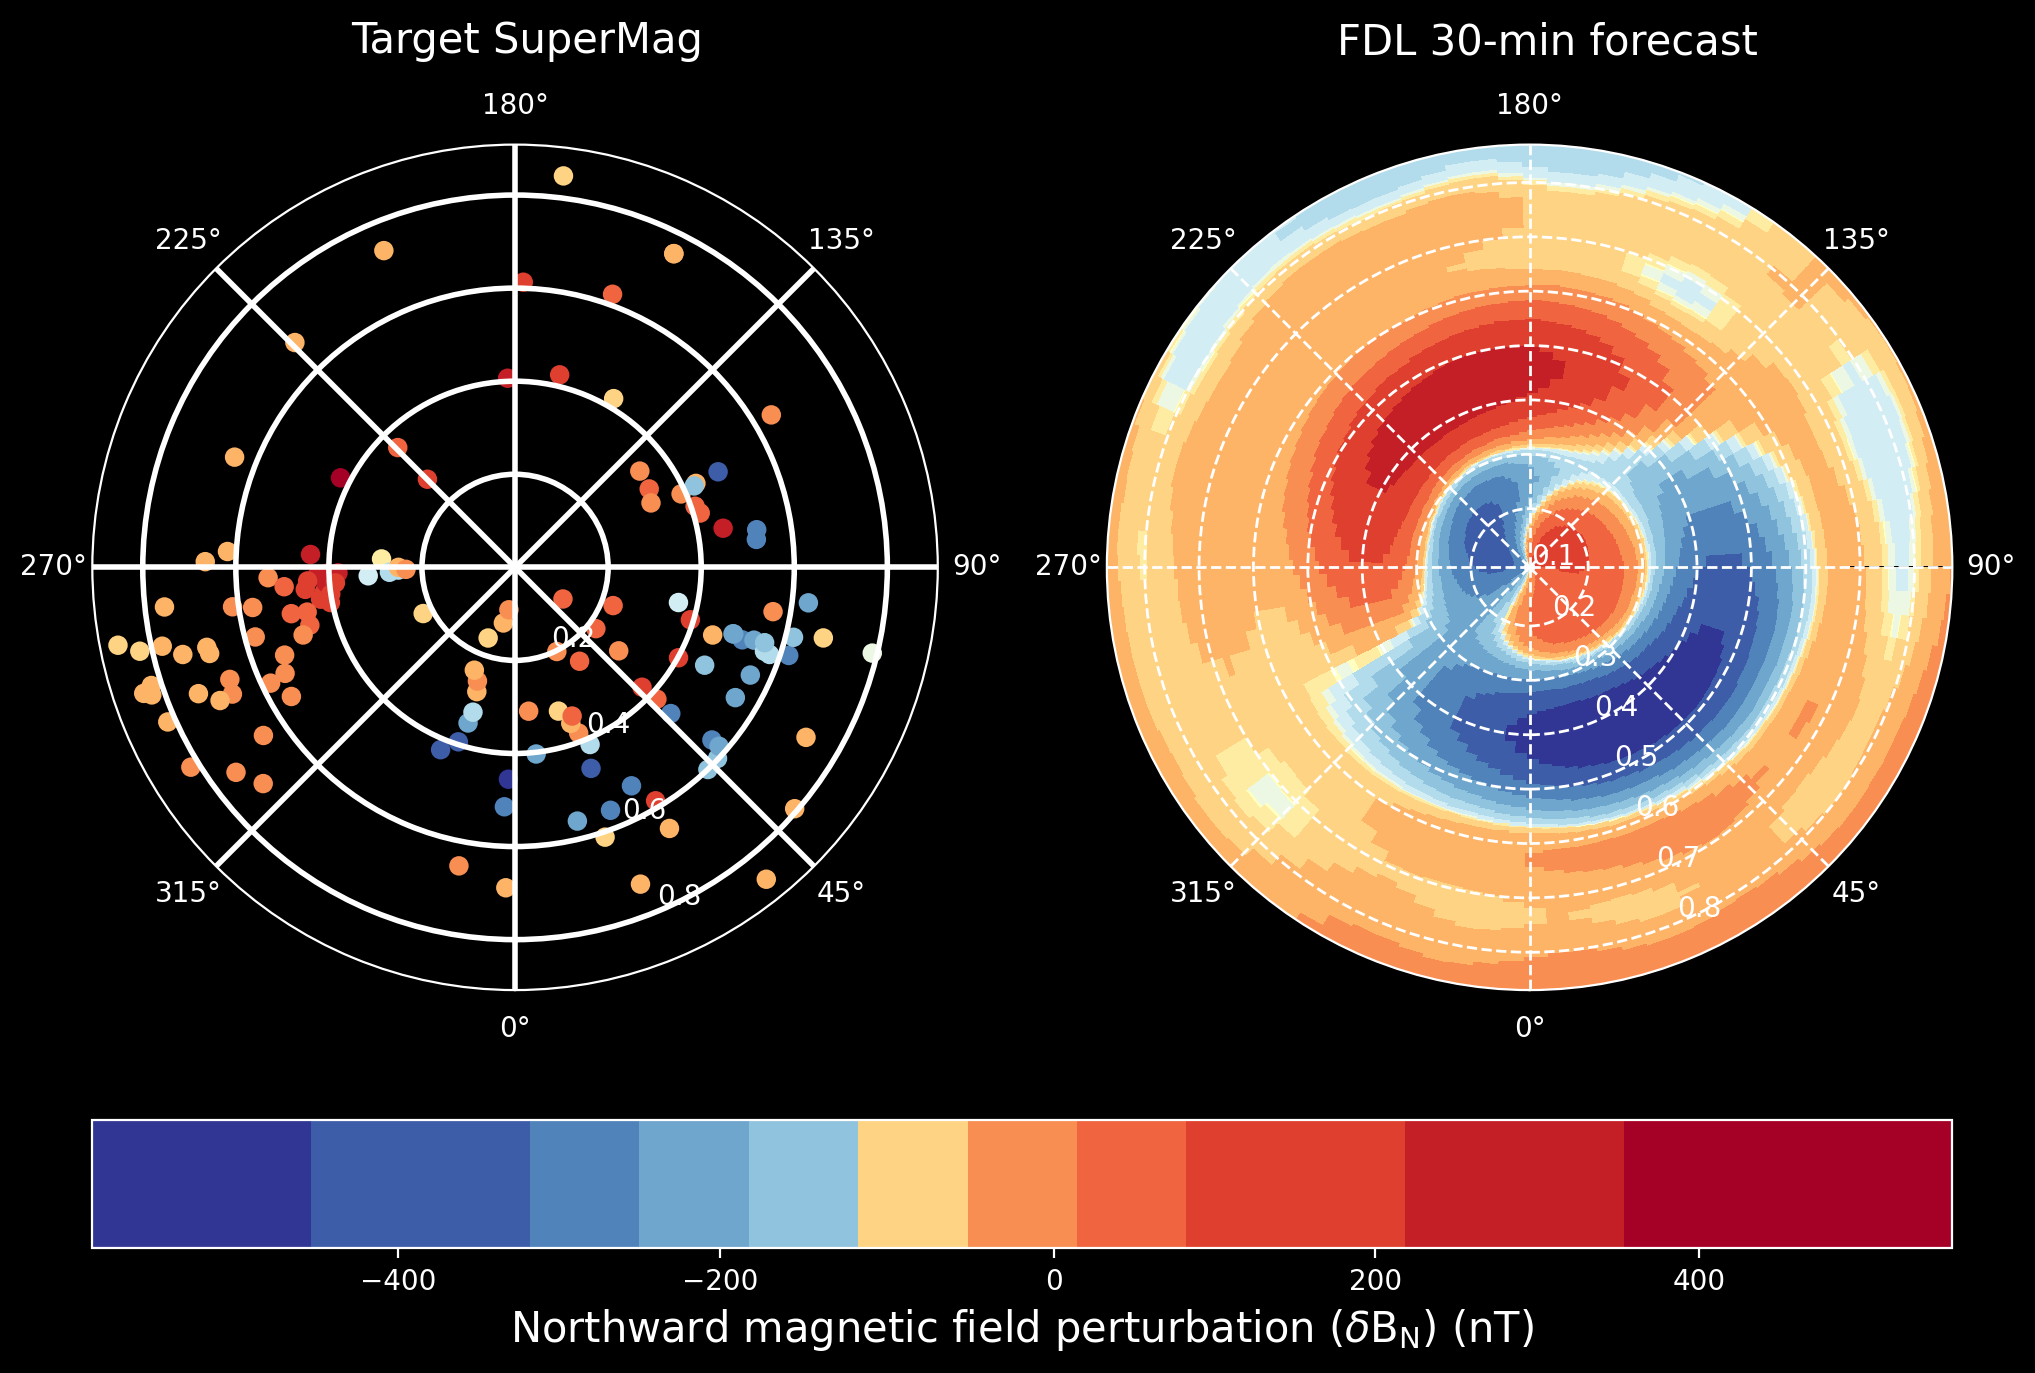

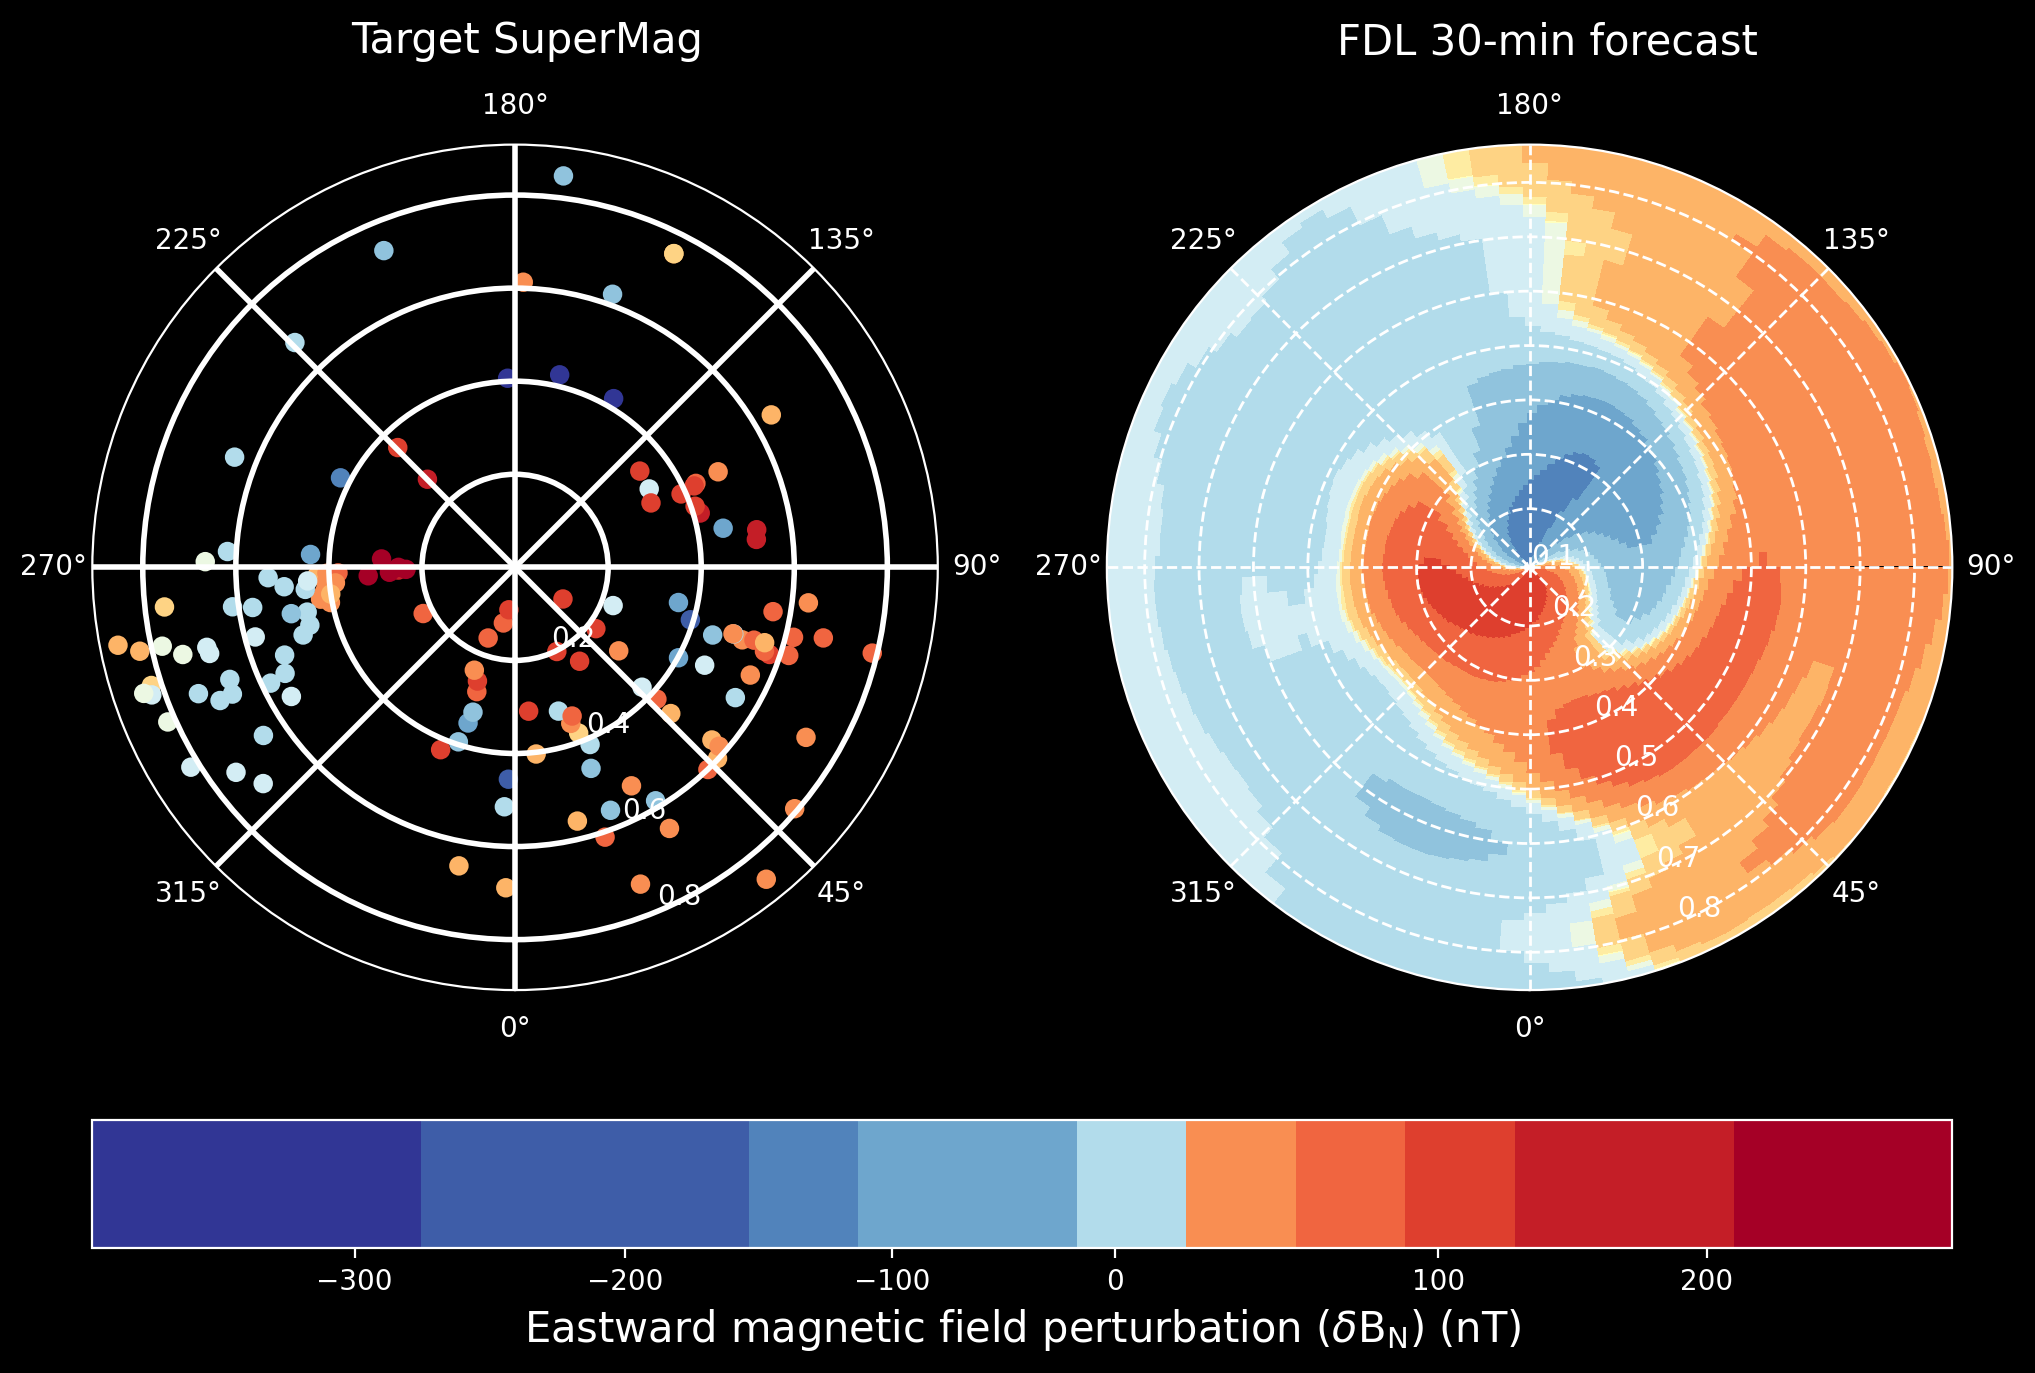

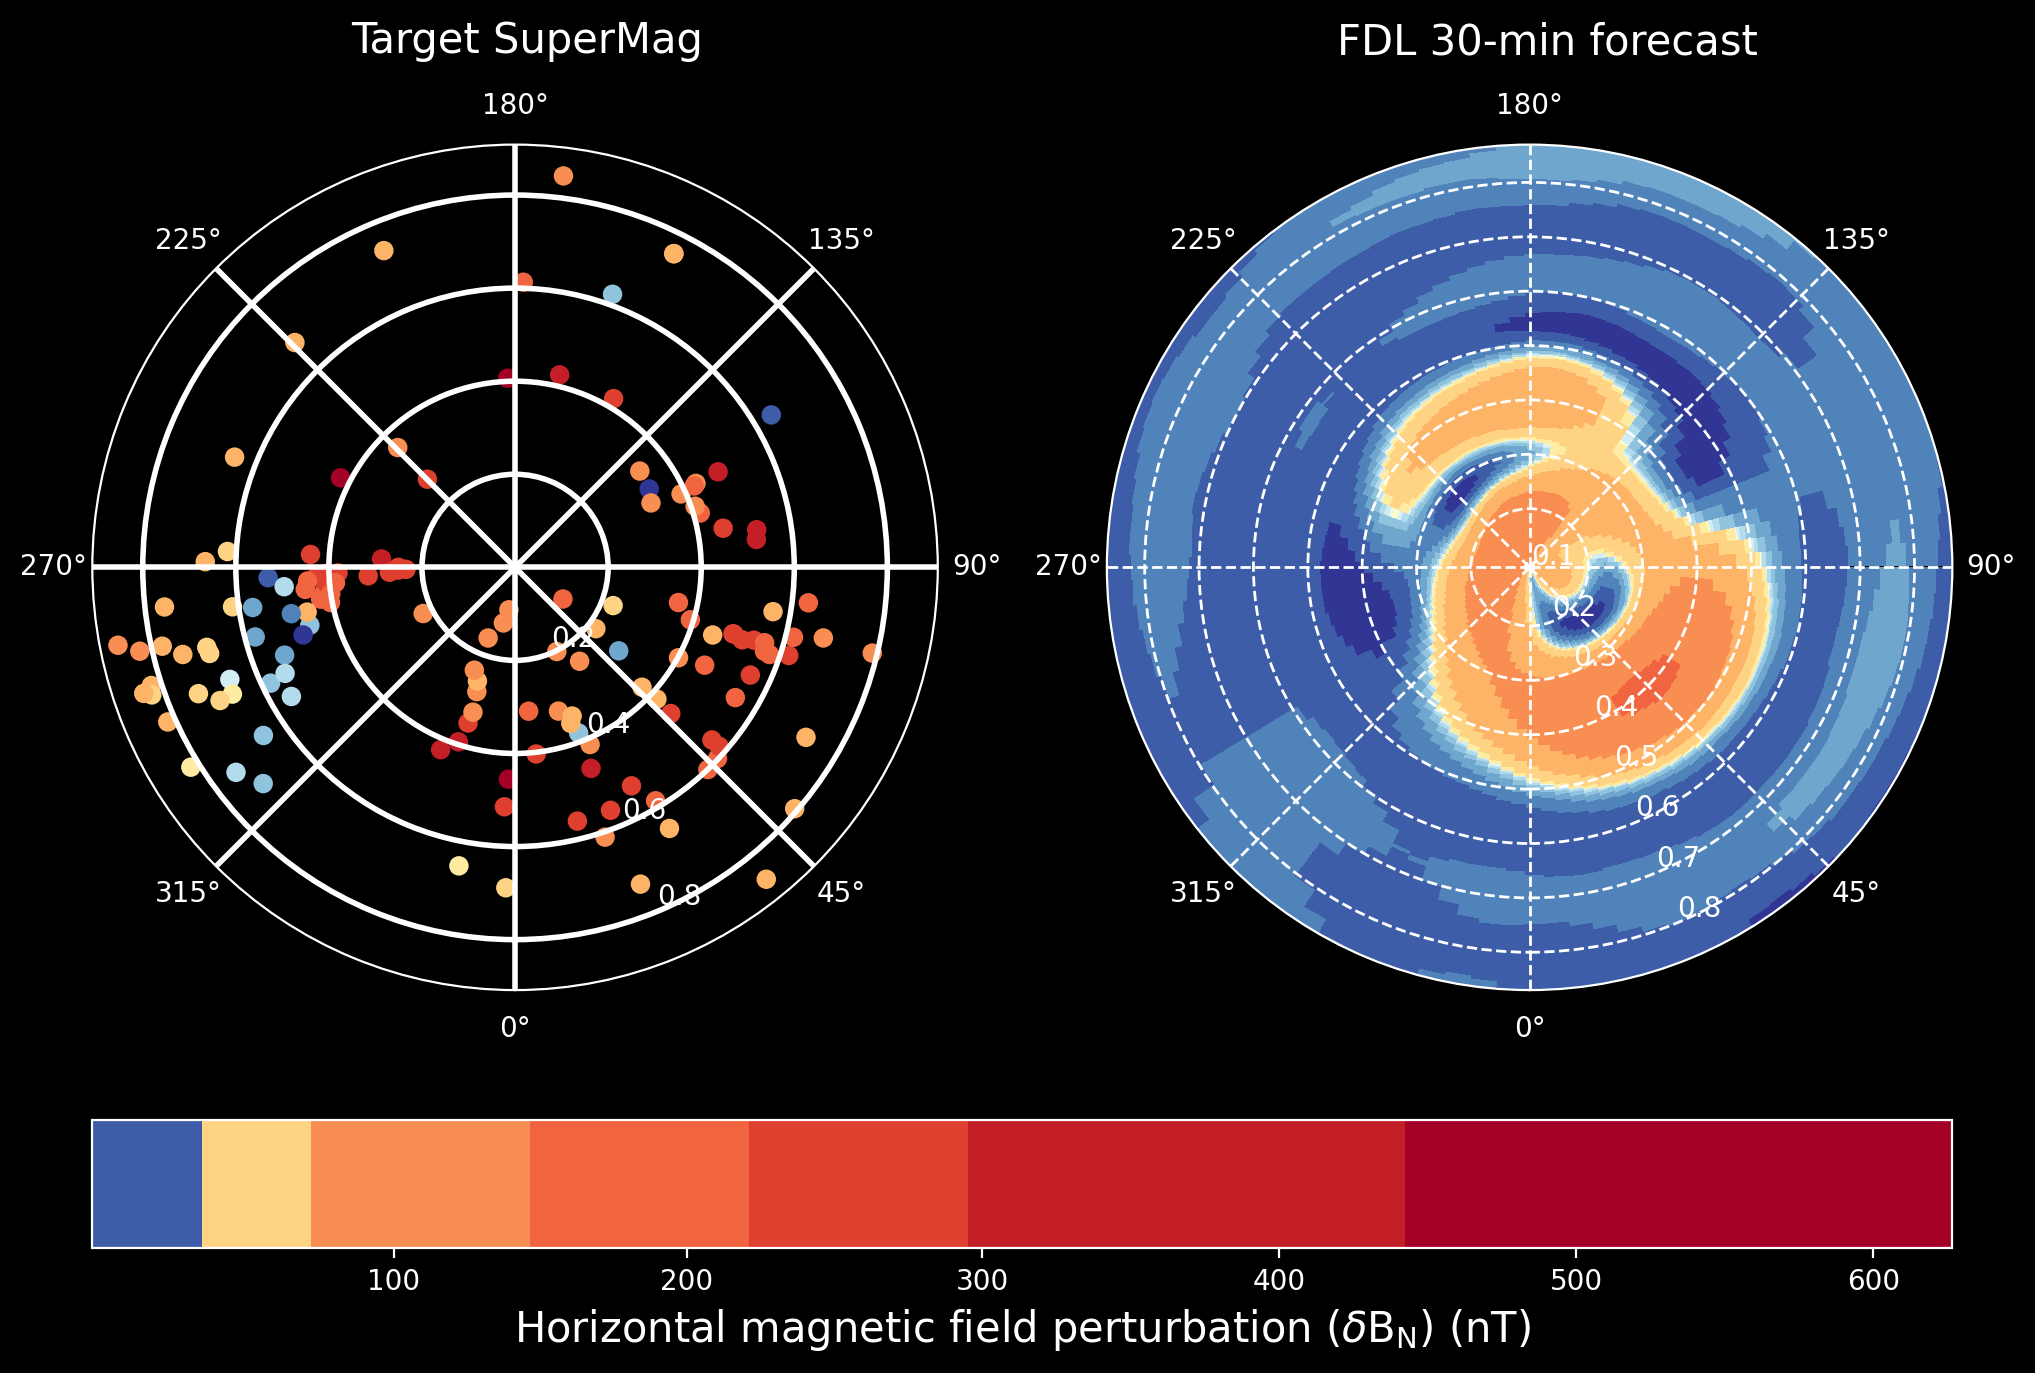

In [125]:
_ = Save_video(_mlt_2015,_colat_2015,wiemer_ds,fdl_on_grid_gif_2015['dbn'],
               MLT_sup_all_2015['dbn'][start:end+1],Mcolat_sup_all_2015['dbn'][start:end+1],Targets_2015['dbn'][start:end+1],
               savepath="../Paper/figures/storm_2015_dbn_video.mp4",start=start,end=end,k = 'dbn')
_ = Save_video(_mlt_2015,_colat_2015,wiemer_ds,fdl_on_grid_gif_2015['dbe'],
               MLT_sup_all_2015['dbe'][start:end+1],Mcolat_sup_all_2015['dbe'][start:end+1],Targets_2015['dbe'][start:end+1],
               savepath="../Paper/figures/storm_2015_dbe_video.mp4",start=start,end=end,k = 'dbe')
_ = Save_video(_mlt_2015,_colat_2015,wiemer_ds,tmp_bh,
               MLT_sup_all_2015['dbe'][start:end+1],Mcolat_sup_all_2015['dbe'][start:end+1],dbh_targ_2015,
               savepath="../Paper/figures/storm_2015_dbh_video.mp4",start=start,end=end,k = 'dbh')

# A short code to make nice figures of spherical harmonics

In [136]:
from scipy.special import sph_harm

In [148]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [181]:
fdl_on_grid_gif_2011['dbn'][...,0].shape,np.nanmin(fdl_on_grid_gif_2011['dbn'][...,0]),np.nanmax(fdl_on_grid_gif_2011['dbn'][...,0])

((360, 100), -16.11054463521865, 9.775309199762603)

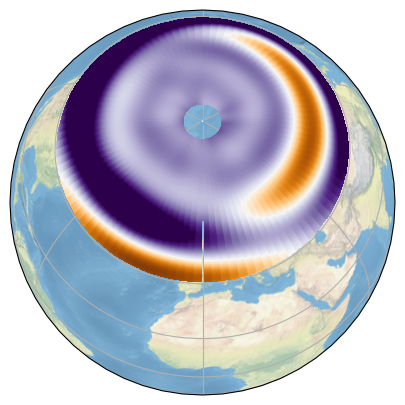

In [191]:
fig1 = plt.figure(figsize=(5,5))
plt.style.use('default')
ax1 = fig1.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 65))
extent = [np.min(np.rad2deg(_mlt_2011))+270,270+np.max(np.rad2deg(_mlt_2011)),np.min(90-np.rad2deg(_colat_2011)),np.max(90-np.rad2deg(_colat_2011))]
ax1.imshow(fdl_on_grid_gif_2011['dbn'][...,0], vmin=-10, vmax=10, transform=ccrs.PlateCarree(),
                  extent=extent, origin='lower', cmap="PuOr_r",zorder=10)
# c2=ax1.pcolormesh(np.rad2deg(_mlt_2011)+270,90-np.rad2deg(_colat_2011), 
#                   fdl_on_grid_gif_2011['dbn'][...,0],cmap='hot', transform=ccrs.PlateCarree())  
# ax1.grid("off")
ax1.stock_img()
ax1.gridlines()

In [205]:
n = 1
m = 1
tmp_mlt = np.linspace(0,360,360)
tmp_colat = np.linspace(0,180,360)
tmp_mlt,tmp_colat = np.meshgrid(tmp_mlt,tmp_colat)
y_mn = sph_harm(m, n, np.deg2rad(tmp_mlt), np.deg2rad(tmp_colat))

if m < 0:
    y_mn = np.sqrt(2) * (-1)**m * y_mn.imag
elif m > 0:
    y_mn = np.sqrt(2) * (-1)**m * y_mn.real
else:
    y_mn = y_mn.real

In [206]:
y_mn.shape

(360, 360)

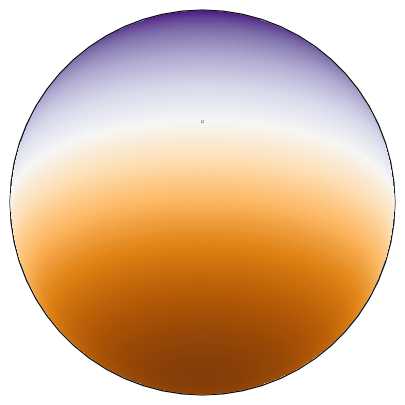

In [207]:
fig1 = plt.figure(figsize=(5,5))
plt.style.use('default')
ax1 = fig1.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 65))
extent = [np.min(tmp_mlt),np.max(tmp_mlt),np.min(90-tmp_colat),np.max(90-tmp_colat)]
ax1.imshow(y_mn, vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree(),
                  extent=extent, origin='lower', cmap="PuOr_r",zorder=10)
# ax1.grid("off")
ax1.stock_img()
ax1.gridlines()

In [214]:
def getsphm():
    lvalue = 3
    tmp_mlt = np.linspace(0,360,360)
    tmp_colat = np.linspace(0,180,360)
    tmp_mlt,tmp_colat = np.meshgrid(tmp_mlt,tmp_colat)
    real = []
    imag = []
    for l in np.arange(0,lvalue):
        real_m=[]
        imag_m=[]
        for m in np.arange(-l,l+1):
            y_mn = sph_harm(m, l, np.deg2rad(tmp_mlt), np.deg2rad(tmp_colat))
            real_m.append(y_mn.real)
            imag_m.append(y_mn.imag)
        real.append(real_m)
        imag.append(imag_m)
    return real,imag,tmp_mlt,tmp_colat

In [215]:
real,imag,tmp_mlt,tmp_colat = getsphm()

In [230]:
len(real[-1]),len(real[-2])

(5, 3)

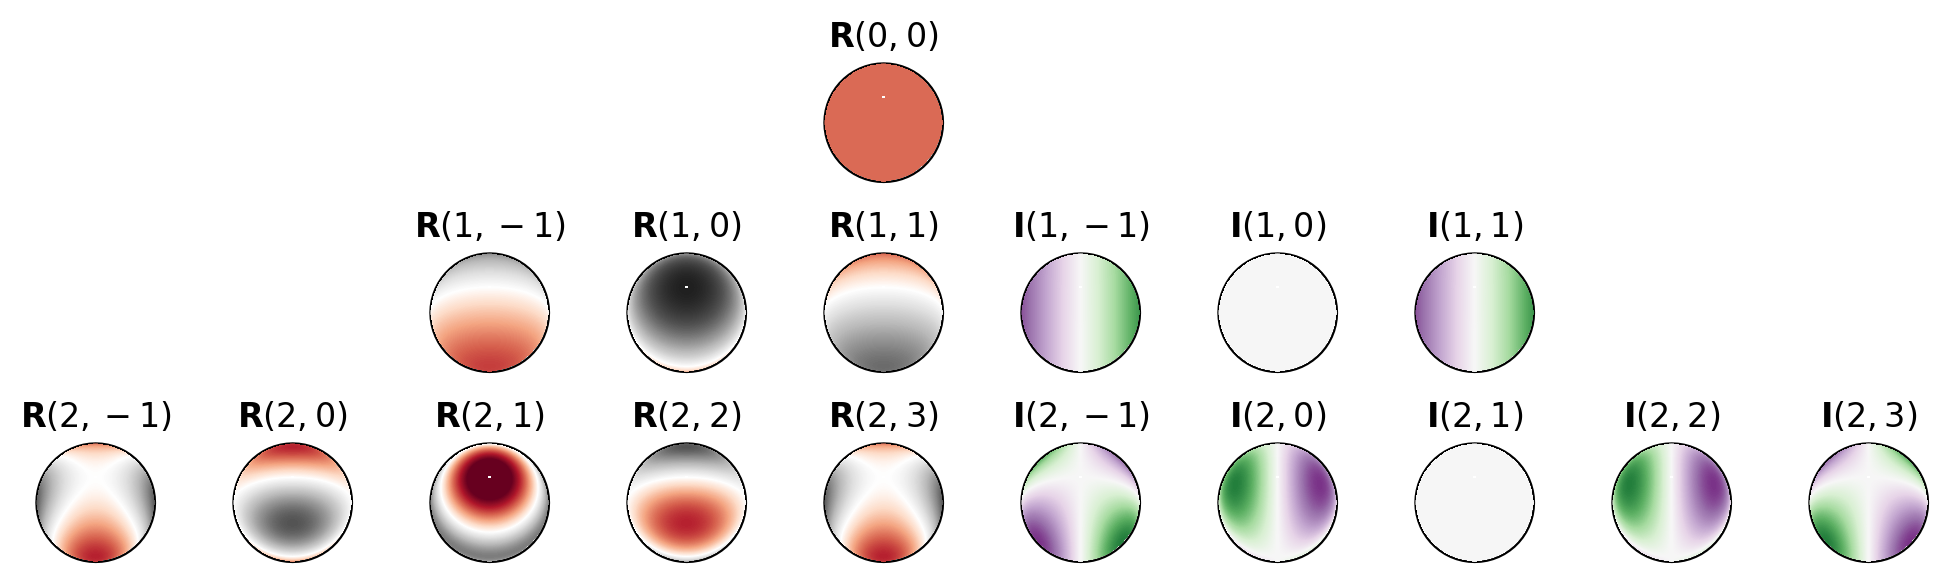

In [255]:
plt.style.use('default')
fig1 = plt.figure(figsize=(10,3),dpi=200)
gs = fig1.add_gridspec(3, 10)
for i,(realarr,imagrr) in enumerate(zip(real,imag)):
    sind_sph = 10//2-len(realarr)
    for j,(rar,iar) in enumerate(zip(realarr,imagrr)):
        ax = fig1.add_subplot(gs[i,sind_sph+j], projection=ccrs.Orthographic(0, 65))
        extent = [np.min(tmp_mlt),np.max(tmp_mlt),np.min(90-tmp_colat),np.max(90-tmp_colat)]
        ax.imshow(rar, vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree(),
                          extent=extent, origin='lower', cmap="RdGy_r",zorder=10)
        if i==0:
            ax.set_title(r"R$(%d,%d)$"%(i,j),fontweight='bold')
        else:
            ax.set_title(r"R$(%d,%d)$"%(i,j-1),fontweight='bold')
        if i!=0:
            ax = fig1.add_subplot(gs[i,sind_sph+len(realarr)+j], projection=ccrs.Orthographic(0, 65))
            extent = [np.min(tmp_mlt),np.max(tmp_mlt),np.min(90-tmp_colat),np.max(90-tmp_colat)]
            ax.imshow(iar, vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree(),
                          extent=extent, origin='lower', cmap="PRGn_r",zorder=10)
            ax.set_title(r"I$(%d,%d)$"%(i,j-1),fontweight='bold')
fig1.tight_layout()
plt.savefig("../Paper/figures/sphm_illus.png",dpi=300)